NOTE: The commented out code are either algorithms or other processes I tried, but were too computationally intensive. This notebook shows my thought process

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

# For visualizing
import seaborn as sns
import matplotlib.pyplot as plt

# For Machine learning models and data processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import missingno as msno

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf
import random
import sklearn.neighbors._base 
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.impute import KNNImputer

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

c:\Users\Public\Data_Science\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Importing the data for the accepted loans from The Lending Club
df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)
df.loan_status.unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

- I considered the instances with loan status value "does not meet the credit policy" as rejected to mitigate selection bias. Therefore, we select the rows with the loan status as follows: Fully Paid - Charged Off - Does not meet the credit policy. Status: Fully Paid - Does not meet the credit policy. Status: Charged off

- The interim statuses are ignored.

In [3]:
status = ['Fully Paid', 'Charged Off', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off']
df = df.loc[df.loan_status.isin(status)]
df.loan_status.unique()

array(['Fully Paid', 'Charged Off',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

- Assign 1 for values with loan status `Charged Off` and `Does not meet the credit policy. Status:Charged Off` and 0 for values with loan status `Fully Paid` and `Does not meet the credit policy. Status:Charged Off`

In [4]:
df.loan_status = df.loan_status.replace('Fully Paid', 0)
df.loan_status = df.loan_status.replace('Does not meet the credit policy. Status:Fully Paid', 0)
df.loan_status = df.loan_status.replace('Charged Off', 1)
df.loan_status = df.loan_status.replace('Does not meet the credit policy. Status:Charged Off', 1)
df.loan_status.unique()

array([0, 1], dtype=int64)

In [5]:
def delete_columns(df, cutoff):
    missing = df.isnull().sum()
    missing_percent = 100 * missing / len(df)
    missing_type = df.dtypes

    missing_table = pd.concat([missing, missing_percent, missing_type], axis = 1)

    missing_table_renamed = missing_table.rename(columns = {0: 'Missing Values', 1: 'Percentage of Total Values', 2: 'Type'})

    missing_table_renamed = missing_table_renamed[missing_table_renamed.iloc[:, 1] != 0].sort_values('Percentage of Total Values', ascending = False).round(2)

    index = missing_table_renamed.loc[missing_table_renamed['Percentage of Total Values'] >= cutoff].index

    df = df.drop(columns=index)

    return df, missing_table_renamed

- If the the percentage of missing value among total values is greater than 50%, we drop the columns

In [6]:
df = delete_columns(df, 50)[0]
missing_status = delete_columns(df, 50)[1]
df.shape

(1348059, 93)

In [7]:
missing_status

Missing Values  Percentage of Total Values  \
mths_since_recent_inq               176820                       13.12   
num_tl_120dpd_2m                    120150                        8.91   
mo_sin_old_il_acct                  108324                        8.04   
emp_title                            85944                        6.38   
emp_length                           78545                        5.83   
pct_tl_nvr_dlq                       70430                        5.22   
avg_cur_bal                          70298                        5.21   
num_rev_accts                        70277                        5.21   
mo_sin_rcnt_rev_tl_op                70277                        5.21   
mo_sin_old_rev_tl_op                 70277                        5.21   
total_il_high_credit_limit           70276                        5.21   
num_tl_op_past_12m                   70276                        5.21   
num_il_tl                            70276                        5.21   
num_bc_tl                            70276                        5.21   
num_actv_rev_tl                      70276                        5.21   
num_actv_bc_tl                       70276                        5.21   
num_accts_ever_120_pd                70276                        5.21   
mo_sin_rcnt_tl                       70276                        5.21   
num_tl_30dpd                         70276                        5.21   
num_rev_tl_bal_gt_0                  70276                        5.21   
num_tl_90g_dpd_24m                   70276                        5.21   
num_op_rev_tl                        70276                        5.21   
tot_coll_amt                         70276                        5.21   
tot_hi_cred_lim                      70276                        5.21   
total_rev_hi_lim                     70276                        5.21   
tot_cur_bal                          70276                        5.21   
bc_util                              64661                        4.80   
percent_bc_gt_75                     64304                        4.77   
bc_open_to_buy                       63892                        4.74   
mths_since_recent_bc                 62970                        4.67   
num_sats                             58590                        4.35   
num_bc_sats                          58590                        4.35   
acc_open_past_24mths                 50030                        3.71   
total_bal_ex_mort                    50030                        3.71   
total_bc_limit                       50030                        3.71   
mort_acc                             50030                        3.71   
title                                16661                        1.24   
last_pymnt_d                          2325                        0.17   
pub_rec_bankruptcies                  1365                        0.10   
revol_util                             897                        0.07   
dti                                    374                        0.03   
chargeoff_within_12_mths               145                        0.01   
collections_12_mths_ex_med             145                        0.01   
tax_liens                              105                        0.01   
last_credit_pull_d                      57                        0.00   
inq_last_6mths                          30                        0.00   
delinq_2yrs                             29                        0.00   
earliest_cr_line                        29                        0.00   
delinq_amnt                             29                        0.00   
open_acc                                29                        0.00   
acc_now_delinq                          29                        0.00   
total_acc                               29                        0.00   
pub_rec                                 29                        0.00   
annual_inc                      

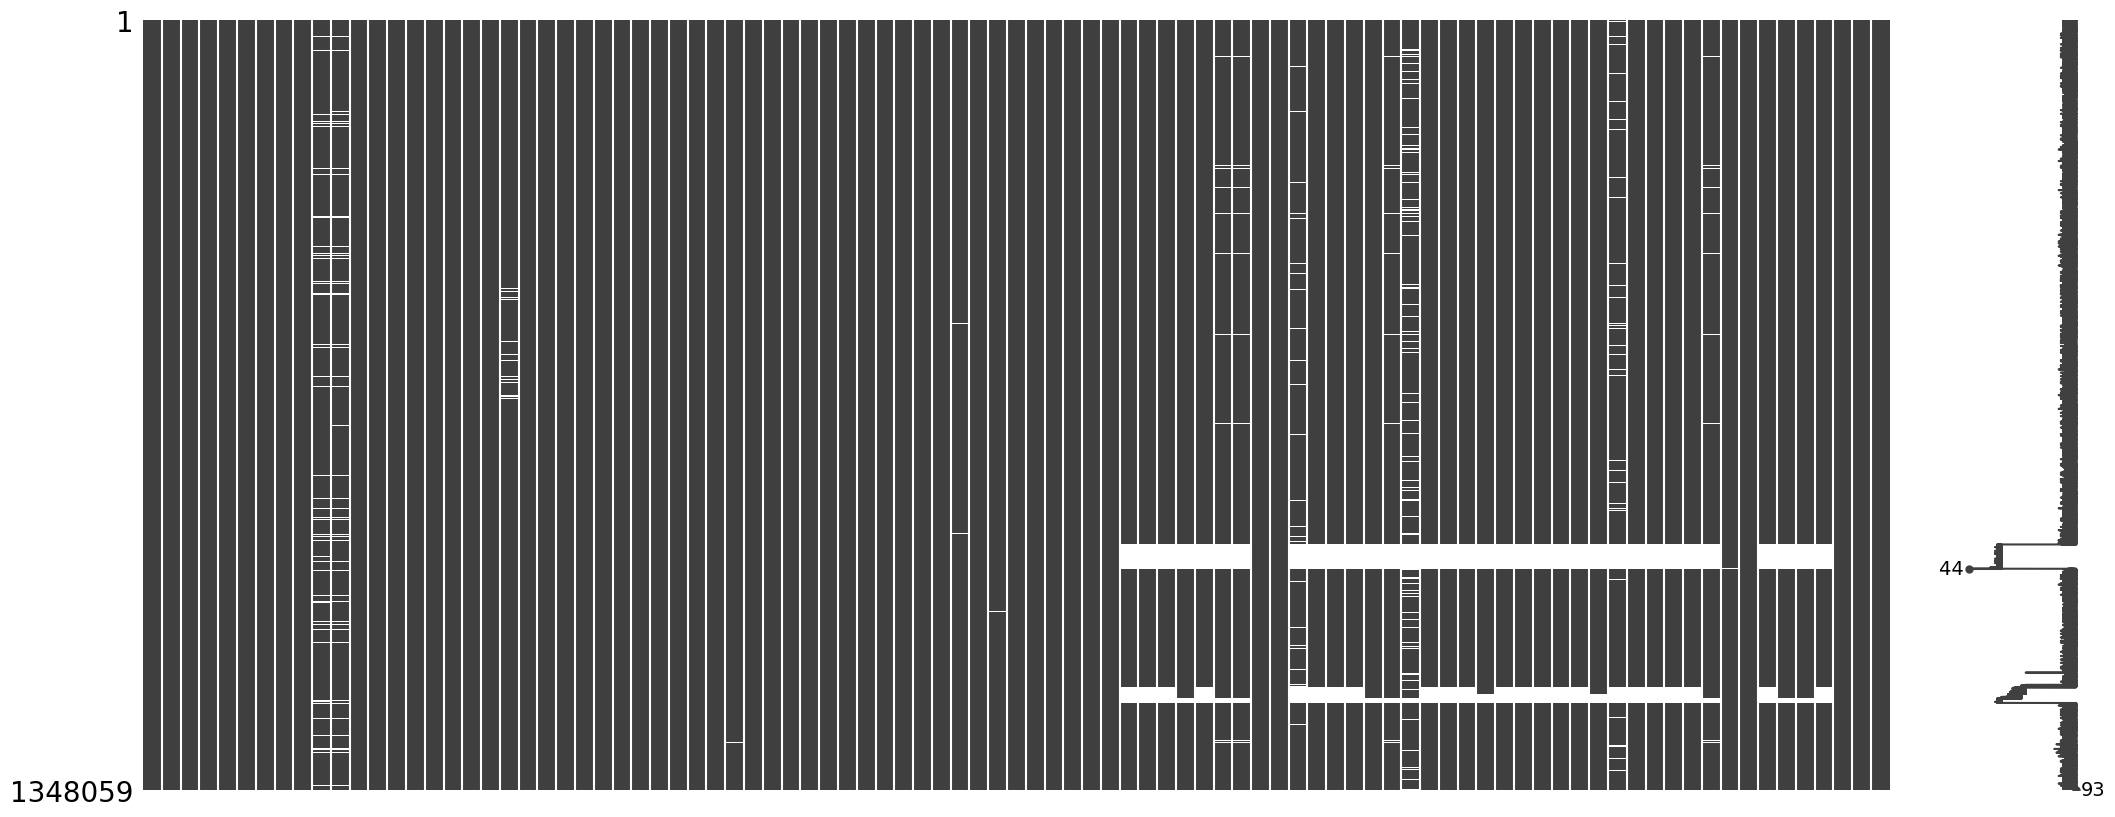

In [8]:
msno.matrix(df);

In [9]:
df.head()

id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0  68407277     3600.0       3600.0           3600.0   36 months     13.99   
1  68355089    24700.0      24700.0          24700.0   36 months     11.99   
2  68341763    20000.0      20000.0          20000.0   60 months     10.78   
4  68476807    10400.0      10400.0          10400.0   60 months     22.45   
5  68426831    11950.0      11950.0          11950.0   36 months     13.44   

   installment grade sub_grade             emp_title  ... percent_bc_gt_75  \
0       123.03     C        C4               leadman  ...              0.0   
1       820.28     C        C1              Engineer  ...              7.7   
2       432.66     B        B4          truck driver  ...             50.0   
4       289.91     F        F1   Contract Specialist  ...             60.0   
5       405.18     C        C3  Veterinary Tecnician  ...            100.0   

  pub_rec_bankruptcies  tax_liens tot_hi_cred_lim total_bal_ex_mort  \
0                  0.0        0.0        178050.0            7746.0   
1                  0.0        0.0        314017.0           39475.0   
2                  0.0        0.0        218418.0           18696.0   
4                  0.0        0.0        439570.0           95768.0   
5                  0.0        0.0         16900.0           12798.0   

   total_bc_limit total_il_high_credit_limit hardship_flag  \
0          2400.0                    13734.0             N   
1         79300.0                    24667.0             N   
2          6200.0                    14877.0             N   
4         20300.0                    88097.0             N   
5          9400.0                     4000.0             N   

  disbursement_method debt_settlement_flag  
0                Cash                    N  
1                Cash                    N  
2                Cash                    N  
4                Cash                    N  
5                Cash                    N  

[5 rows x 93 columns]

In [10]:
df.term = df.term.apply(lambda s: np.int8(s.split()[0]))
df.term = df.term.astype(str)

- Let's decide which variables that might create outcome bias and drop those variables.

In [11]:
df_description = pd.read_excel('LCDataDictionary.xlsx')
columns = df.columns
df_description = df_description.loc[df_description.LoanStatNew.isin(columns)].loc[:, ['LoanStatNew', 'Description']]
df_description

LoanStatNew                                        Description
0          acc_now_delinq  The number of accounts on which the borrower i...
1    acc_open_past_24mths         Number of trades opened in past 24 months.
2              addr_state  The state provided by the borrower in the loan...
4              annual_inc  The self-reported annual income provided by th...
6        application_type  Indicates whether the loan is an individual ap...
..                    ...                                                ...
112   verification_status  Indicates if income was verified by LC, not ve...
114              zip_code  The first 3 numbers of the zip code provided b...
128         hardship_flag  Flags whether or not the borrower is on a hard...
143   disbursement_method  The method by which the borrower receives thei...
144  debt_settlement_flag  Flags whether or not the borrower, who has cha...

[92 rows x 2 columns]

In [12]:
drop_outcome_bias = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']
df = df.drop(columns=drop_outcome_bias)
df.shape

(1348059, 35)

In [13]:
df.columns

Index(['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'url', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'policy_code',
       'application_type', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mort_acc', 'pub_rec_bankruptcies'],
      dtype='object')

- Let's drop the columns 'id', and 'url'

- Also there are too many unique values in emp_title. So let's drop this column as well

- The total number of missing rows in pub_rec_bankruptcies is below 1500 and they are also deleted because there in charged off data we lose around 0.001% of data. Since we'll use oversampling, this is acceptable. And the rows corresponding to the missing values in this column have also missing values in another columns.

In [14]:
df.emp_title.nunique(), df.title.nunique()

(379858, 63152)

In [15]:
df = df.drop(columns= ['id', 'url', 'emp_title', 'title'])
df.shape

(1348059, 31)

In [16]:
df = df.reset_index().drop(columns= ['index'])
del_index = df.loc[df.pub_rec_bankruptcies.isna() == True].index
df = df.drop(index=del_index).reset_index().drop(columns=['index'])

del_index2 = np.array(df.loc[df.zip_code.isna() == True].index)
df = df.drop(index = del_index2)
df = df.reset_index().drop(columns=['index'])

df

loan_amnt term  int_rate  installment grade sub_grade emp_length  \
0           3600.0   36     13.99       123.03     C        C4  10+ years   
1          24700.0   36     11.99       820.28     C        C1  10+ years   
2          20000.0   60     10.78       432.66     B        B4  10+ years   
3          10400.0   60     22.45       289.91     F        F1    3 years   
4          11950.0   36     13.44       405.18     C        C3    4 years   
...            ...  ...       ...          ...   ...       ...        ...   
1346688    18000.0   60      9.49       377.95     B        B2    5 years   
1346689    29400.0   60     13.99       683.94     C        C3    9 years   
1346690    32000.0   60     14.49       752.74     C        C4    3 years   
1346691    16000.0   60     12.79       362.34     C        C1  10+ years   
1346692    24000.0   60     14.49       564.56     C        C4    6 years   

        home_ownership  annual_inc verification_status  ... revol_bal  \
0             MORTGAGE     55000.0        Not Verified  ...    2765.0   
1             MORTGAGE     65000.0        Not Verified  ...   21470.0   
2             MORTGAGE     63000.0        Not Verified  ...    7869.0   
3             MORTGAGE    104433.0     Source Verified  ...   21929.0   
4                 RENT     34000.0     Source Verified  ...    8822.0   
...                ...         ...                 ...  ...       ...   
1346688            OWN    130000.0        Not Verified  ...   23833.0   
1346689       MORTGAGE    180792.0        Not Verified  ...   77480.0   
1346690       MORTGAGE    157000.0     Source Verified  ...  111598.0   
1346691           RENT    150000.0        Not Verified  ...    7700.0   
1346692           RENT    110000.0        Not Verified  ...   17641.0   

         revol_util total_acc initial_list_status policy_code  \
0              29.7      13.0                   w         1.0   
1              19.2      38.0                   w         1.0   
2              56.2      18.0                   w         1.0   
3              64.5      35.0                   w         1.0   
4              68.4       6.0                   w         1.0   
...             ...       ...                 ...         ...   
1346688        34.0      39.0                   f         1.0   
1346689        85.2      32.0                   f         1.0   
1346690        27.4      18.0                   f         1.0   
1346691        55.0      28.0                   f         1.0   
1346692        68.1      31.0                   f         1.0   

         application_type mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mort_acc  \
0              Individual              148.0                 128.0       1.0   
1              Individual              113.0                 192.0       4.0   
2               Joint App              125.0                 184.0       5.0   
3              Individual              128.0                 210.0       6.0   
4              Individual              338.0                  54.0       0.0   
...                   ...                ...                   ...       ...   
1346688        Individual              113.0                 146.0       3.0   
1346689        Individual              145.0                 174.0       3.0   
1346690        Individual               53.0                  63.0       3.0   
1346691        Individual              147.0                 229.0       0.0   
1346692        Individual              132.0                 206.0       2.0   

         pub_rec_bankruptcies  
0                         0.0  
1                         0.0  
2                         0.0  
3                         0.0  
4                         0.0  
...                       ...  
1346688                   0.0  
1346689                   0.0  
1346690                   0.0  
1346691                   3.0  
1346692                   1.0  

[1346693 rows x 31 columns]

In [17]:
col_with_missing2 = pd.DataFrame(df.isna().sum()).loc[pd.DataFrame(df.isna().sum())[0] != 0].index
df2 = df.loc[:, col_with_missing2]

col_with_missing3 = pd.DataFrame(df.isna().sum()).loc[pd.DataFrame(df.isna().sum())[0] != 0].index
df3 = df.loc[:, col_with_missing3]

In [18]:
df3.isna().sum()

emp_length               78545
dti                        374
revol_util                 865
mo_sin_old_il_acct      106959
mo_sin_old_rev_tl_op     68912
mort_acc                 48665
dtype: int64

In [19]:
df3.dtypes

emp_length               object
dti                     float64
revol_util              float64
mo_sin_old_il_acct      float64
mo_sin_old_rev_tl_op    float64
mort_acc                float64
dtype: object

- emp_length will be label encoded. the increase in emp_length decreases the number of charged off loans. We can plot this as an important graph

In [20]:
df.loc[:, ['emp_length', 'loan_status', 'loan_amnt']].groupby(by=['emp_length', 'loan_status']).count()

loan_amnt
emp_length loan_status           
1 year     0                70389
           1                18238
10+ years  0               359315
           1                83154
2 years    0                97767
           1                24164
3 years    0                86213
           1                21532
4 years    0                64742
           1                15929
5 years    0                67734
           1                16527
6 years    0                50647
           1                12168
7 years    0                48045
           1                11637
8 years    0                48645
           1                12127
9 years    0                40837
           1                10152
< 1 year   0                85973
           1                22213

In [21]:
df.loc[:, ['emp_length', 'loan_status', 'loan_amnt']].groupby(by=['emp_length']).count()

loan_status  loan_amnt
emp_length                        
1 year            88627      88627
10+ years        442469     442469
2 years          121931     121931
3 years          107745     107745
4 years           80671      80671
5 years           84261      84261
6 years           62815      62815
7 years           59682      59682
8 years           60772      60772
9 years           50989      50989
< 1 year         108186     108186

In [22]:
df.emp_length.nunique(), df.emp_length.unique()

(11,
 array(['10+ years', '3 years', '4 years', '6 years', '7 years', '8 years',
        '2 years', '5 years', '9 years', '< 1 year', '1 year', nan],
       dtype=object))

In [23]:
'''df['emp_length_encoded'] = np.where(df['emp_length'] == '< 1 year', 1,
                            np.where(df['emp_length'] == '1 year', 1,
                                np.where(df['emp_length'] == '2 years', 2,
                                    np.where(df['emp_length'] == '3 years', 3,
                                        np.where(df['emp_length'] == '4 years', 4,
                                            np.where(df['emp_length'] == '5 years', 5,
                                                np.where(df['emp_length'] == '6 years', 6,
                                                    np.where(df['emp_length'] == '7 years', 7,
                                                        np.where(df['emp_length'] == '8 years', 8,
                                                            np.where(df['emp_length'] == '9 years', 9,
                                                                np.where(df['emp_length'] == '10+ years', 10, np.NaN)))))))))))'''

"df['emp_length_encoded'] = np.where(df['emp_length'] == '< 1 year', 1,\n                            np.where(df['emp_length'] == '1 year', 1,\n                                np.where(df['emp_length'] == '2 years', 2,\n                                    np.where(df['emp_length'] == '3 years', 3,\n                                        np.where(df['emp_length'] == '4 years', 4,\n                                            np.where(df['emp_length'] == '5 years', 5,\n                                                np.where(df['emp_length'] == '6 years', 6,\n                                                    np.where(df['emp_length'] == '7 years', 7,\n                                                        np.where(df['emp_length'] == '8 years', 8,\n                                                            np.where(df['emp_length'] == '9 years', 9,\n                                                                np.where(df['emp_length'] == '10+ years', 10, np.NaN)))))))))))"

In [24]:
'''df = df.drop(columns= ['emp_length'])
df.shape'''

"df = df.drop(columns= ['emp_length'])\ndf.shape"

In [25]:
ctrl = pd.merge(pd.DataFrame(df.isna().sum()).reset_index(), pd.DataFrame(df.dtypes).reset_index(), on=['index'], how='left')
ctrl.loc[ctrl['0_x'] != 0]

index     0_x      0_y
6             emp_length   78545   object
15                   dti     374  float64
22            revol_util     865  float64
27    mo_sin_old_il_acct  106959  float64
28  mo_sin_old_rev_tl_op   68912  float64
29              mort_acc   48665  float64

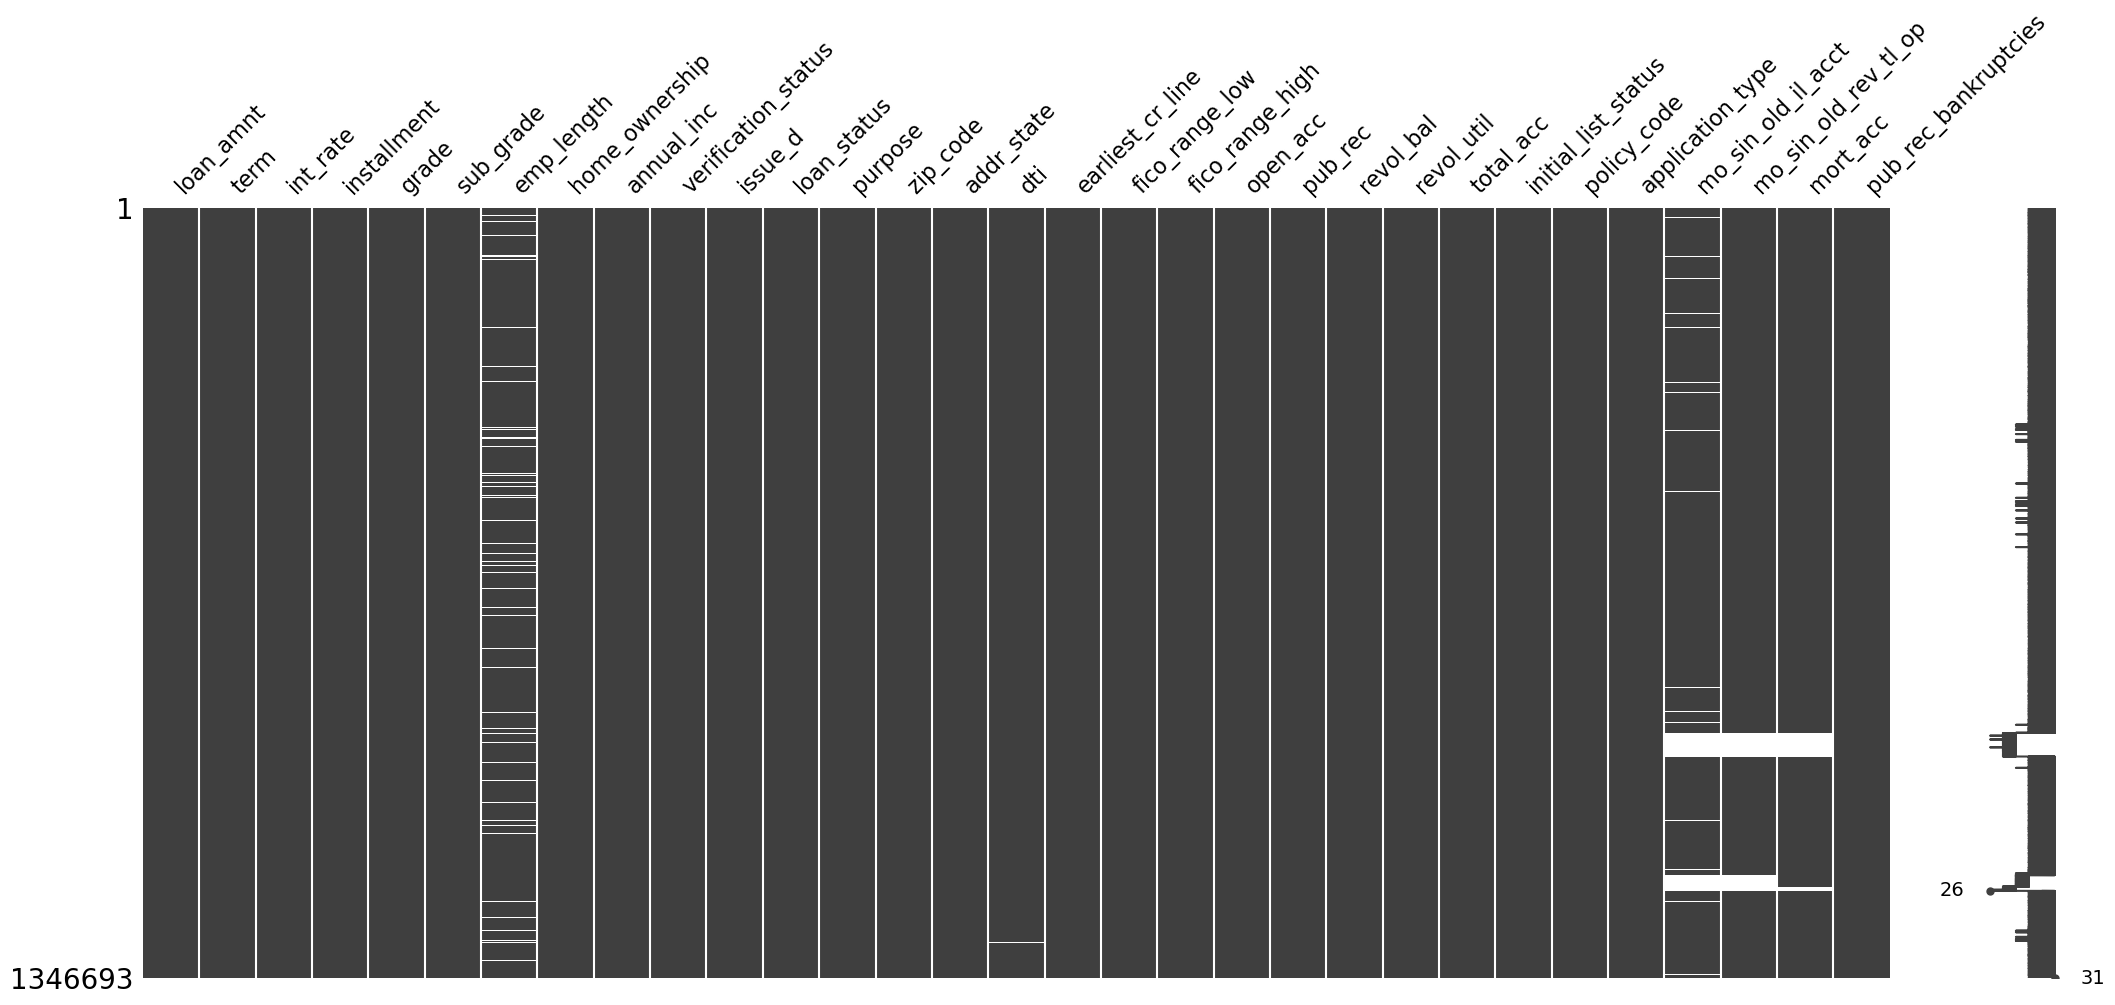

In [26]:
msno.matrix(df);

IMPUTE MISSING VALUES

- FAMD - We tried both in Python and R with different libraries. However, because of our dataset is too large, we encountered memory error.

    - @software{Halford_Prince,
    author = {Halford, Max},
    license = {MIT},
    title = {{Prince}},
    url = {https://github.com/MaxHalford/prince}
}

In [28]:
'''import prince
famd = prince.FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)
famd = famd.fit(df)'''

'import prince\nfamd = prince.FAMD(\n    n_components=2,\n    n_iter=3,\n    copy=True,\n    check_input=True,\n    random_state=42,\n    engine="sklearn",\n    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder\n)\nfamd = famd.fit(df)'

In [29]:
'''famd.eigenvalues_summary

famd.row_coordinates(df).head()

famd.column_coordinates_

famd.plot(
    df,
    x_component=0,
    y_component=1
)

(
    famd.row_contributions_
    .sort_values(0, ascending=False)
    .head(5)
    .style.format('{:.3%}')
)

famd.column_contributions_.style.format('{:.0%}')'''

"famd.eigenvalues_summary\n\nfamd.row_coordinates(df).head()\n\nfamd.column_coordinates_\n\nfamd.plot(\n    df,\n    x_component=0,\n    y_component=1\n)\n\n(\n    famd.row_contributions_\n    .sort_values(0, ascending=False)\n    .head(5)\n    .style.format('{:.3%}')\n)\n\nfamd.column_contributions_.style.format('{:.0%}')"

We tried to implement FAMD or MissForest which uses Random Forest model to impute missing values. However, our dataset is too large. Therefore, we try another missing value imputation method

- Advantages of Missing Forest

    - It can work with mixed data, both numerical and categorical

    - Miss Forest can handle outliers, so there is no need for feature scaling.

    - Random Forests have inherent feature selection, which makes them robust to noisy data.

    - It can handle non-linearity in data

- Disadvantages of Missing Forest

    - Multiple trees need to be constructed for each iteration, and it becomes computationally expensive when the number of predictors and observations increases.

    - Also, it’s an algorithm, not a model object, meaning it must be run every time data is imputed, which could be problematic in some production environments.

- We'll use Mice Forest.

    - Mice algorithm stands for Multiple Imputation By Chained Equation. Technically any predictive model can be used with mice for imputation. Here we will be using LIghtGBM for prediction. And this is more or less similar to miss forest as far as pseudocode of algorithm is involved. The only difference in the package we will be dealing with is it uses a LightGBM instead of a pure Random Forest.  

In [30]:
'''import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

# Make an instance and perform the imputation
imputer = MissForest()
df_missforest = df.filter(['dti',	'revol_util', 'mo_sin_old_il_acct',	'mo_sin_old_rev_tl_op', 'mort_acc', 'emp_length_encoded'], axis=1).copy()
df_missforest_imputed = imputer.fit_transform(df_missforest)'''

"import sys\nimport sklearn.neighbors._base\nsys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base\nfrom missingpy import MissForest\n\n# Make an instance and perform the imputation\nimputer = MissForest()\ndf_missforest = df.filter(['dti',\t'revol_util', 'mo_sin_old_il_acct',\t'mo_sin_old_rev_tl_op', 'mort_acc', 'emp_length_encoded'], axis=1).copy()\ndf_missforest_imputed = imputer.fit_transform(df_missforest)"

In [31]:
'''# Add imputed values as columns to the untouched dataset
iris_orig['MF_sepal_length'] = X_imputed[:, 0]
iris_orig['MF_petal_width'] = X_imputed[:, -1]
comparison_df = iris_orig[['sepal_length', 'MF_sepal_length', 'petal_width', 'MF_petal_width']]

# Calculate absolute errors
comparison_df['ABS_ERROR_sepal_length'] = np.abs(compaison_df['sepal_length'] - comparison_df['MF_sepal_length'])
comparison_df['ABS_ERROR_petal_width'] = np.abs(compaison_df['petal_width'] - comparison_df['MF_petal_width'])

# Show only rows where imputation was performed
comparison_df.iloc[sorted([*inds1, *inds2])]'''

"# Add imputed values as columns to the untouched dataset\niris_orig['MF_sepal_length'] = X_imputed[:, 0]\niris_orig['MF_petal_width'] = X_imputed[:, -1]\ncomparison_df = iris_orig[['sepal_length', 'MF_sepal_length', 'petal_width', 'MF_petal_width']]\n\n# Calculate absolute errors\ncomparison_df['ABS_ERROR_sepal_length'] = np.abs(compaison_df['sepal_length'] - comparison_df['MF_sepal_length'])\ncomparison_df['ABS_ERROR_petal_width'] = np.abs(compaison_df['petal_width'] - comparison_df['MF_petal_width'])\n\n# Show only rows where imputation was performed\ncomparison_df.iloc[sorted([*inds1, *inds2])]"

In [32]:
# Mode Imputation
df_mode = df.copy(deep=True)
mode_imputer = SimpleImputer(strategy="most_frequent")
df_mode['emp_length'] = mode_imputer.fit_transform(df_mode['emp_length'].values.reshape(-1,1))

In [33]:
df_mode.groupby(by='emp_length').count()

loan_amnt    term  int_rate  installment   grade  sub_grade  \
emp_length                                                                
1 year          88627   88627     88627        88627   88627      88627   
10+ years      521014  521014    521014       521014  521014     521014   
2 years        121931  121931    121931       121931  121931     121931   
3 years        107745  107745    107745       107745  107745     107745   
4 years         80671   80671     80671        80671   80671      80671   
5 years         84261   84261     84261        84261   84261      84261   
6 years         62815   62815     62815        62815   62815      62815   
7 years         59682   59682     59682        59682   59682      59682   
8 years         60772   60772     60772        60772   60772      60772   
9 years         50989   50989     50989        50989   50989      50989   
< 1 year       108186  108186    108186       108186  108186     108186   

            home_ownership  annual_inc  verification_status  issue_d  ...  \
emp_length                                                            ...   
1 year               88627       88627                88627    88627  ...   
10+ years           521014      521014               521014   521014  ...   
2 years             121931      121931               121931   121931  ...   
3 years             107745      107745               107745   107745  ...   
4 years              80671       80671                80671    80671  ...   
5 years              84261       84261                84261    84261  ...   
6 years              62815       62815                62815    62815  ...   
7 years              59682       59682                59682    59682  ...   
8 years              60772       60772                60772    60772  ...   
9 years              50989       50989                50989    50989  ...   
< 1 year            108186      108186               108186   108186  ...   

            revol_bal  revol_util  total_acc  initial_list_status  \
emp_length                                                          
1 year          88627       88558      88627                88627   
10+ years      521014      520694     521014               521014   
2 years        121931      121863     121931               121931   
3 years        107745      107685     107745               107745   
4 years         80671       80625      80671                80671   
5 years         84261       84215      84261                84261   
6 years         62815       62773      62815                62815   
7 years         59682       59641      59682                59682   
8 years         60772       60729      60772                60772   
9 years         50989       50957      50989                50989   
< 1 year       108186      108088     108186               108186   

            policy_code  application_type  mo_sin_old_il_acct  \
emp_length                                                      
1 year            88627             88627               80560   
10+ years        521014            521014              487675   
2 years          121931            121931              111144   
3 years          107745            107745               98370   
4 years           80671             80671               72521   
5 years           84261             84261               76051   
6 years           62815             62815               56893   
7 years           59682             59682               54788   
8 years           60772             60772               56549   
9 years           50989             50989               47491   
< 1 year         108186            108186               97692   

            mo_sin_old_rev_tl_op  mort_acc  pub_rec_bankruptcies  
emp_length                                                        
1 year                     83311     84707                 88627  
10+ years                 502254    508543                521014  
2 years               

In [34]:
'''# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = df.filter(['dti',	'revol_util', 'mo_sin_old_il_acct',	'mo_sin_old_rev_tl_op', 'mort_acc', 'emp_length_encoded'], axis=1).copy()

mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)'''

"# Imputing with MICE\nfrom sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\nfrom sklearn import linear_model\n\ndf_mice = df.filter(['dti',\t'revol_util', 'mo_sin_old_il_acct',\t'mo_sin_old_rev_tl_op', 'mort_acc', 'emp_length_encoded'], axis=1).copy()\n\nmice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')\n\ndf_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)"

In [35]:
'''df_mice_imputed.emp_length_encoded.unique()

fig = plt.Figure()
null_values = df["MaxSpeed"].isnull() 
fig = df_mice_imputed.plot(x="AvgSpeed", y="MaxSpeed", kind="scatter", c=null_values, cmap='winter', title='MICE Imputation', colorbar=False)

imp = IterativeImputer(estimator=None, verbose = 2, max_iter = 1, tol = 1e-10, imputation_order='roman')
imp.fit_transform(df1)

pd.DataFrame(df.dtypes).loc[pd.DataFrame(df.dtypes)[0] == 'object']'''

'df_mice_imputed.emp_length_encoded.unique()\n\nfig = plt.Figure()\nnull_values = df["MaxSpeed"].isnull() \nfig = df_mice_imputed.plot(x="AvgSpeed", y="MaxSpeed", kind="scatter", c=null_values, cmap=\'winter\', title=\'MICE Imputation\', colorbar=False)\n\nimp = IterativeImputer(estimator=None, verbose = 2, max_iter = 1, tol = 1e-10, imputation_order=\'roman\')\nimp.fit_transform(df1)\n\npd.DataFrame(df.dtypes).loc[pd.DataFrame(df.dtypes)[0] == \'object\']'

In [36]:
df_mice2 = df.filter(['dti',	'revol_util', 'mo_sin_old_il_acct',	'mo_sin_old_rev_tl_op', 'mort_acc', 'emp_length'], axis=1).copy()
df_mice2.emp_length = df_mice2.emp_length.astype("category")
df_mice2.dtypes

dti                      float64
revol_util               float64
mo_sin_old_il_acct       float64
mo_sin_old_rev_tl_op     float64
mort_acc                 float64
emp_length              category
dtype: object

In [37]:
# Create kernels.  #mice forest
kernel = mf.ImputationKernel(
  data=df_mice2,
  save_all_iterations=True,
  random_state=1343
)
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(3,verbose=True)
#print(kernel)
completed_dataset = kernel.complete_data(dataset=0, inplace=False)

Initialized logger with name mice 1-3
Dataset 0
1  | dti | revol_util | mort_acc | mo_sin_old_rev_tl_op | emp_length | mo_sin_old_il_acct
2  | dti | revol_util | mort_acc | mo_sin_old_rev_tl_op | emp_length | mo_sin_old_il_acct
3  | dti | revol_util | mort_acc | mo_sin_old_rev_tl_op | emp_length | mo_sin_old_il_acct


In [38]:
#completed_dataset.to_csv("completed_dataset.csv", index = False)

In [39]:
completed_dataset.groupby(by= 'emp_length').count()

dti  revol_util  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  \
emp_length                                                                 
1 year       93536       93536               93536                 93536   
10+ years   473703      473703              473703                473703   
2 years     128703      128703              128703                128703   
3 years     113753      113753              113753                113753   
4 years      85267       85267               85267                 85267   
5 years      89065       89065               89065                 89065   
6 years      66510       66510               66510                 66510   
7 years      63196       63196               63196                 63196   
8 years      64422       64422               64422                 64422   
9 years      54031       54031               54031                 54031   
< 1 year    114507      114507              114507                114507   

            mort_acc  
emp_length            
1 year         93536  
10+ years     473703  
2 years       128703  
3 years       113753  
4 years        85267  
5 years        89065  
6 years        66510  
7 years        63196  
8 years        64422  
9 years        54031  
< 1 year      114507

In [41]:
'''imputer2 = MissForest() #miss forest
X_imputed2 = imputer2.fit_transform(df_mice3)
X_imputed2 = pd.DataFrame(X_imputed2, columns = df_mice3.columns).round(2)'''

'imputer2 = MissForest() #miss forest\nX_imputed2 = imputer2.fit_transform(df_mice3)\nX_imputed2 = pd.DataFrame(X_imputed2, columns = df_mice3.columns).round(2)'

In [42]:
cols = completed_dataset.columns
df_notmissing = df.loc[:, ~df.columns.isin(cols)]

df = pd.merge(df_notmissing.reset_index(), completed_dataset.reset_index(), on = ['index'], how = 'left').drop(columns = 'index')

df['emp_length_encoded'] = np.where(df['emp_length'] == '< 1 year', 1,
                            np.where(df['emp_length'] == '1 year', 2,
                                np.where(df['emp_length'] == '2 years', 3,
                                    np.where(df['emp_length'] == '3 years', 4,
                                        np.where(df['emp_length'] == '4 years', 5,
                                            np.where(df['emp_length'] == '5 years', 6,
                                                np.where(df['emp_length'] == '6 years', 7,
                                                    np.where(df['emp_length'] == '7 years', 8,
                                                        np.where(df['emp_length'] == '8 years', 9,
                                                            np.where(df['emp_length'] == '9 years', 10,
                                                                np.where(df['emp_length'] == '10+ years', 11, np.NaN)))))))))))


#df.emp_length_encoded = df.emp_length_encoded.astype("category")
df = df.drop(columns = 'emp_length')
pd.DataFrame(df.isna().sum()).loc[pd.DataFrame(df.isna().sum())[0] != 0]

Empty DataFrame
Columns: [0]
Index: []

In [43]:
df.shape

(1346693, 31)

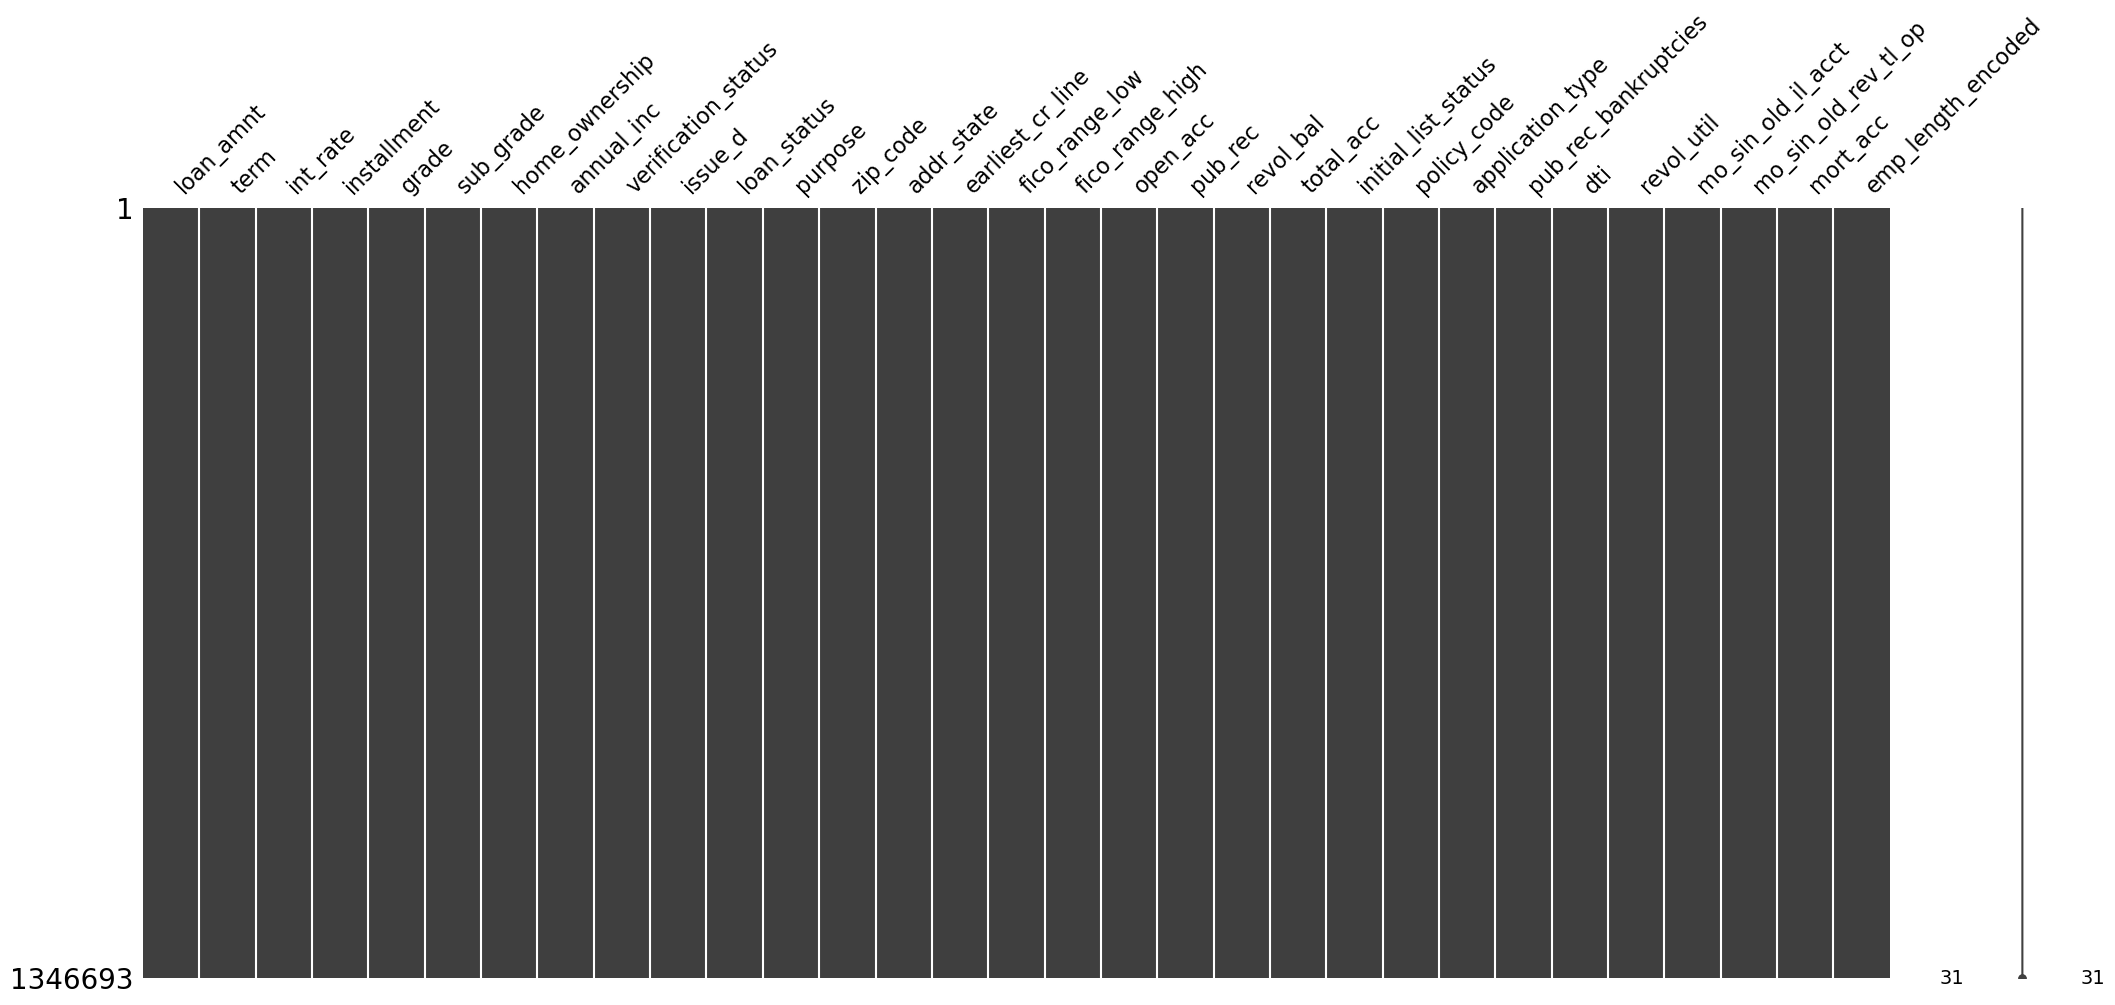

In [44]:
msno.matrix(df);

In [45]:
pd.DataFrame(df.dtypes).loc[pd.DataFrame(df.dtypes)[0] == 'object']

0
term                 object
grade                object
sub_grade            object
home_ownership       object
verification_status  object
issue_d              object
purpose              object
zip_code             object
addr_state           object
earliest_cr_line     object
initial_list_status  object
application_type     object

OUTLIERS

In [46]:
df.emp_length_encoded = df.emp_length_encoded.astype('object')

- Grade is embedded in sub grade. therefore we can drop grade

In [47]:
df = df.drop(columns = ['grade'])
df

loan_amnt term  int_rate  installment sub_grade home_ownership  \
0           3600.0   36     13.99       123.03        C4       MORTGAGE   
1          24700.0   36     11.99       820.28        C1       MORTGAGE   
2          20000.0   60     10.78       432.66        B4       MORTGAGE   
3          10400.0   60     22.45       289.91        F1       MORTGAGE   
4          11950.0   36     13.44       405.18        C3           RENT   
...            ...  ...       ...          ...       ...            ...   
1346688    18000.0   60      9.49       377.95        B2            OWN   
1346689    29400.0   60     13.99       683.94        C3       MORTGAGE   
1346690    32000.0   60     14.49       752.74        C4       MORTGAGE   
1346691    16000.0   60     12.79       362.34        C1           RENT   
1346692    24000.0   60     14.49       564.56        C4           RENT   

         annual_inc verification_status   issue_d  loan_status  ...  \
0           55000.0        Not Verified  Dec-2015            0  ...   
1           65000.0        Not Verified  Dec-2015            0  ...   
2           63000.0        Not Verified  Dec-2015            0  ...   
3          104433.0     Source Verified  Dec-2015            0  ...   
4           34000.0     Source Verified  Dec-2015            0  ...   
...             ...                 ...       ...          ...  ...   
1346688    130000.0        Not Verified  Oct-2016            0  ...   
1346689    180792.0        Not Verified  Oct-2016            0  ...   
1346690    157000.0     Source Verified  Oct-2016            1  ...   
1346691    150000.0        Not Verified  Oct-2016            0  ...   
1346692    110000.0        Not Verified  Oct-2016            1  ...   

        initial_list_status policy_code application_type pub_rec_bankruptcies  \
0                         w         1.0       Individual                  0.0   
1                         w         1.0       Individual                  0.0   
2                         w         1.0        Joint App                  0.0   
3                         w         1.0       Individual                  0.0   
4                         w         1.0       Individual                  0.0   
...                     ...         ...              ...                  ...   
1346688                   f         1.0       Individual                  0.0   
1346689                   f         1.0       Individual                  0.0   
1346690                   f         1.0       Individual                  0.0   
1346691                   f         1.0       Individual                  3.0   
1346692                   f         1.0       Individual                  1.0   

           dti  revol_util  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  \
0         5.91        29.7               148.0                 128.0   
1        16.06        19.2               113.0                 192.0   
2        10.78        56.2               125.0                 184.0   
3        25.37        64.5               128.0                 210.0   
4        10.20        68.4               338.0                  54.0   
...        ...         ...                 ...                   ...   
1346688  20.59        34.0               113.0                 146.0   
1346689  22.03        85.2               145.0                 174.0   
1346690  10.34        27.4                53.0                  63.0   
1346691  12.25        55.0               147.0                 229.0   
1346692  18.30        68.1               132.0                 206.0   

         mort_acc  emp_length_encoded  
0             1.0                11.0  
1             4.0                11.0  
2             5.0                11.0  
3             6.0                 4.0  
4             0.0                 5.0  
...           ...                 ...  
1346688       3.0                 6.0  
1346689       3.0                10.0  
1346690       3.0                 4.0  
1346691       0.0

- policy code variable only takes value of 1 or 2 so there is no distinct information. Action: drop

In [48]:
df = df.drop(columns = ['policy_code'])
df.shape

(1346693, 29)

In [49]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'initial_list_status', 'application_type',
       'pub_rec_bankruptcies', 'dti', 'revol_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'emp_length_encoded'],
      dtype='object')

- fico range high and low is highly correlated. therefore we'll create another variable that is the average of them and drop these two columns

In [50]:
df.loc[:, ['fico_range_high', 'fico_range_low']].corr()

fico_range_high  fico_range_low
fico_range_high              1.0             1.0
fico_range_low               1.0             1.0

In [51]:
df.loc[:, ['fico_range_high', 'fico_range_low']].head()

fico_range_high  fico_range_low
0            679.0           675.0
1            719.0           715.0
2            699.0           695.0
3            699.0           695.0
4            694.0           690.0

In [52]:
df['fico_score'] = (df['fico_range_high'] + df['fico_range_low'])/2
df = df.drop(columns=['fico_range_high', 'fico_range_low'])
pd.DataFrame(df['fico_score']).head()

fico_score
0       677.0
1       717.0
2       697.0
3       697.0
4       692.0

In [53]:
df.shape

(1346693, 28)

- issue_d also needs to be dropped because we need the variables before providing loans

In [54]:
df = df.drop(columns = ['issue_d'])
df.shape

(1346693, 27)

In [55]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status',
       'application_type', 'pub_rec_bankruptcies', 'dti', 'revol_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc',
       'emp_length_encoded', 'fico_score'],
      dtype='object')

LOAN AMOUNT

- It looks like the loans that are charged off have higher loan amount and the difference is statistically significant since the p-value is less than 0.5

In [56]:
def variable_plot(df, name, continuous):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (20, 3))

    if continuous:
        sns.distplot(df.loc[df[name].notnull(), name], kde = False, ax = ax1)
    else:
        sns.countplot(data = df, x = df[name], order = sorted(df[name].unique()), color = 'blue', ax = ax1)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    ax1.set_xlabel(name)
    ax1.set_ylabel('count')
    ax1.set_title(name)

    if continuous:
        sns.boxplot(x = name, y = df.loan_status.astype(str), data = df, ax = ax2)
        ax2.set_ylabel('')
        ax2.set_title(name + ' by loan_status')
    else:
        co_rates = df.groupby(name)['loan_status'].value_counts(normalize = True)[:, 1]
        sns.barplot(x = co_rates.index, y = co_rates.values, color = 'blue', ax = ax2)
        ax2.set_ylabel('co_rates')
        ax2.set_xlabel('co_rates by ' + name)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        ax2.set_title(name)
    
    if continuous:
        kde_plot = sns.FacetGrid(df, hue = 'loan_status', aspect= 4)
        kde_plot.map(sns.kdeplot, name, shade = True)
        kde_plot.add_legend()

    else:
        fig = plt.figure(figsize= (20,3))
        ax = sns.countplot(x = name, hue = 'loan_status', data = df, order = sorted(df[name].unique()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()

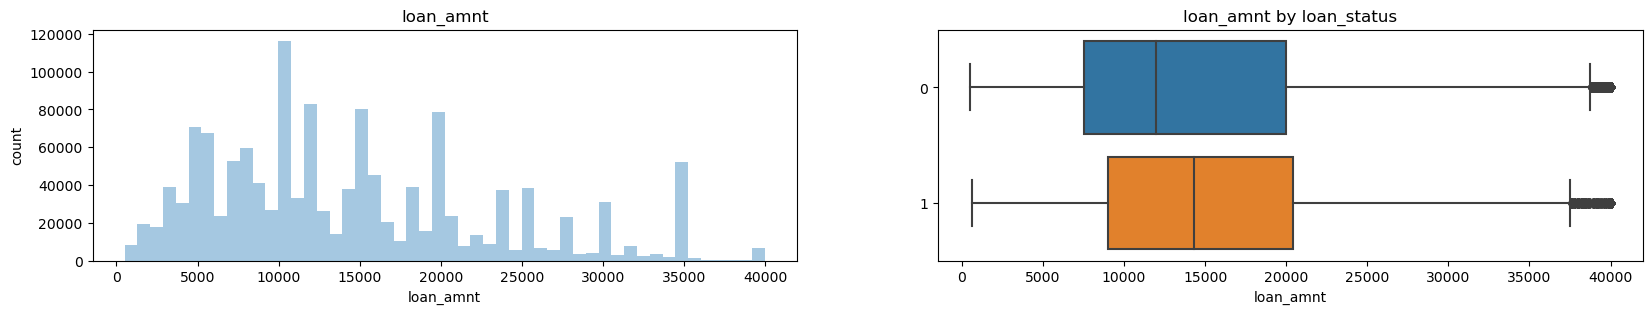

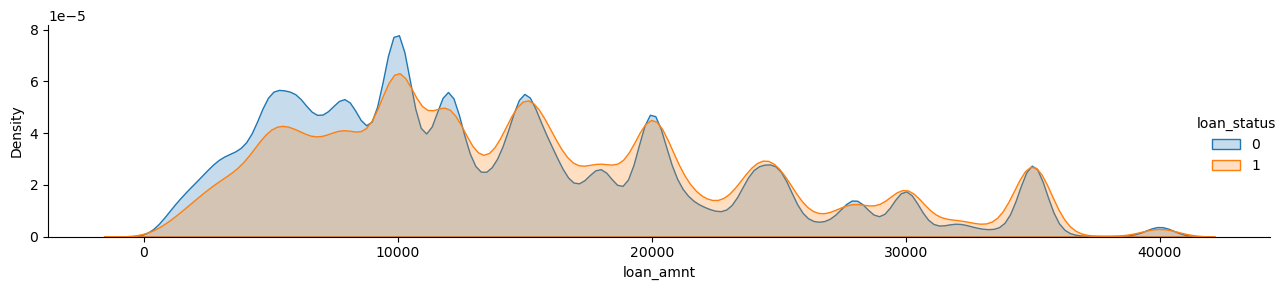

In [57]:
variable_plot(df, 'loan_amnt', continuous = True)

In [58]:
import scipy.stats as stats
t_stat, p_value = stats.ttest_ind(df[df['loan_status'] == 1]['loan_amnt'], df[df['loan_status'] == 0]['loan_amnt'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df[df['loan_status'] == 1]['loan_amnt'], df[df['loan_status'] == 0]['loan_amnt'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df[df['loan_status'] == 1]['loan_amnt'], df[df['loan_status'] == 0]['loan_amnt'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

In [59]:
q3, q1 = np.percentile(df['loan_amnt'], (75, 25))
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
print(upper_bound)

38000.0


In [60]:
upper_bound

38000.0

In [61]:
w1, w2 = np.percentile(df['loan_amnt'], (99.00, 99.46))
print(w1, upper_bound, w2)

35000.0 38000.0 38000.0


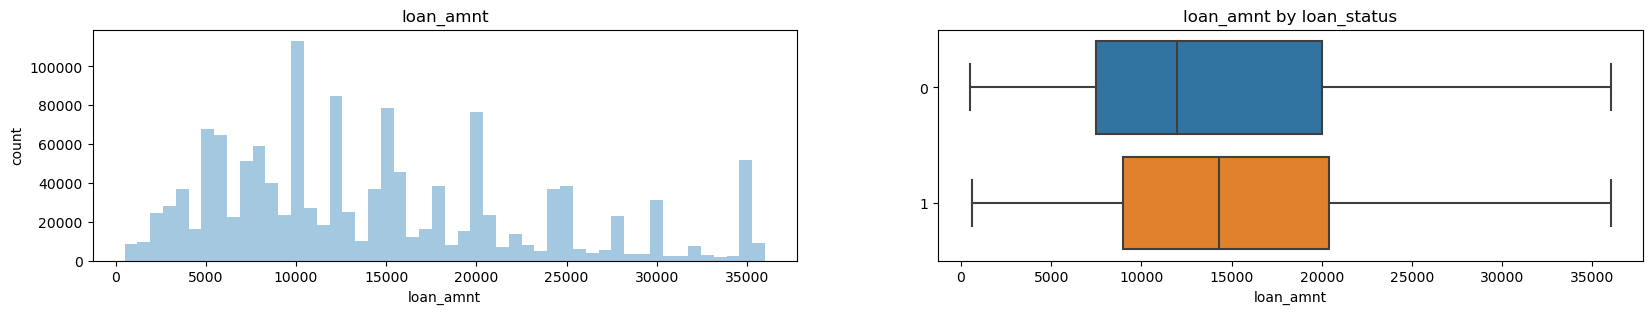

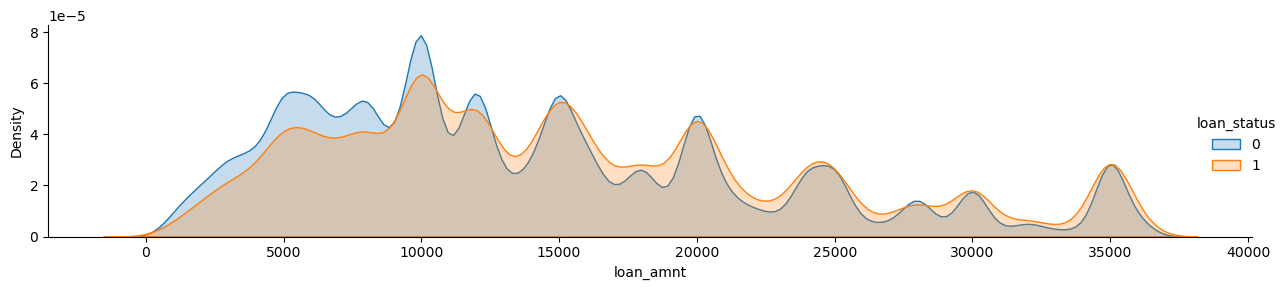

In [62]:
from scipy.stats.mstats import winsorize
df2 = df.copy()
df2['loan_amnt'] = winsorize(df2['loan_amnt'], limits=[0, 0.0060])
variable_plot(df2, 'loan_amnt', continuous = True)

In [63]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['loan_amnt'], df2[df2['loan_status'] == 0]['loan_amnt'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['loan_amnt'], df2[df2['loan_status'] == 0]['loan_amnt'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['loan_amnt'], df2[df2['loan_status'] == 0]['loan_amnt'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

TERM

- It looks like when the term increases, the rate of the loan that turned charged off increases even though the amount of loans with longer terms is smaller

- Also when we look at the graph we see that the loans with longer terms have higher ratio of turning charged off.

- Its information value is around 0.17 which is moderate.

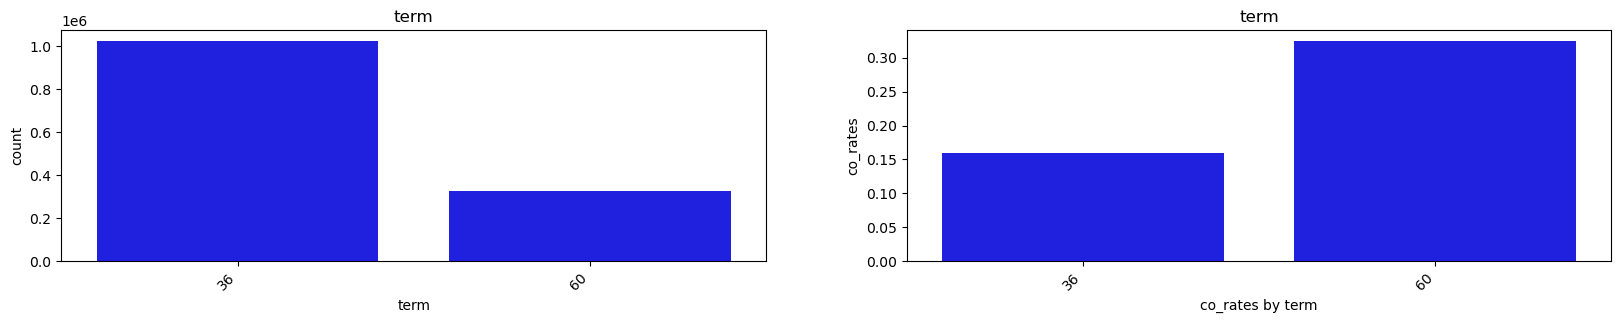

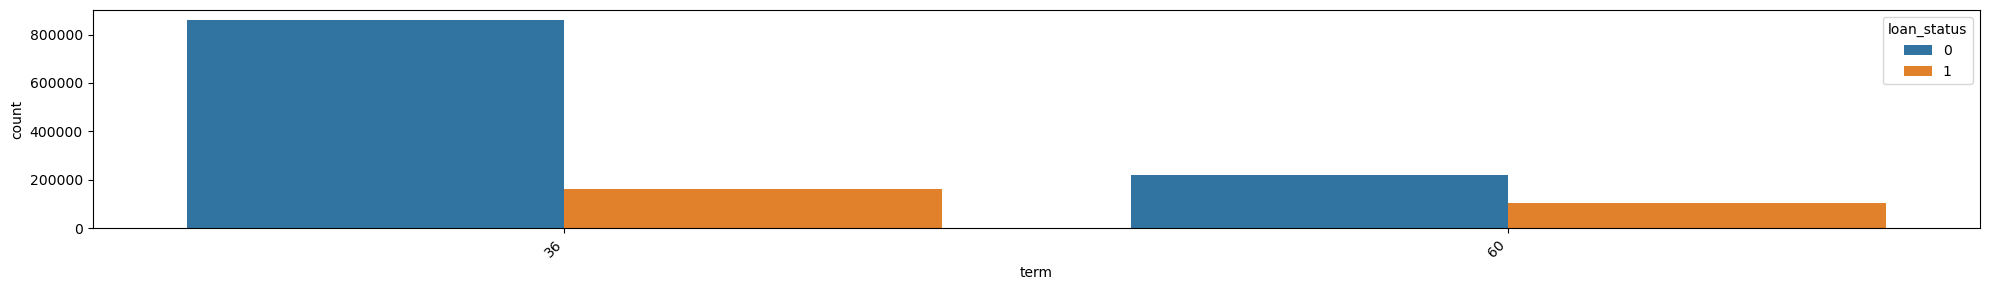

In [64]:
variable_plot(df, 'term', continuous = False)

In [65]:
feature,target = 'term','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status         0         1       woe        iv
term                                               
36           0.796365  0.608087 -0.269739  0.174053
60           0.203635  0.391913  0.654709  0.174053

In [66]:
pd.crosstab(df[df['loan_status'] == 0]['term'], df[df['loan_status'] == 1]['term'])

Empty DataFrame
Columns: []
Index: []

In [67]:
from scipy.stats import chi2_contingency
chii = df.copy()
chii['term2'] = chii['term'].astype('category')
contingency_table = pd.crosstab(chii['term2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

0.0


INTEREST RATE

- Higher the interest rate higher the possibility of the loan becomes charged off

- Even though there is outliers, its distribution seems alright. therefore, no action will be taken.

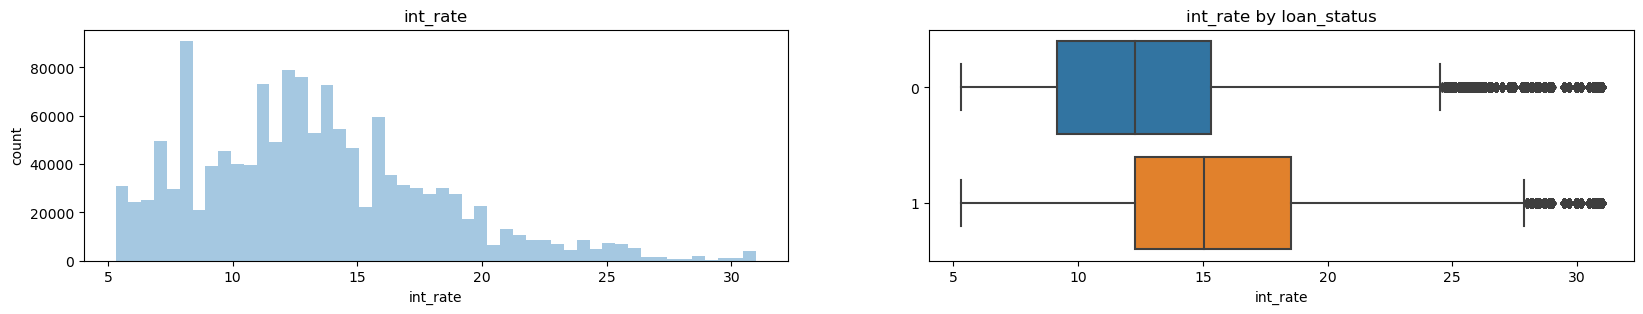

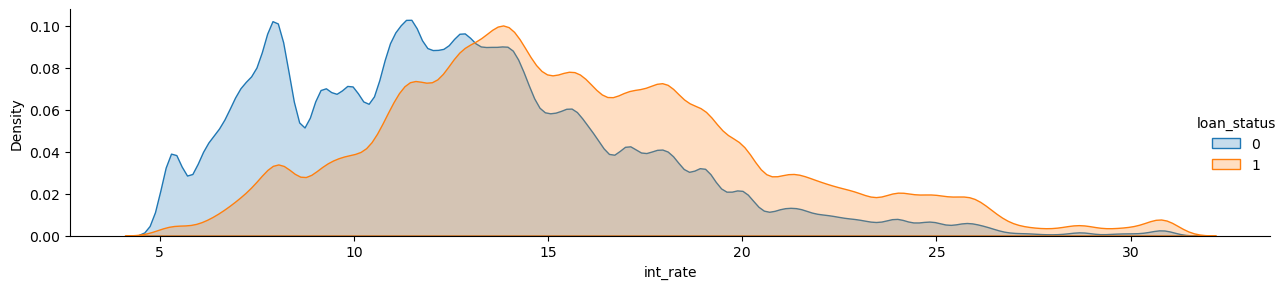

In [68]:
variable_plot(df2, 'int_rate', continuous=True)

In [69]:
df2.groupby('loan_status')['int_rate'].describe()

count       mean       std   min    25%    50%    75%    max
loan_status                                                                  
0            1077707.0  12.626777  4.526256  5.31   9.17  12.29  15.31  30.99
1             268986.0  15.710970  4.907081  5.31  12.29  15.05  18.55  30.99

In [70]:
df2.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status',
       'application_type', 'pub_rec_bankruptcies', 'dti', 'revol_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc',
       'emp_length_encoded', 'fico_score'],
      dtype='object')

In [71]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['int_rate'], df2[df2['loan_status'] == 0]['int_rate'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['int_rate'], df2[df2['loan_status'] == 0]['int_rate'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['int_rate'], df2[df2['loan_status'] == 0]['int_rate'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

INSTALLMENT

- p-value is significant which indicates distributions are statistically different from charged off and fully paid

- Installment looks like it has a tail therefore let's apply square root transformation to deal with outliers and look at the statistical significance again

In [72]:
pd.DataFrame(df2.loc[:, ['installment', 'loan_status']]).head()

installment  loan_status
0       123.03            0
1       820.28            0
2       432.66            0
3       289.91            0
4       405.18            0

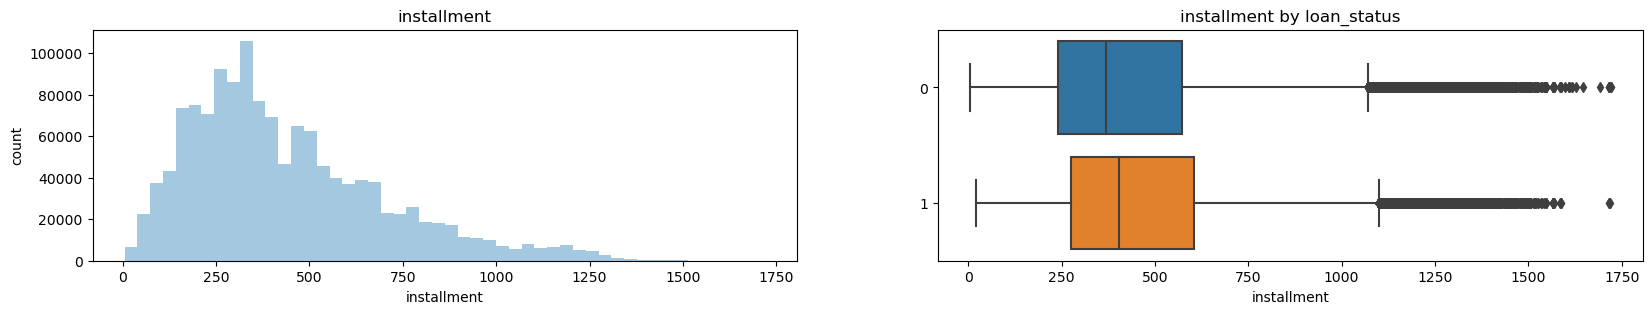

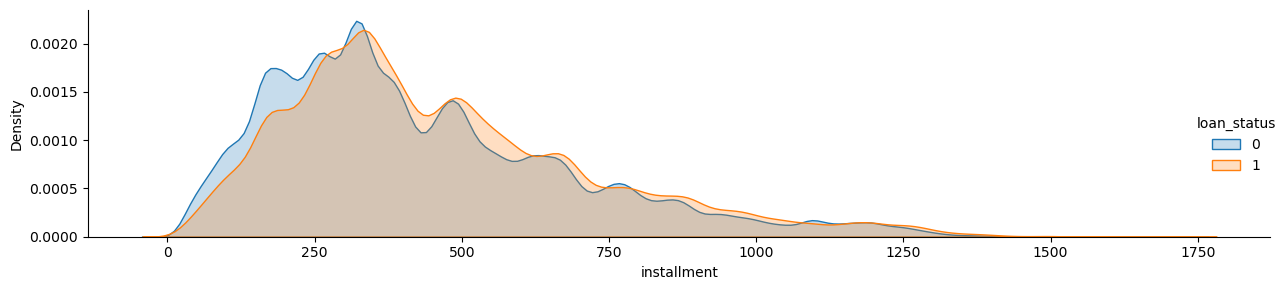

In [73]:
variable_plot(df2, 'installment', continuous=True)

In [74]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['installment'], df2[df2['loan_status'] == 0]['installment'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['installment'], df2[df2['loan_status'] == 0]['installment'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['installment'], df2[df2['loan_status'] == 0]['installment'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

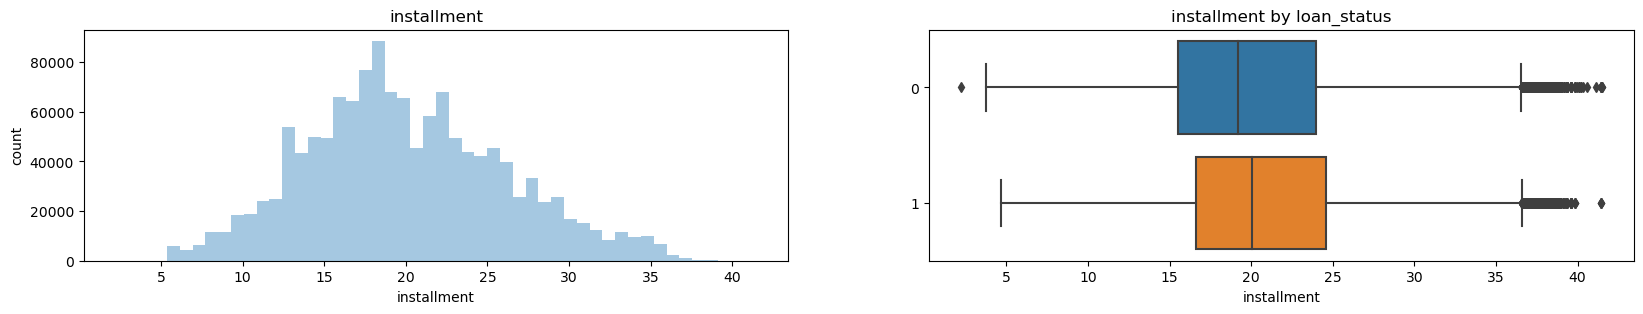

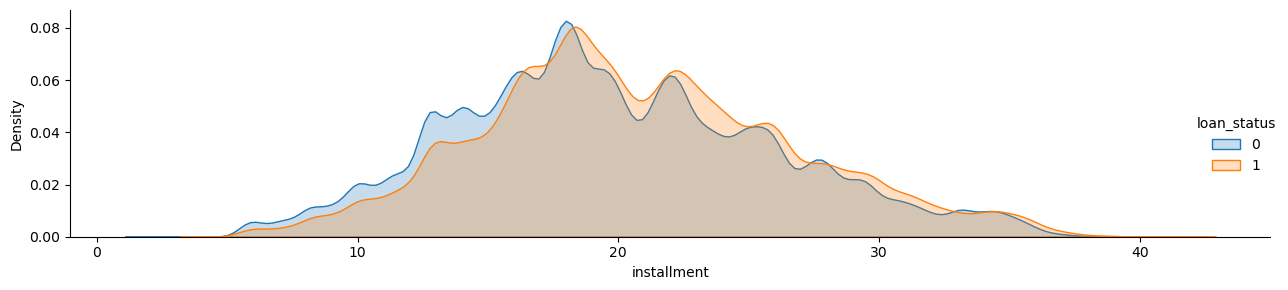

In [75]:
df2.installment = np.sqrt(df2.installment)
variable_plot(df2, 'installment', continuous=True)

In [76]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['installment'], df2[df2['loan_status'] == 0]['installment'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['installment'], df2[df2['loan_status'] == 0]['installment'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['installment'], df2[df2['loan_status'] == 0]['installment'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

SUB GRADE

- The ratio of charged off among loans increases when the quality of a loan decreases.

- As we can see from the information value of 0.49 that this is a good variable

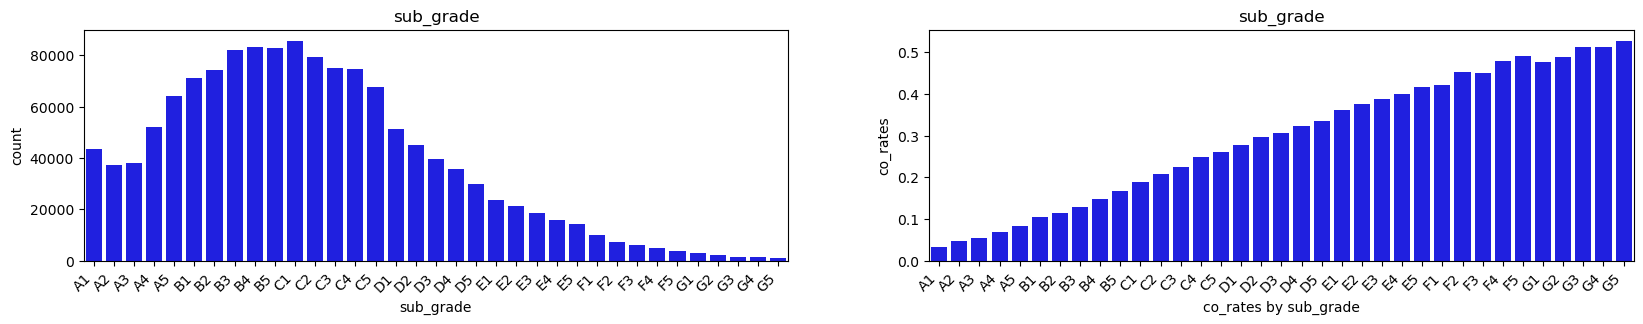

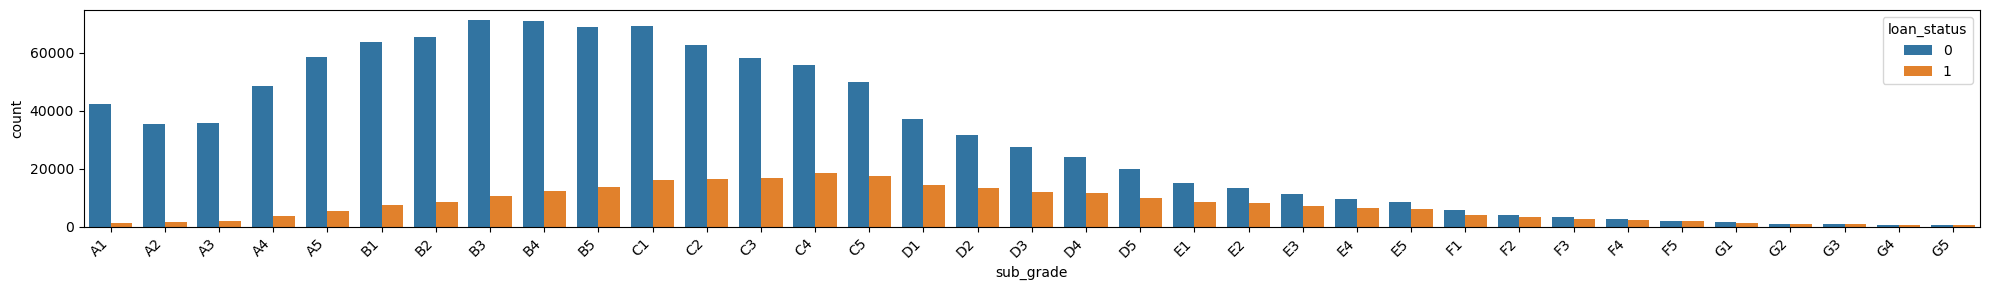

In [77]:
variable_plot(df2, 'sub_grade', continuous=False)

In [78]:
feature,target = 'sub_grade','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status         0         1       woe       iv
sub_grade                                         
A1           0.039213  0.005234 -2.013739  0.49568
A2           0.032865  0.006446 -1.628886  0.49568
A3           0.033289  0.007770 -1.454973  0.49568
A4           0.045128  0.013332 -1.219374  0.49568
A5           0.054403  0.020005 -1.000458  0.49568
B1           0.059133  0.027593 -0.762244  0.49568
B2           0.060882  0.031258 -0.666659  0.49568
B3           0.066082  0.039515 -0.514214  0.49568
B4           0.065761  0.045895 -0.359679  0.49568
B5           0.063814  0.051289 -0.218501  0.49568
C1           0.064312  0.060356 -0.063488  0.49568
C2           0.058328  0.061111  0.046601  0.49568
C3           0.053961  0.062873  0.152860  0.49568
C4           0.051900  0.068996  0.284732  0.49568
C5           0.046425  0.065364  0.342124  0.49568
D1           0.034429  0.053137  0.433977  0.49568
D2           0.029362  0.049441  0.521072  0.49568
D3           0.025408  0.044731  0.565615  0.49568
D4           0.022383  0.042898  0.650540  0.49568
D5           0.018529  0.037262  0.698633  0.49568
E1           0.014141  0.031927  0.814374  0.49568
E2           0.012448  0.029923  0.877106  0.49568
E3           0.010507  0.026563  0.927420  0.49568
E4           0.008763  0.023499  0.986429  0.49568
E5           0.007821  0.022421  1.053166  0.49568
F1           0.005362  0.015722  1.075666  0.49568
F2           0.003674  0.012160  1.196783  0.49568
F3           0.003122  0.010235  1.187195  0.49568
F4           0.002361  0.008696  1.303917  0.49568
F5           0.001873  0.007238  1.351619  0.49568
G1           0.001466  0.005365  1.297231  0.49568
G2           0.001021  0.003915  1.344265  0.49568
G3           0.000739  0.003108  1.436961  0.49568
G4           0.000588  0.002469  1.434165  0.49568
G5           0.000504  0.002253  1.497702  0.49568

In [79]:
from scipy.stats import chi2_contingency
chii = df2.copy()
chii['sub_grade2'] = chii['sub_grade'].astype('category')
contingency_table = pd.crosstab(chii['sub_grade2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

0.0


HOME OWNERSHIP

- When we look at this variable we see that charged off rates are similar in each group even though the total amount differentiates in each group.

- Information value is really small. therefore, this might not be a good variable. However, we will look at the results of feature selection as well before deciding to remove the variable

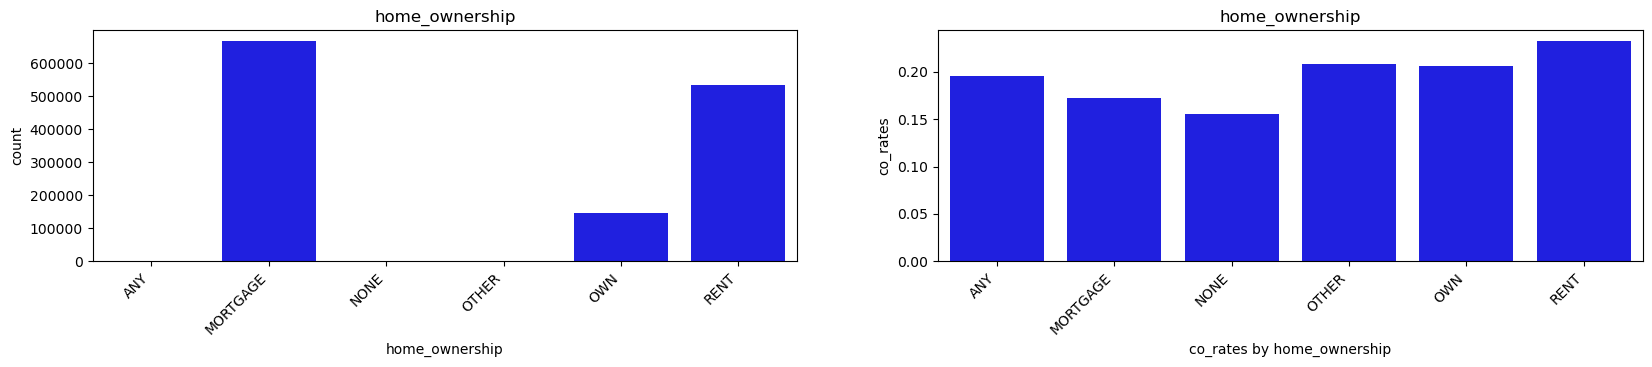

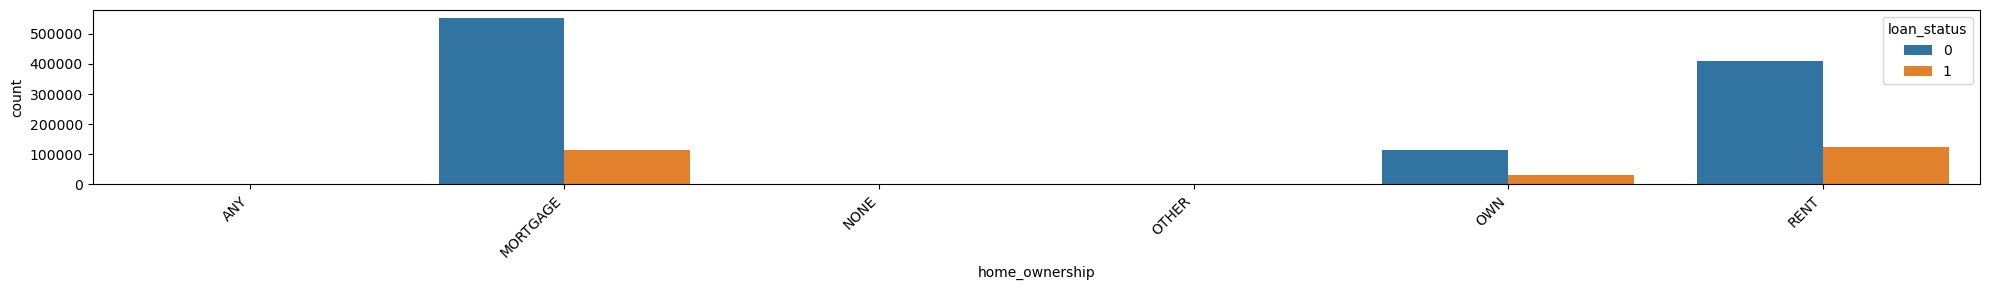

In [80]:
variable_plot(df2, 'home_ownership', continuous=False)

In [81]:
feature,target = 'home_ownership','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status            0         1       woe        iv
home_ownership                                        
ANY             0.000213  0.000208 -0.024796  0.031304
MORTGAGE        0.511849  0.426565 -0.182265  0.031304
NONE            0.000035  0.000026 -0.303744  0.031304
OTHER           0.000134  0.000141  0.055704  0.031304
OWN             0.106727  0.111102  0.040182  0.031304
RENT            0.381042  0.461957  0.192562  0.031304

In [82]:
from scipy.stats import chi2_contingency
chii = df.copy()
chii['home_ownership2'] = chii['home_ownership'].astype('category')
contingency_table = pd.crosstab(chii['home_ownership2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

0.0


In [83]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status',
       'application_type', 'pub_rec_bankruptcies', 'dti', 'revol_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc',
       'emp_length_encoded', 'fico_score'],
      dtype='object')

ANNUAL INC

- Delete the observations with annual income is zero

- There is long tail.therefore we will try log transformation first to see that we can deal with the outliers. we will not try to remove all of them. Our main goal is to mitigate the effect of outliers rather than removing them completely.

- Based on p-value, we can say that the distributions of fully paid is different than charged off

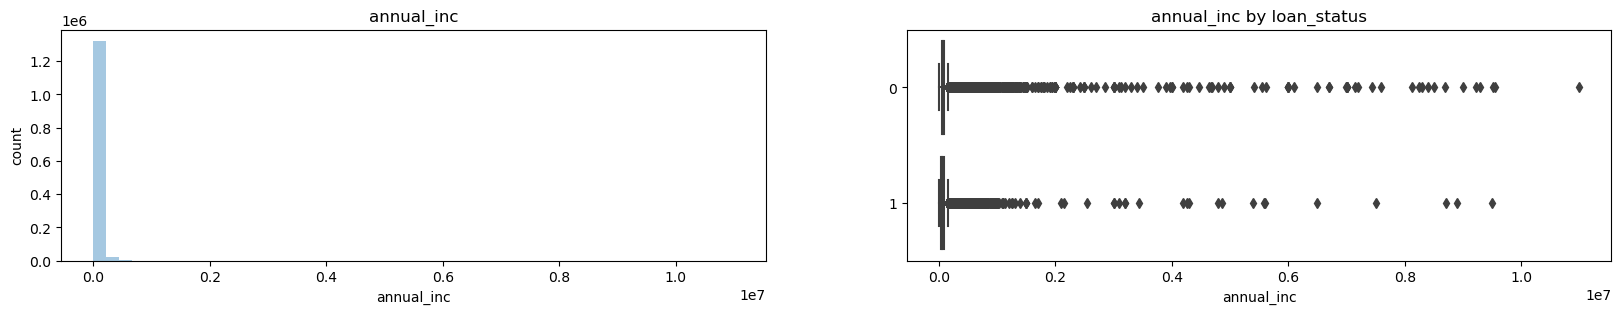

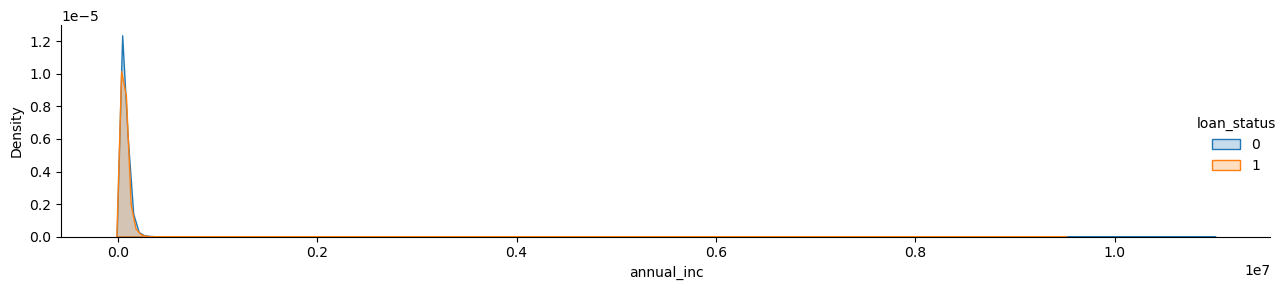

In [84]:
variable_plot(df2, 'annual_inc', continuous=True)

In [85]:
df2.loc[df2.annual_inc == df2.annual_inc.min()].groupby(by = 'loan_status').count()

loan_amnt  term  int_rate  installment  sub_grade  \
loan_status                                                      
0                  293   293       293          293        293   
1                   68    68        68           68         68   

             home_ownership  annual_inc  verification_status  purpose  \
loan_status                                                             
0                       293         293                  293      293   
1                        68          68                   68       68   

             zip_code  ...  initial_list_status  application_type  \
loan_status            ...                                          
0                 293  ...                  293               293   
1                  68  ...                   68                68   

             pub_rec_bankruptcies  dti  revol_util  mo_sin_old_il_acct  \
loan_status                                                              
0                             293  293         293                 293   
1                              68   68          68                  68   

             mo_sin_old_rev_tl_op  mort_acc  emp_length_encoded  fico_score  
loan_status                                                                  
0                             293       293                 293         293  
1                              68        68                  68          68  

[2 rows x 26 columns]

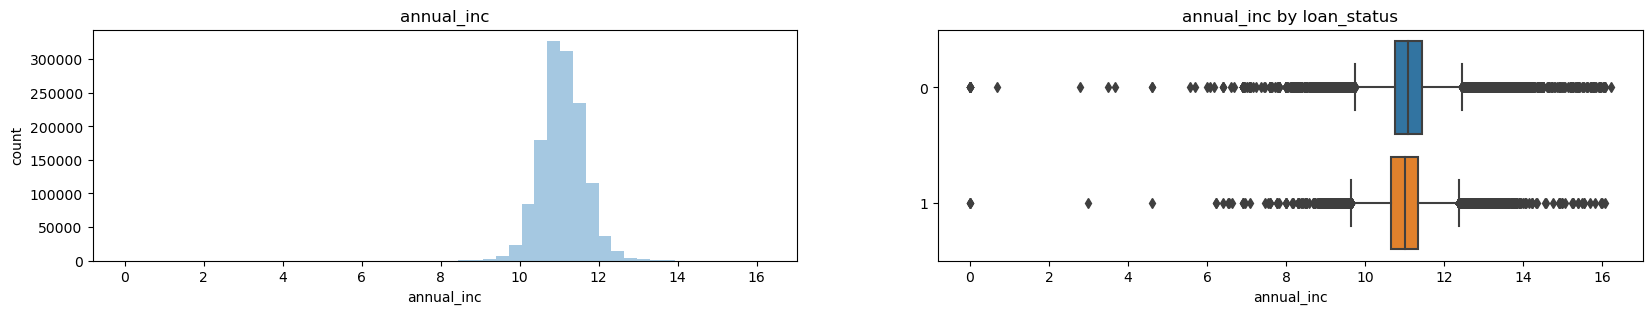

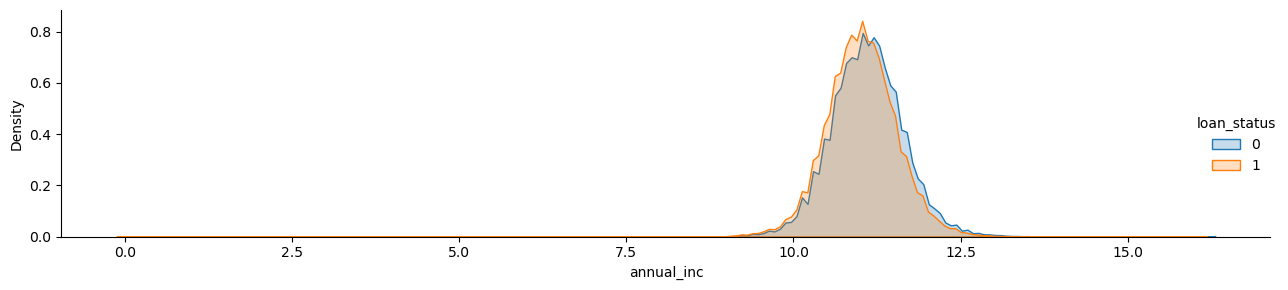

In [86]:
del_index3 = df2.loc[df.annual_inc == 0].index
df2 = df2.drop(index = del_index3)
df2.annual_inc = np.log(df2.annual_inc)
variable_plot(df2, 'annual_inc', continuous=True)

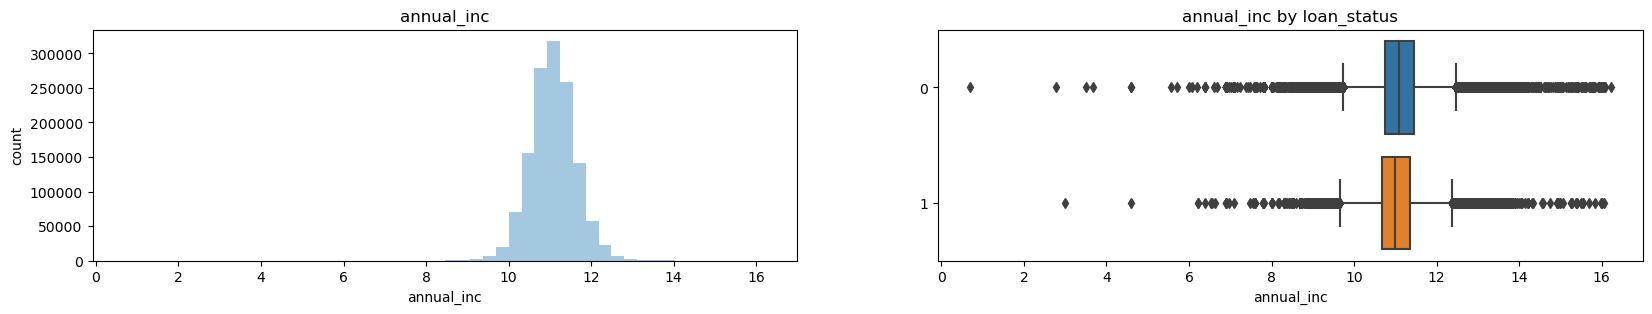

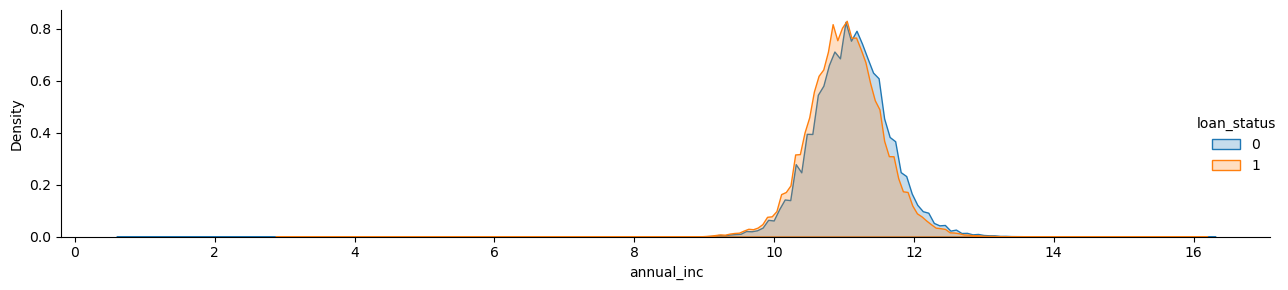

In [87]:
del_index4 = df2.loc[df2.annual_inc <= 0].index
df2 = df2.drop(index = del_index4)
variable_plot(df2, 'annual_inc', continuous=True)

In [88]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['annual_inc'], df2[df2['loan_status'] == 0]['annual_inc'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['annual_inc'], df2[df2['loan_status'] == 0]['annual_inc'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['annual_inc'], df2[df2['loan_status'] == 0]['annual_inc'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

In [89]:
df3 = df2.copy()
df3.loc[(df3.annual_inc <= 9) | (df3.annual_inc >= 13)].groupby(by = 'loan_status').count()

loan_amnt  term  int_rate  installment  sub_grade  \
loan_status                                                      
0                 2929  2929      2929         2929       2929   
1                  446   446       446          446        446   

             home_ownership  annual_inc  verification_status  purpose  \
loan_status                                                             
0                      2929        2929                 2929     2929   
1                       446         446                  446      446   

             zip_code  ...  initial_list_status  application_type  \
loan_status            ...                                          
0                2929  ...                 2929              2929   
1                 446  ...                  446               446   

             pub_rec_bankruptcies   dti  revol_util  mo_sin_old_il_acct  \
loan_status                                                               
0                            2929  2929        2929                2929   
1                             446   446         446                 446   

             mo_sin_old_rev_tl_op  mort_acc  emp_length_encoded  fico_score  
loan_status                                                                  
0                            2929      2929                2929        2929  
1                             446       446                 446         446  

[2 rows x 26 columns]

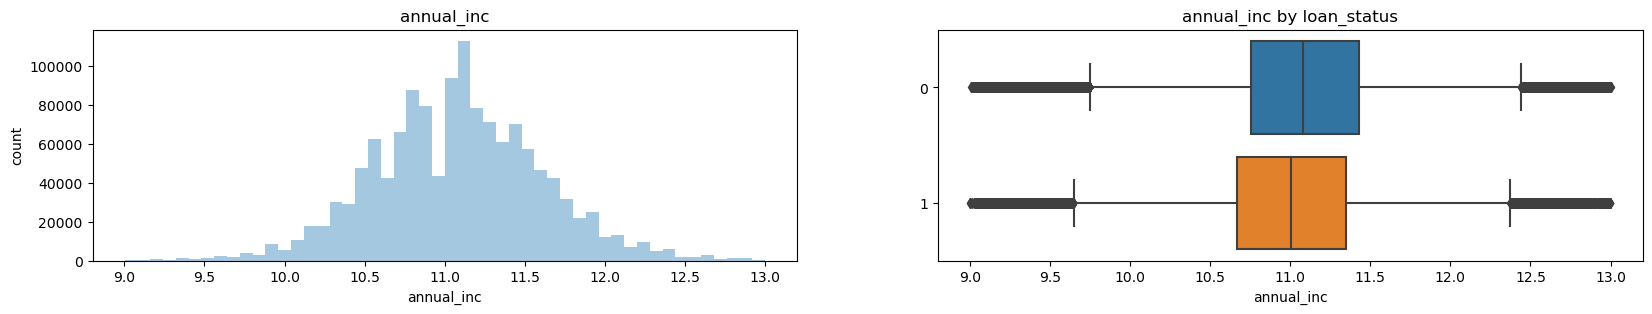

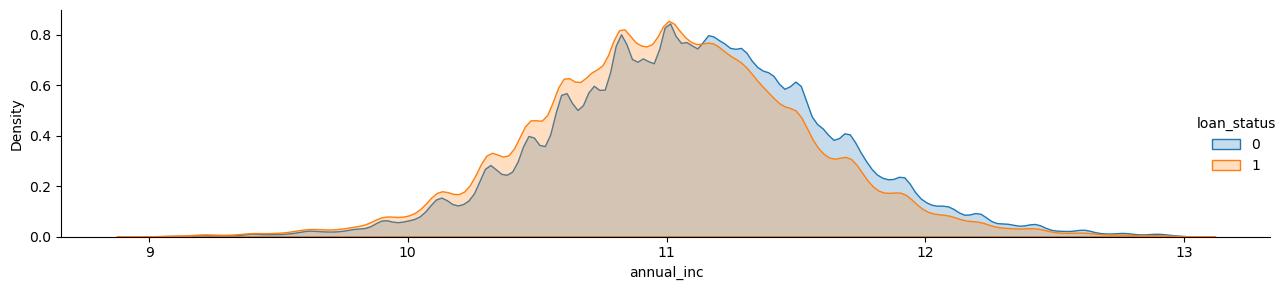

In [90]:
del_index5 = df2.loc[(df2.annual_inc <= 9) | (df2.annual_inc >= 13)].index
df2 = df2.drop(index = del_index5)
variable_plot(df2, 'annual_inc', continuous=True)

In [91]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['annual_inc'], df2[df2['loan_status'] == 0]['annual_inc'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['annual_inc'], df2[df2['loan_status'] == 0]['annual_inc'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['annual_inc'], df2[df2['loan_status'] == 0]['annual_inc'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

verification_status

- Verified loans have higher charged off rate


- Its information value is very low so this looks like not a good variable. however, we will keep it at the moment


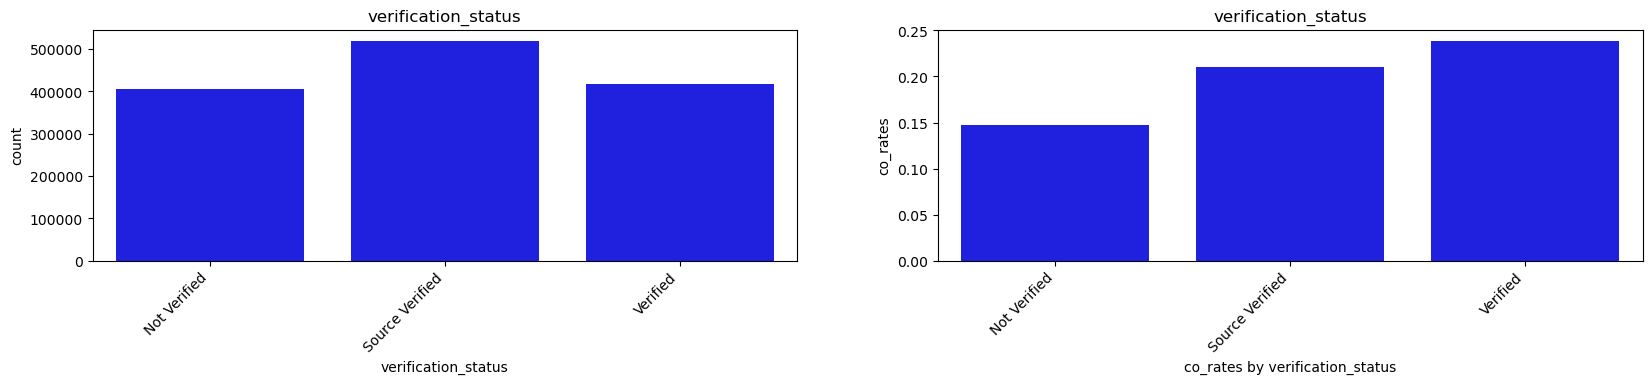

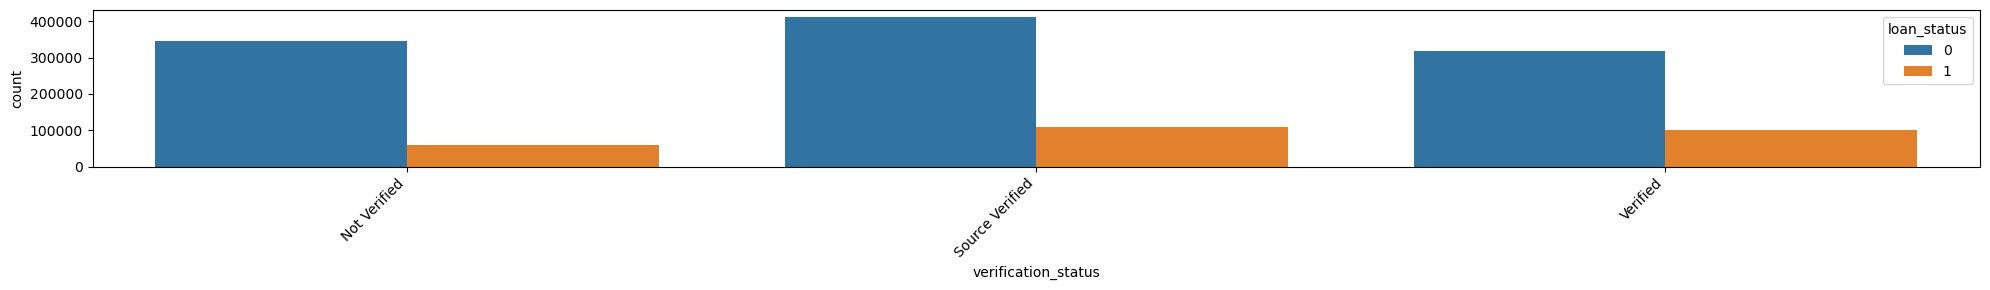

In [92]:
variable_plot(df2, 'verification_status', continuous=False)

In [93]:
feature,target = 'verification_status','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status                 0         1       woe        iv
verification_status                                        
Not Verified         0.321915  0.221947 -0.371847  0.055993
Source Verified      0.382290  0.406311  0.060941  0.055993
Verified             0.295795  0.371741  0.228530  0.055993

In [94]:
from scipy.stats import chi2_contingency
chii = df.copy()
chii['verification_status2'] = chii['verification_status'].astype('category')
contingency_table = pd.crosstab(chii['verification_status2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

0.0


In [95]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status',
       'application_type', 'pub_rec_bankruptcies', 'dti', 'revol_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc',
       'emp_length_encoded', 'fico_score'],
      dtype='object')

PURPOSE

- Small business tends to have higher charged off rates even though the total amount of loans given with that purpose is low.

- Information value is not that good. however we will kepp the variable atm.

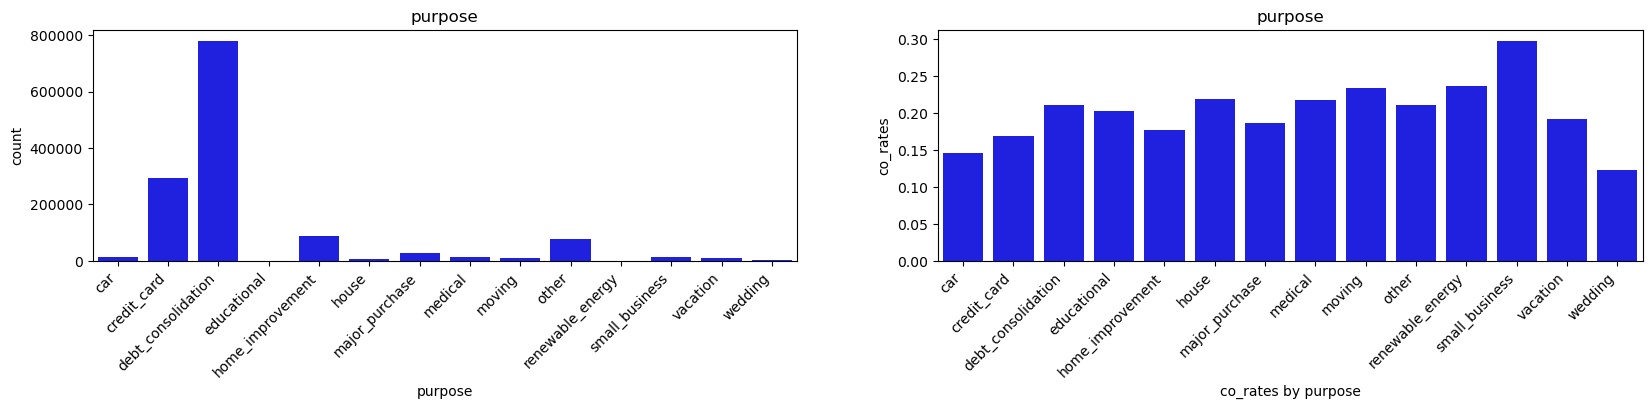

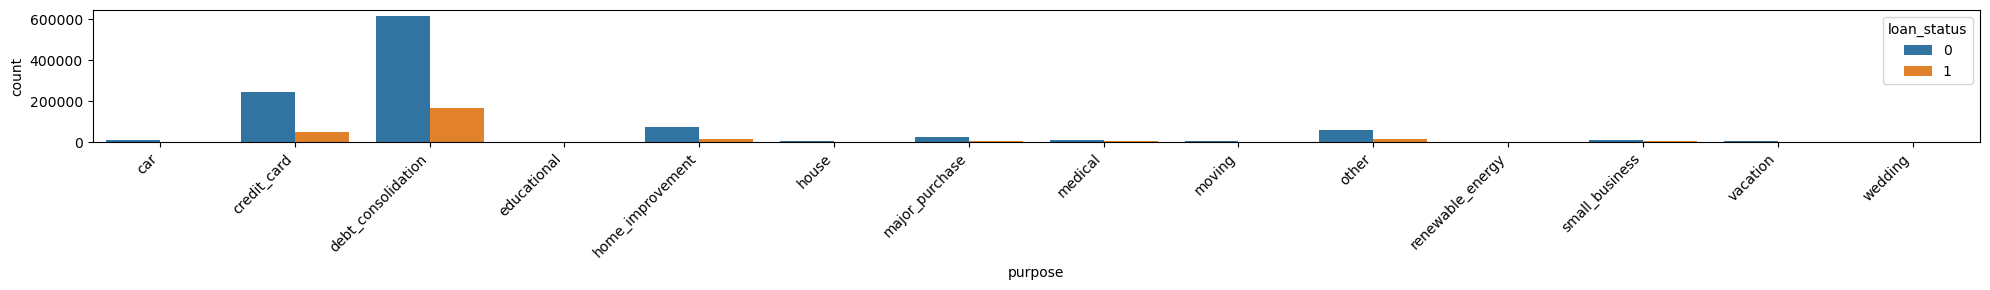

In [96]:
variable_plot(df2, 'purpose', continuous=False)

In [97]:
feature,target = 'purpose','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status                0         1       woe        iv
purpose                                                   
car                 0.011576  0.007960 -0.374500  0.019361
credit_card         0.227820  0.186044 -0.202573  0.019361
debt_consolidation  0.571634  0.614231  0.071872  0.019361
educational         0.000266  0.000272  0.021321  0.019361
home_improvement    0.066615  0.057742 -0.142938  0.019361
house               0.005264  0.005934  0.119755  0.019361
major_purchase      0.022260  0.020386 -0.087951  0.019361
medical             0.011309  0.012638  0.111156  0.019361
moving              0.006749  0.008247  0.200376  0.019361
other               0.057107  0.061124  0.067986  0.019361
renewable_energy    0.000660  0.000823  0.221160  0.019361
small_business      0.010037  0.017052  0.530052  0.019361
vacation            0.006810  0.006481 -0.049462  0.019361
wedding             0.001894  0.001065 -0.575406  0.019361

In [98]:
from scipy.stats import chi2_contingency
chii = df.copy()
chii['purpose2'] = chii['purpose'].astype('category')
contingency_table = pd.crosstab(chii['purpose2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

0.0


ZIP CODE

- There are too many unique values to deal with therefore this variable is going to be dropped.

- We will utilise addr_state instead of zip code which has less unique values and is more manageable

In [99]:
df2 = df2.drop(columns=['zip_code'])

ADDRESS STATE

- California has the highest amount of loans that is provided.

- Idaho has the highest charged off rate based on the loans that were given even though the state is one of the lowest amount of loans that were given

- Its information value is very low but we'll keep it atm

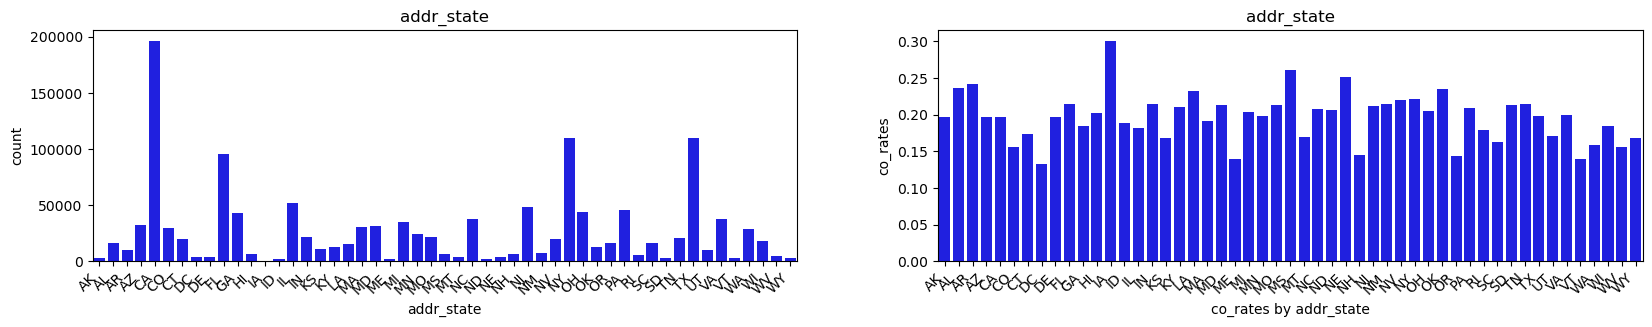

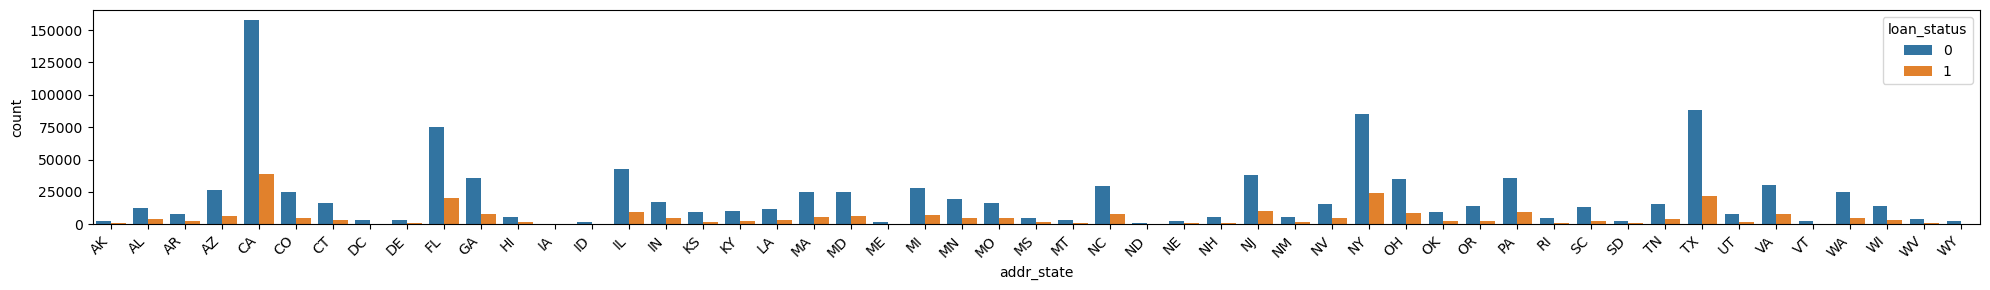

In [100]:
variable_plot(df2, 'addr_state', continuous=False)

In [101]:
feature,target = 'addr_state','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status         0         1       woe        iv
addr_state                                         
AK           0.002385  0.002332 -0.022730  0.016419
AL           0.011800  0.014624  0.214527  0.016419
AR           0.007090  0.009018  0.240520  0.016419
AZ           0.024404  0.023891 -0.021263  0.016419
CA           0.146682  0.143473 -0.022120  0.016419
CO           0.023267  0.017138 -0.305749  0.016419
CT           0.015101  0.012731 -0.170706  0.016419
DC           0.002797  0.001713 -0.489953  0.016419
DE           0.002837  0.002775 -0.022004  0.016419
FL           0.069747  0.076430  0.091490  0.016419
GA           0.032890  0.029709 -0.101697  0.016419
HI           0.005014  0.005092  0.015483  0.016419
IA           0.000007  0.000011  0.539555  0.016419
ID           0.001267  0.001173 -0.076549  0.016419
IL           0.039376  0.034924 -0.119994  0.016419
IN           0.015837  0.017313  0.089136  0.016419
KS           0.008700  0.007018 -0.214912  0.016419
KY           0.009433  0.010057  0.064110  0.016419
LA           0.011062  0.013372  0.189644  0.016419
MA           0.023273  0.021995 -0.056463  0.016419
MD           0.022834  0.024796  0.082421  0.016419
ME           0.001620  0.001047 -0.437007  0.016419
MI           0.026122  0.026659  0.020349  0.016419
MN           0.017885  0.017644 -0.013538  0.016419
MO           0.015562  0.016873  0.080909  0.016419
MS           0.004525  0.006399  0.346564  0.016419
MT           0.002959  0.002410 -0.205123  0.016419
NC           0.027754  0.029184  0.050241  0.016419
ND           0.001179  0.001222  0.035459  0.016419
NE           0.002491  0.003349  0.295684  0.016419
NH           0.005120  0.003490 -0.383149  0.016419
NJ           0.035439  0.038075  0.071759  0.016419
NM           0.005372  0.005852  0.085547  0.016419
NV           0.014686  0.016542  0.118989  0.016419
NY           0.079380  0.090074  0.126381  0.016419
OH           0.032423  0.033505  0.032813  0.016419
OK           0.008737  0.010735  0.205905  0.016419
OR           0.013051  0.008791 -0.395184  0.016419
PA           0.033543  0.035337  0.052118  0.016419
RI           0.004484  0.003911 -0.136716  0.016419
SC           0.012430  0.009670 -0.251141  0.016419
SD           0.002022  0.002198  0.083111  0.016419
TN           0.014873  0.016225  0.087007  0.016419
TX           0.082029  0.081287 -0.009086  0.016419
UT           0.007720  0.006362 -0.193477  0.016419
VA           0.028283  0.028238 -0.001583  0.016419
VT           0.002122  0.001378 -0.431575  0.016419
WA           0.022843  0.017153 -0.286472  0.016419
WI           0.013446  0.012162 -0.100374  0.016419
WV           0.003836  0.002820 -0.307878  0.016419
WY           0.002262  0.001825 -0.214388  0.016419

In [102]:
from scipy.stats import chi2_contingency
chii = df.copy()
chii['addr_state2'] = chii['addr_state'].astype('category')
contingency_table = pd.crosstab(chii['addr_state2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

0.0


In [103]:
df2.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'initial_list_status', 'application_type',
       'pub_rec_bankruptcies', 'dti', 'revol_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'emp_length_encoded', 'fico_score'],
      dtype='object')

EARLIEST CR LINE

- We turn this variable into numerical by its distance to today.

- Based on the initial distribution, we'll try log transformation to deal with outliers.

- There are still tails in our variable on both sides. however, it is better in terms of the magnitude of outliers.

In [104]:
from datetime import datetime

df2.earliest_cr_line = pd.to_datetime(df2.earliest_cr_line)

dttoday = datetime.now().strftime('%Y-%m-%d')
df2.earliest_cr_line = df2.earliest_cr_line.apply(lambda x:(np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

df2.earliest_cr_line.shape

(1342945,)

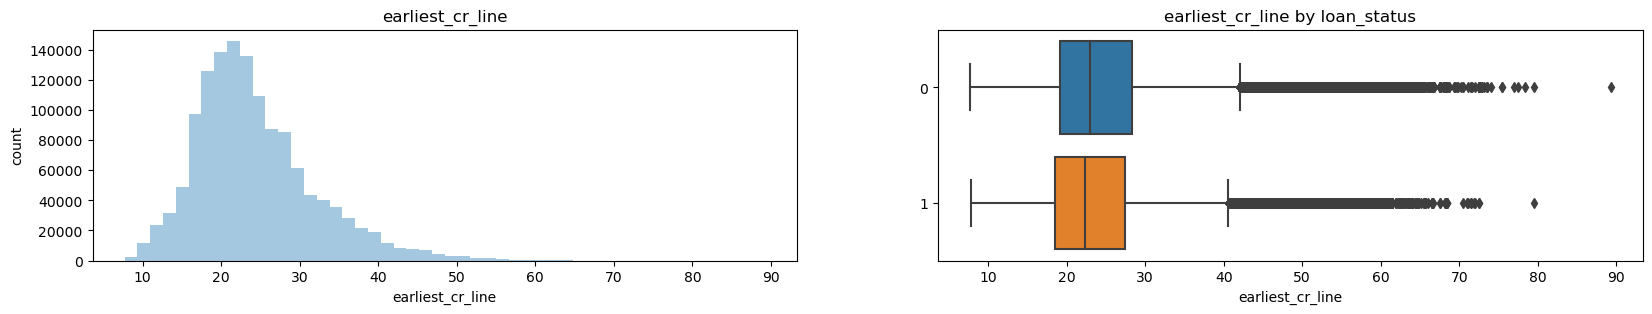

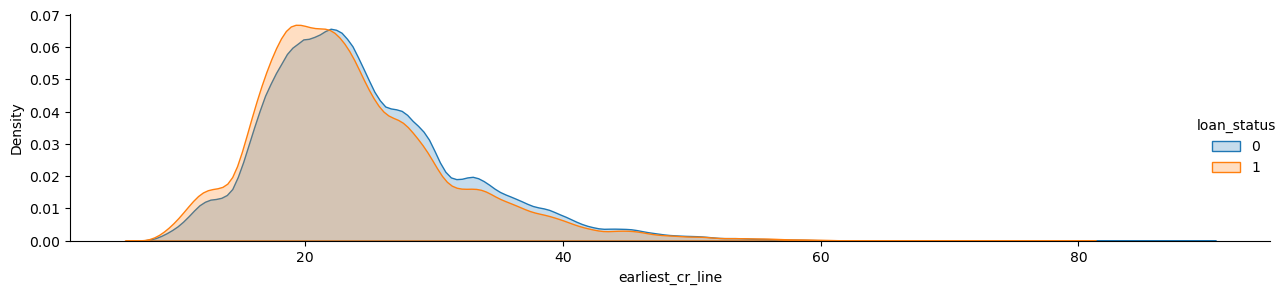

In [105]:
variable_plot(df2, 'earliest_cr_line', continuous=True)

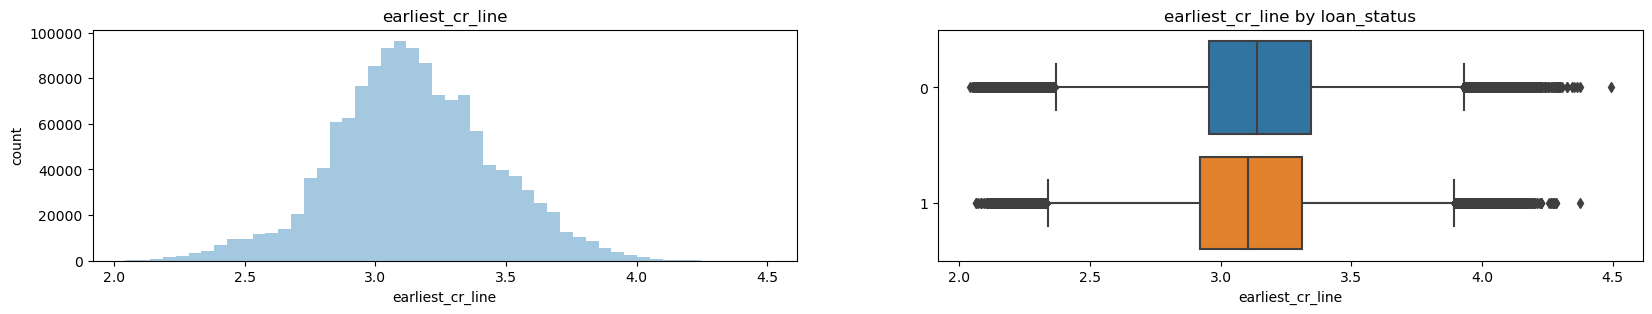

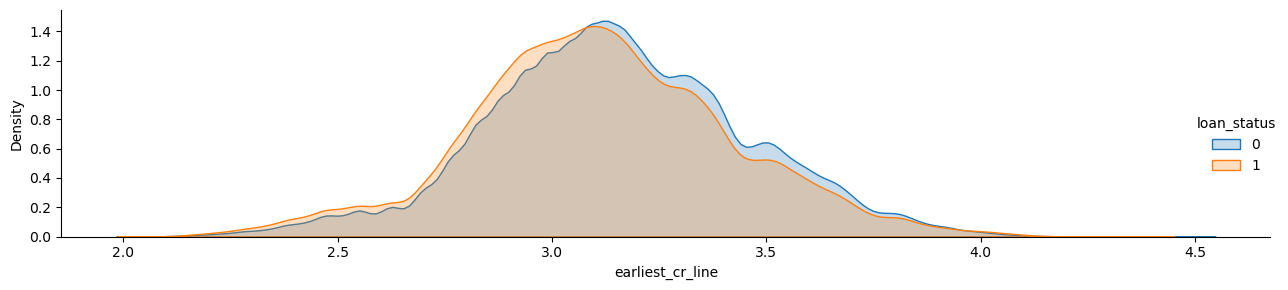

In [106]:
df2.earliest_cr_line = np.log(df2.earliest_cr_line)
variable_plot(df2, 'earliest_cr_line', continuous=True)

In [107]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['earliest_cr_line'], df2[df2['loan_status'] == 0]['earliest_cr_line'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['earliest_cr_line'], df2[df2['loan_status'] == 0]['earliest_cr_line'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['earliest_cr_line'], df2[df2['loan_status'] == 0]['earliest_cr_line'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

OPEN ACC

- We will keep this variable as it is now

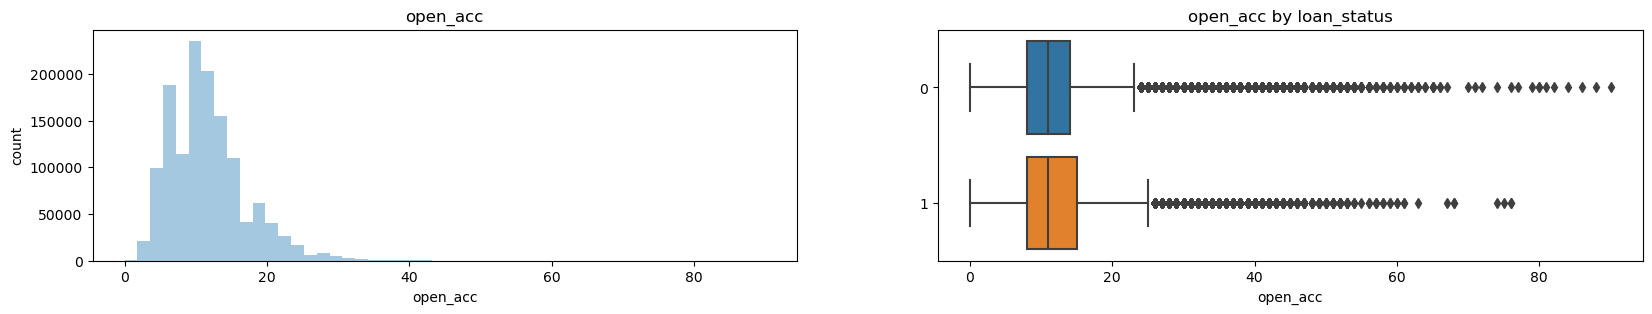

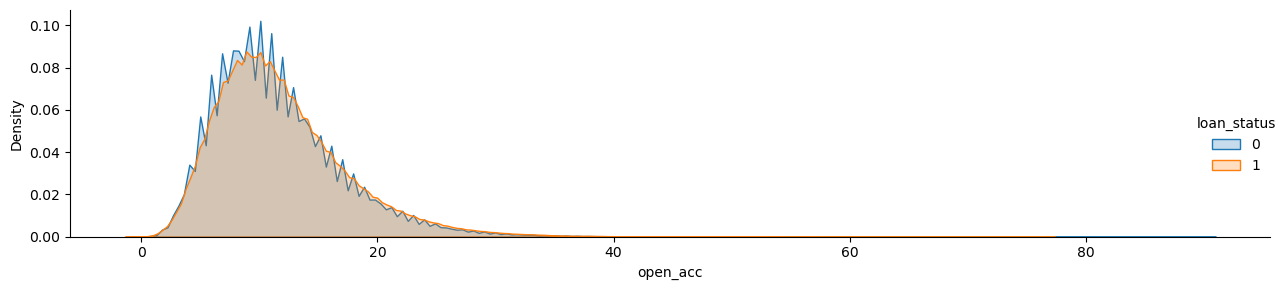

In [108]:
variable_plot(df2, 'open_acc', continuous=True)

In [109]:
df2.open_acc.describe()

count    1.342945e+06
mean     1.159025e+01
std      5.470933e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      9.000000e+01
Name: open_acc, dtype: float64

In [110]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['open_acc'], df2[df2['loan_status'] == 0]['open_acc'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['open_acc'], df2[df2['loan_status'] == 0]['open_acc'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['open_acc'], df2[df2['loan_status'] == 0]['open_acc'])
p_value, p_value2, p_value3

(5.264411612973085e-223, 1.4433354808919415e-221, 5.350970339947149e-160)

In [111]:
df2.groupby('loan_status')['open_acc'].describe()

count       mean       std  min  25%   50%   75%   max
loan_status                                                            
0            1074476.0  11.513279  5.426434  0.0  8.0  11.0  14.0  90.0
1             268469.0  11.898294  5.635013  0.0  8.0  11.0  15.0  76.0

In [112]:
df2.loc[(df2.open_acc >= 30)].groupby(by = 'loan_status').count()

loan_amnt  term  int_rate  installment  sub_grade  \
loan_status                                                      
0                 9233  9233      9233         9233       9233   
1                 2931  2931      2931         2931       2931   

             home_ownership  annual_inc  verification_status  purpose  \
loan_status                                                             
0                      9233        9233                 9233     9233   
1                      2931        2931                 2931     2931   

             addr_state  ...  initial_list_status  application_type  \
loan_status              ...                                          
0                  9233  ...                 9233              9233   
1                  2931  ...                 2931              2931   

             pub_rec_bankruptcies   dti  revol_util  mo_sin_old_il_acct  \
loan_status                                                               
0                            9233  9233        9233                9233   
1                            2931  2931        2931                2931   

             mo_sin_old_rev_tl_op  mort_acc  emp_length_encoded  fico_score  
loan_status                                                                  
0                            9233      9233                9233        9233  
1                            2931      2931                2931        2931  

[2 rows x 25 columns]

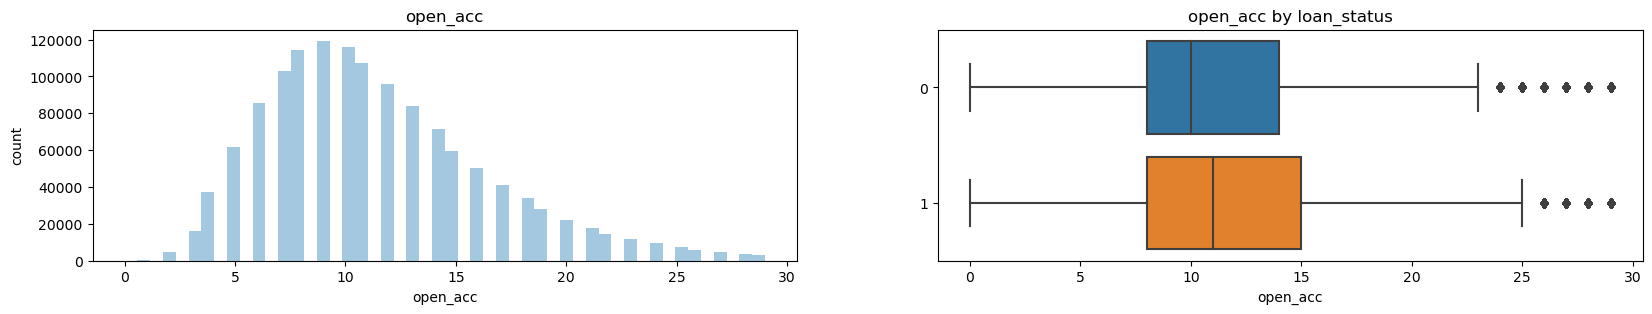

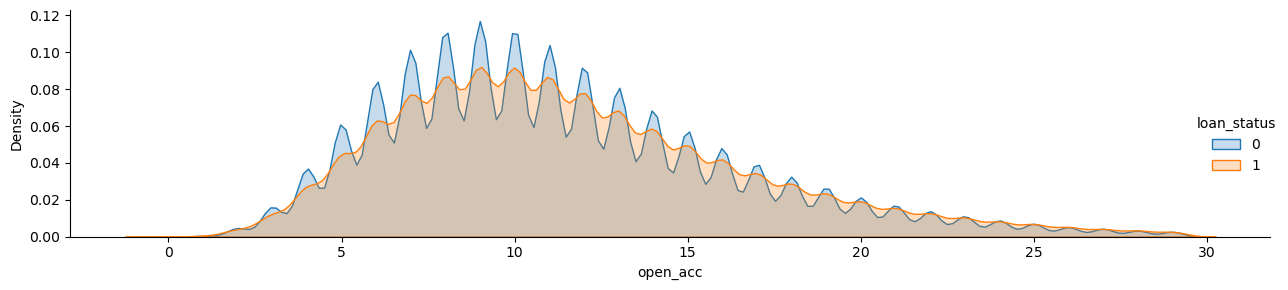

In [113]:
del_index7 = df2.loc[(df2.open_acc >= 30)].index
df2 = df2.drop(index = del_index7)
variable_plot(df2, 'open_acc', continuous=True)

In [114]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['open_acc'], df2[df2['loan_status'] == 0]['open_acc'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['open_acc'], df2[df2['loan_status'] == 0]['open_acc'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['open_acc'], df2[df2['loan_status'] == 0]['open_acc'])
p_value, p_value2, p_value3

(6.122198166613152e-200, 3.6725032553021207e-202, 3.101061586584499e-149)

In [115]:
df2.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
addr_state              0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
total_acc               0
initial_list_status     0
application_type        0
pub_rec_bankruptcies    0
dti                     0
revol_util              0
mo_sin_old_il_acct      0
mo_sin_old_rev_tl_op    0
mort_acc                0
emp_length_encoded      0
fico_score              0
dtype: int64

PUB REC

- Let's group if the number of public records is greater than 2 in 2

- IV is not good but we'll keep it

In [116]:
df.loc[:, ['pub_rec', 'pub_rec_bankruptcies']].corr()

pub_rec  pub_rec_bankruptcies
pub_rec               1.000000              0.649725
pub_rec_bankruptcies  0.649725              1.000000

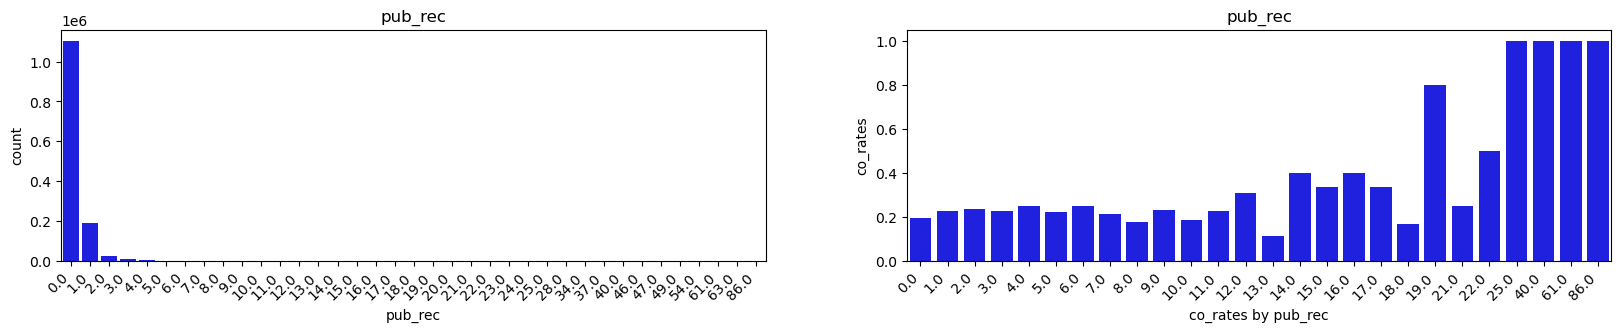

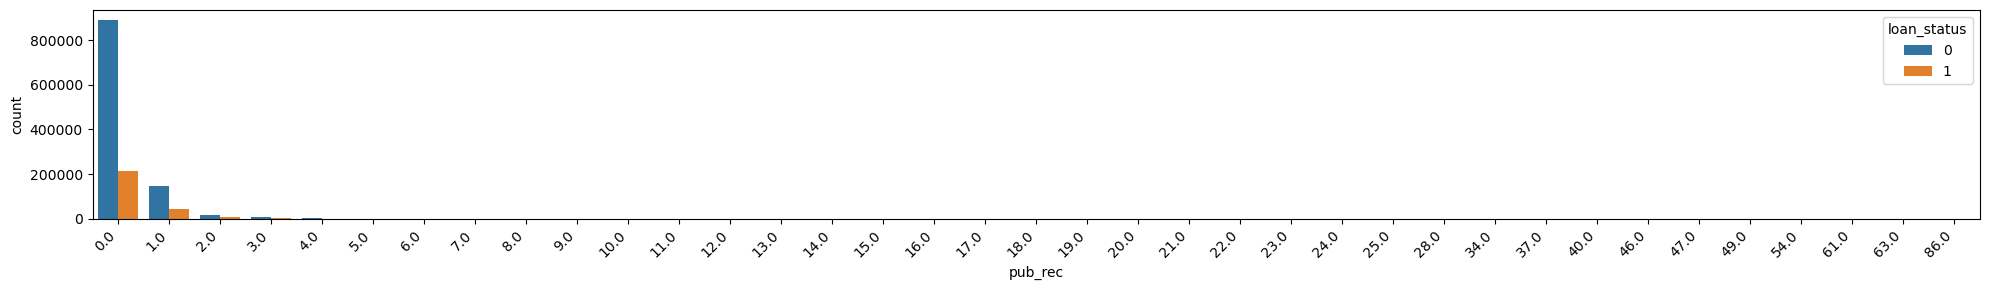

In [117]:
variable_plot(df2, 'pub_rec', continuous=False)

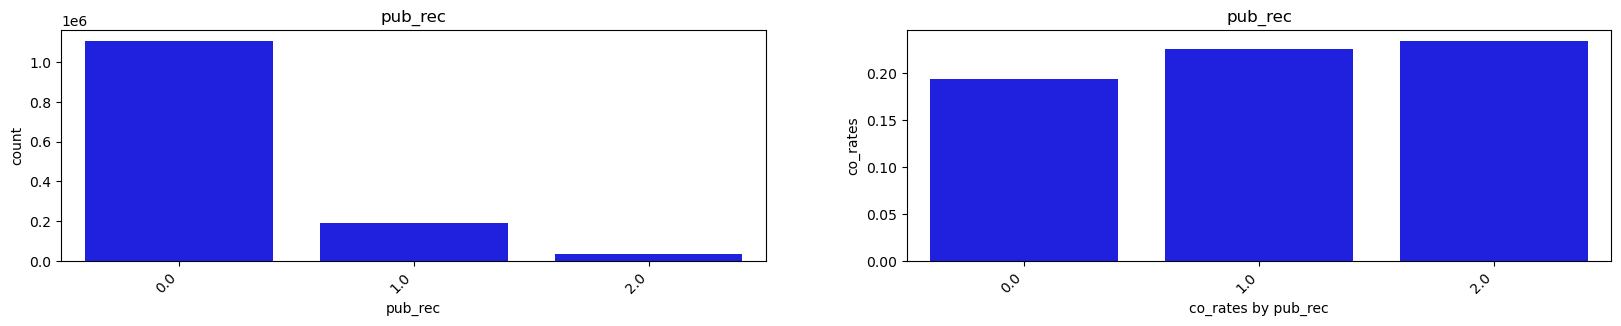

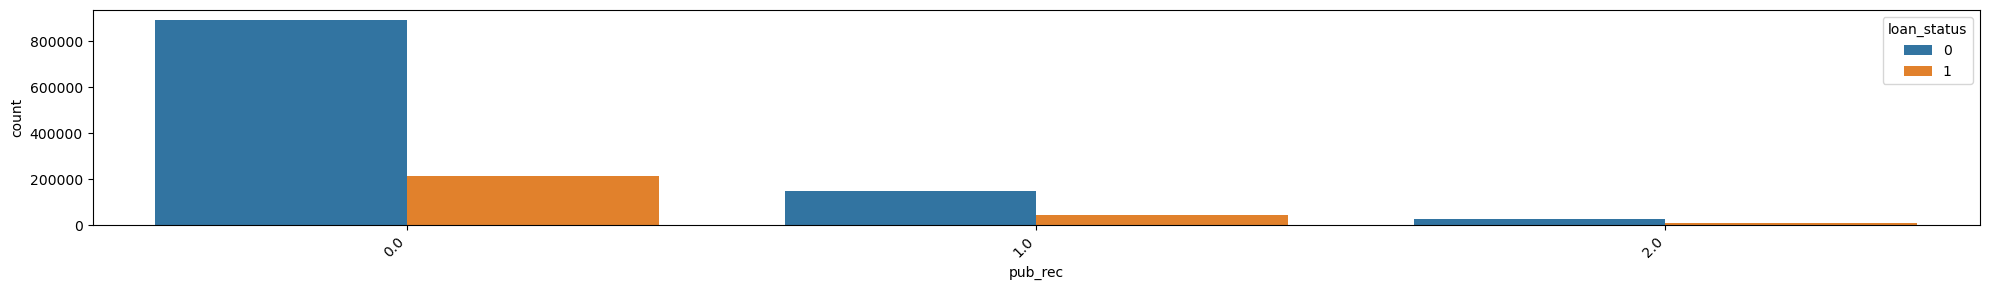

In [118]:
df2.pub_rec = df2.pub_rec.map(lambda x: 2 if x >1.0 else x)
variable_plot(df2, 'pub_rec', continuous = False)

In [119]:
df2.groupby('loan_status')['pub_rec'].describe()

count      mean       std  min  25%  50%  75%  max
loan_status                                                        
0            1065243.0  0.190146  0.454647  0.0  0.0  0.0  0.0  2.0
1             265538.0  0.225520  0.489298  0.0  0.0  0.0  0.0  2.0

In [120]:
feature,target = 'pub_rec','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status         0         1       woe        iv
pub_rec                                            
0.0          0.836210  0.806856 -0.035734  0.005946
1.0          0.137433  0.160768  0.156822  0.005946
2.0          0.026356  0.032376  0.205698  0.005946

In [121]:
from scipy.stats import chi2_contingency
chii = df.copy()
chii['pub_rec2'] = chii['pub_rec'].astype('category')
contingency_table = pd.crosstab(chii['pub_rec2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

9.762450805153143e-272


pub_rec_bankruptcies    

- Not a good variable but we grouped them and kept it for feature selection

- After we group them we see that the corr between pub_rec and pub_rec_bankruptcies is over 0.75. therefore we can drop one of them

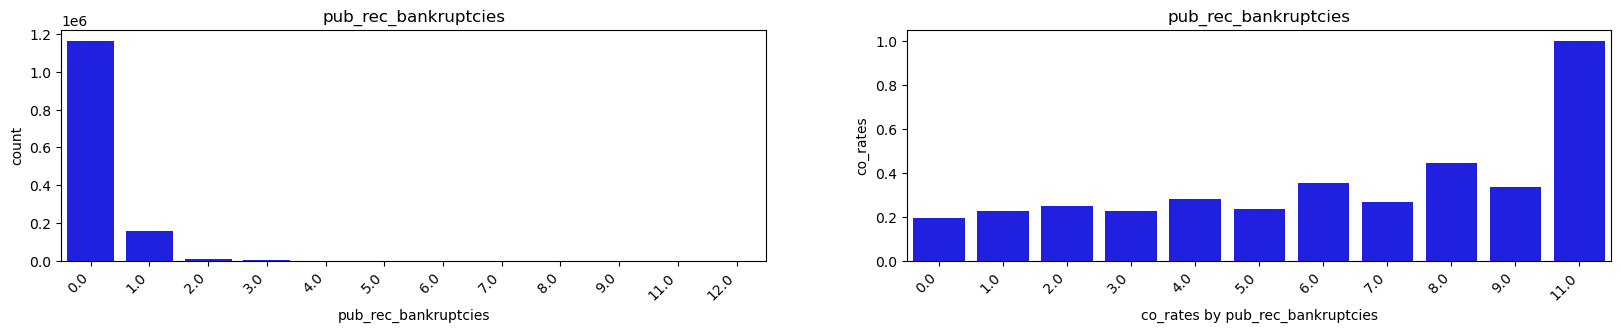

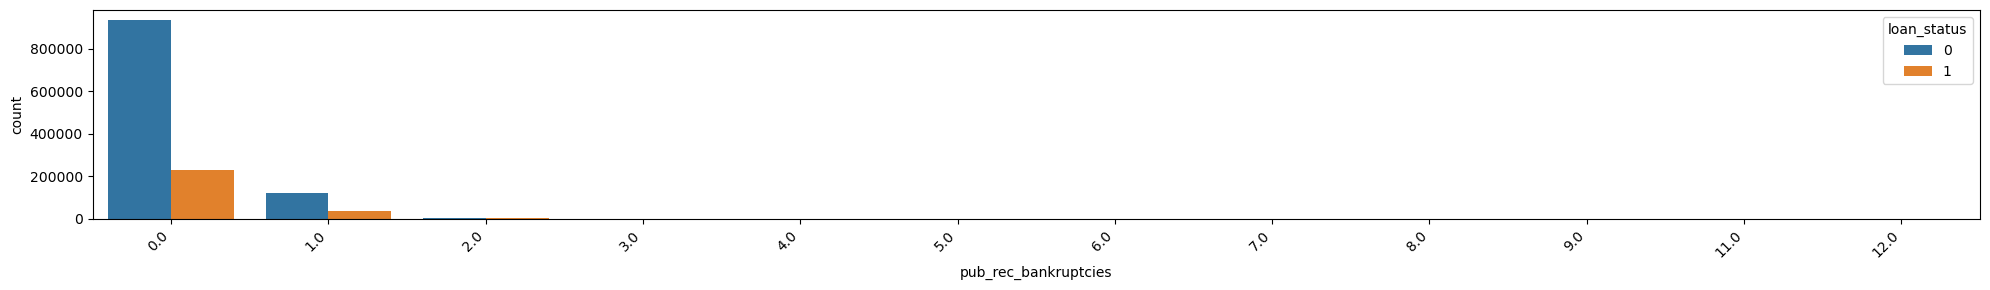

In [122]:
variable_plot(df2, 'pub_rec_bankruptcies', continuous=False)

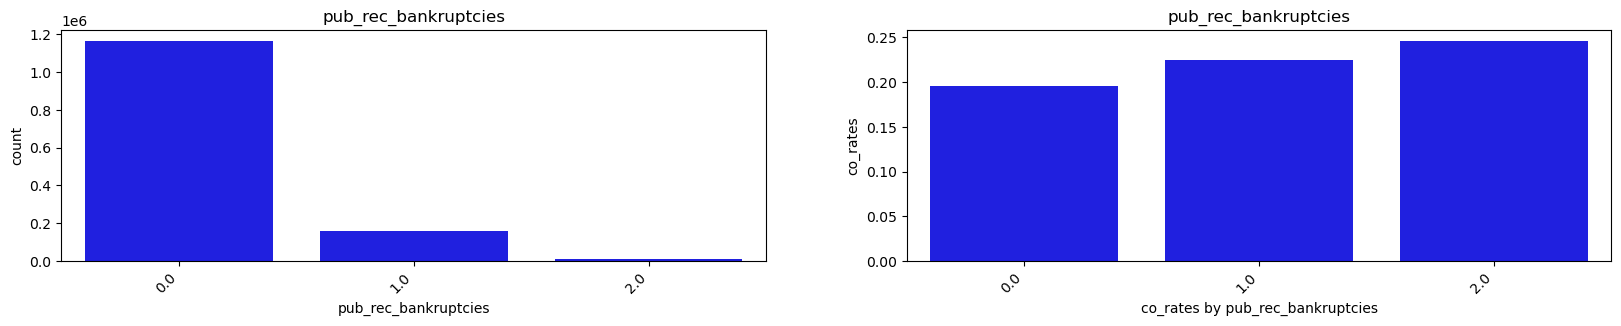

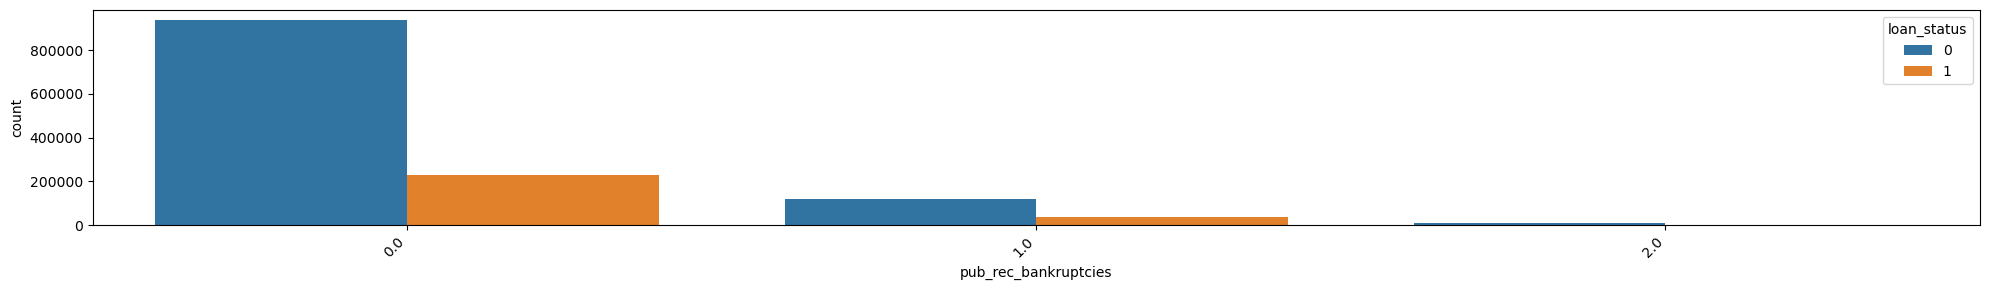

In [123]:
df2.pub_rec_bankruptcies = df2.pub_rec_bankruptcies.map(lambda x: 2 if x >1.0 else x)
variable_plot(df2, 'pub_rec_bankruptcies', continuous = False)

In [124]:
df2.groupby('loan_status')['pub_rec_bankruptcies'].describe()

count      mean       std  min  25%  50%  75%  max
loan_status                                                        
0            1065243.0  0.127927  0.354371  0.0  0.0  0.0  0.0  2.0
1             265538.0  0.150875  0.382701  0.0  0.0  0.0  0.0  2.0

In [125]:
feature,target = 'pub_rec_bankruptcies','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status                  0         1       woe        iv
pub_rec_bankruptcies                                        
0.0                   0.879082  0.858299 -0.023926  0.003899
1.0                   0.113909  0.132527  0.151386  0.003899
2.0                   0.007009  0.009174  0.269198  0.003899

In [126]:
df2.loc[:, ['pub_rec', 'pub_rec_bankruptcies']].corr()

pub_rec  pub_rec_bankruptcies
pub_rec               1.000000              0.774258
pub_rec_bankruptcies  0.774258              1.000000

In [127]:
df2 = df2.drop(columns = ['pub_rec_bankruptcies'])
df2.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'initial_list_status', 'application_type',
       'dti', 'revol_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mort_acc', 'emp_length_encoded', 'fico_score'],
      dtype='object')

REVOL BAL

- We applied log transformation to mitigate the effect of outliers

- Fully paid and charged off distributions is statistically different


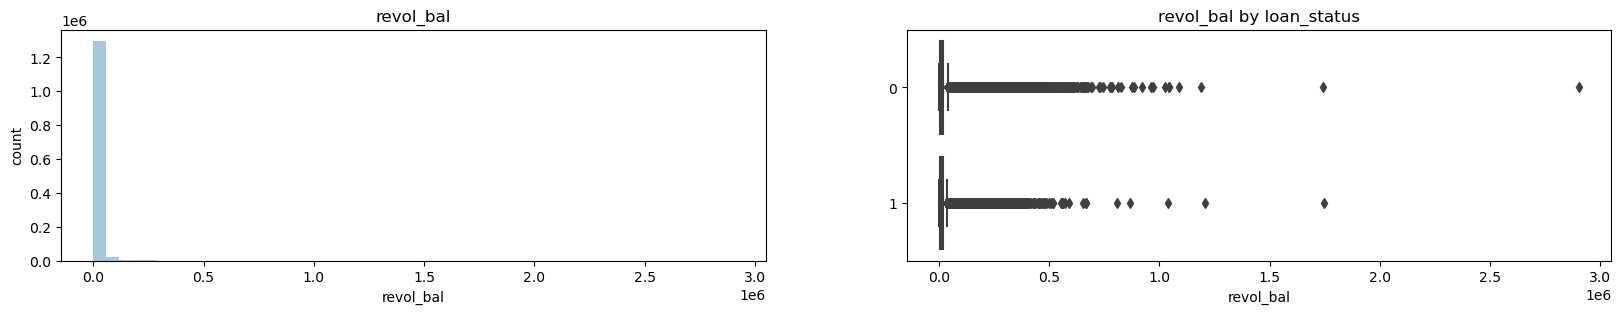

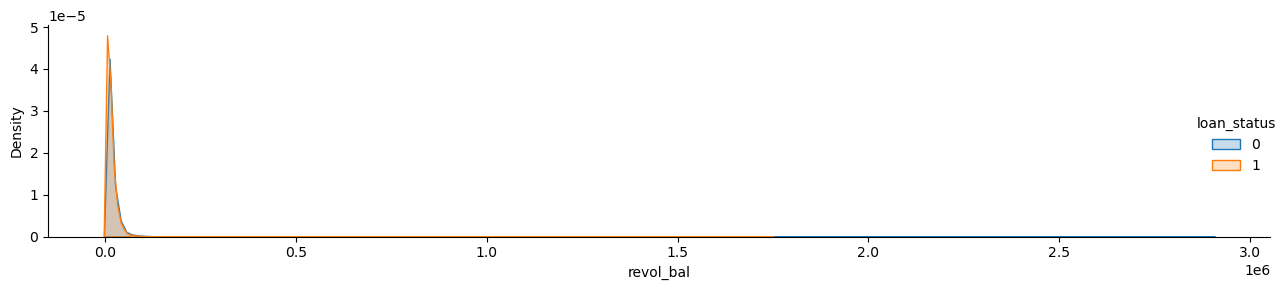

In [128]:
variable_plot(df2, 'revol_bal', continuous=True)

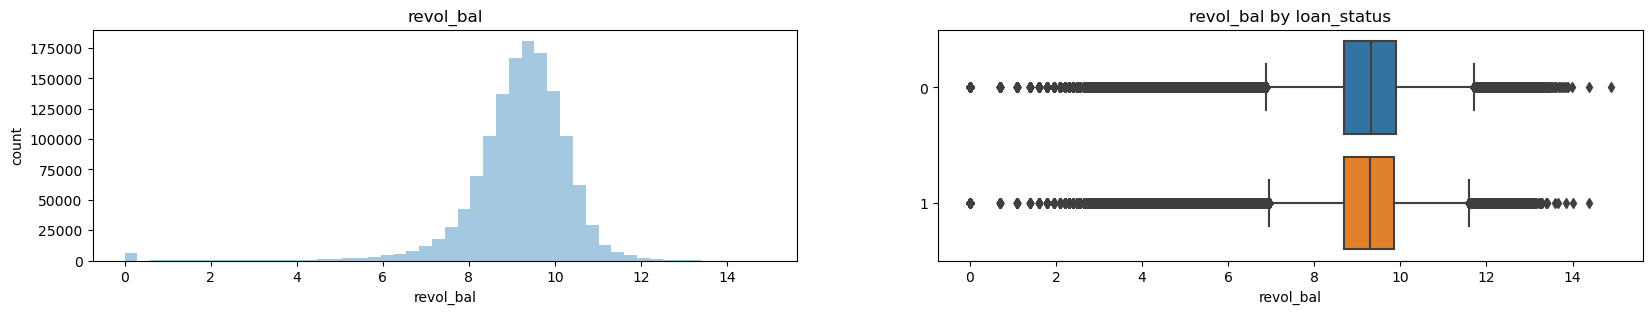

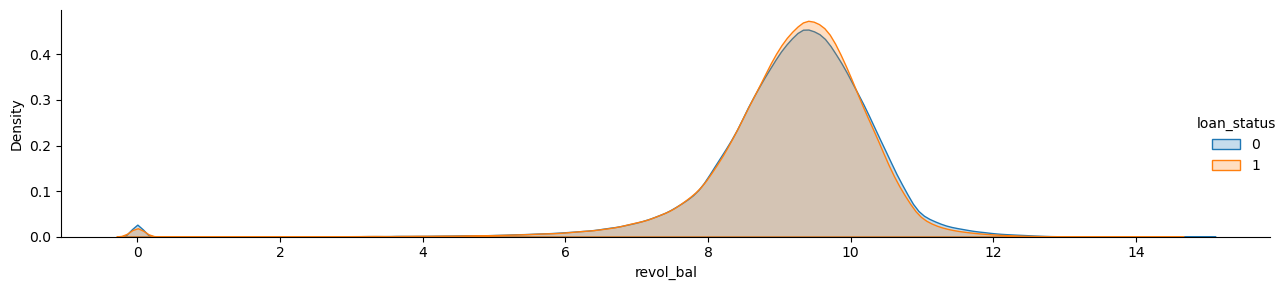

In [129]:
df2['revol_bal'] = df2['revol_bal'].apply(lambda x:np.log(x+1) if x == 0 else np.log(x))
variable_plot(df2, 'revol_bal', continuous=True)

In [130]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['revol_bal'], df2[df2['loan_status'] == 0]['revol_bal'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['revol_bal'], df2[df2['loan_status'] == 0]['revol_bal'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['revol_bal'], df2[df2['loan_status'] == 0]['revol_bal'])
p_value, p_value2, p_value3

(1.6359488753630286e-13, 3.1928975804799254e-20, 3.470280432687988e-63)

In [131]:
df2.groupby('loan_status')['revol_bal'].describe()

count      mean       std  min       25%       50%       75%  \
loan_status                                                                     
0            1065243.0  9.187536  1.233515  0.0  8.683047  9.312536  9.891162   
1             265538.0  9.168366  1.189274  0.0  8.691315  9.304696  9.848345   

                   max  
loan_status             
0            14.881887  
1            14.373248

In [132]:
df2.loc[(df2.revol_bal <= 5) | (df2.revol_bal >= 13)].groupby(by = 'loan_status').count()

loan_amnt   term  int_rate  installment  sub_grade  \
loan_status                                                       
0                10376  10376     10376        10376      10376   
1                 2476   2476      2476         2476       2476   

             home_ownership  annual_inc  verification_status  purpose  \
loan_status                                                             
0                     10376       10376                10376    10376   
1                      2476        2476                 2476     2476   

             addr_state  ...  total_acc  initial_list_status  \
loan_status              ...                                   
0                 10376  ...      10376                10376   
1                  2476  ...       2476                 2476   

             application_type    dti  revol_util  mo_sin_old_il_acct  \
loan_status                                                            
0                       10376  10376       10376               10376   
1                        2476   2476        2476                2476   

             mo_sin_old_rev_tl_op  mort_acc  emp_length_encoded  fico_score  
loan_status                                                                  
0                           10376     10376               10376       10376  
1                            2476      2476                2476        2476  

[2 rows x 24 columns]

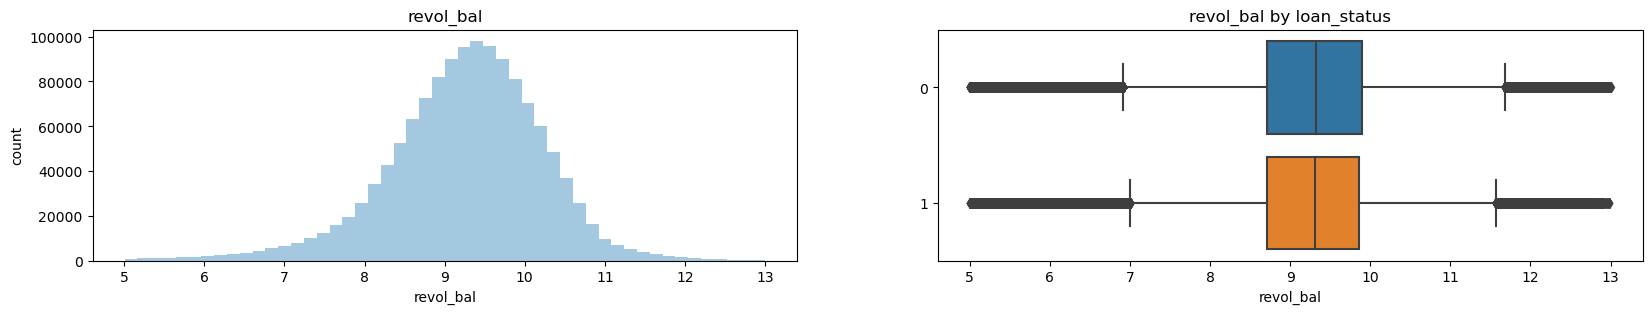

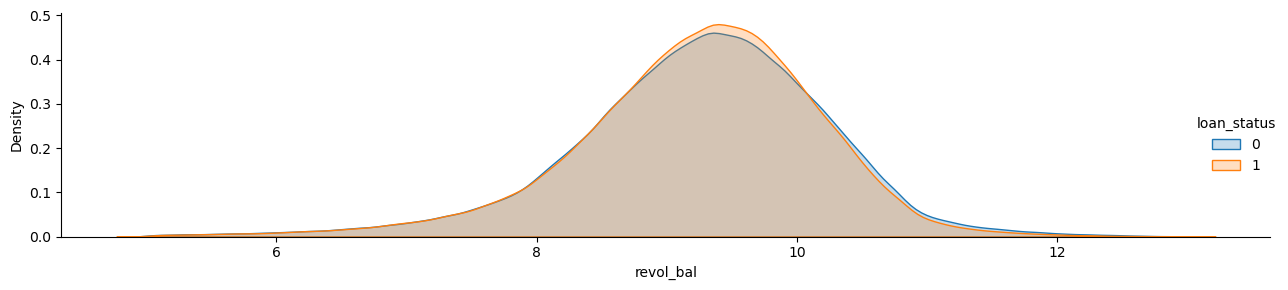

In [133]:
del_index6 = df2.loc[(df2.revol_bal <= 5) | (df2.revol_bal >= 13)].index
df2 = df2.drop(index = del_index6)
variable_plot(df2, 'revol_bal', continuous=True)

In [134]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['revol_bal'], df2[df2['loan_status'] == 0]['revol_bal'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['revol_bal'], df2[df2['loan_status'] == 0]['revol_bal'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['revol_bal'], df2[df2['loan_status'] == 0]['revol_bal'])
p_value, p_value2, p_value3

(7.503245900491026e-29, 6.4321406569088215e-22, 5.117112336643226e-64)

TOTAL ACC


- Let's apply square root transformation


- The distributions are statistically different

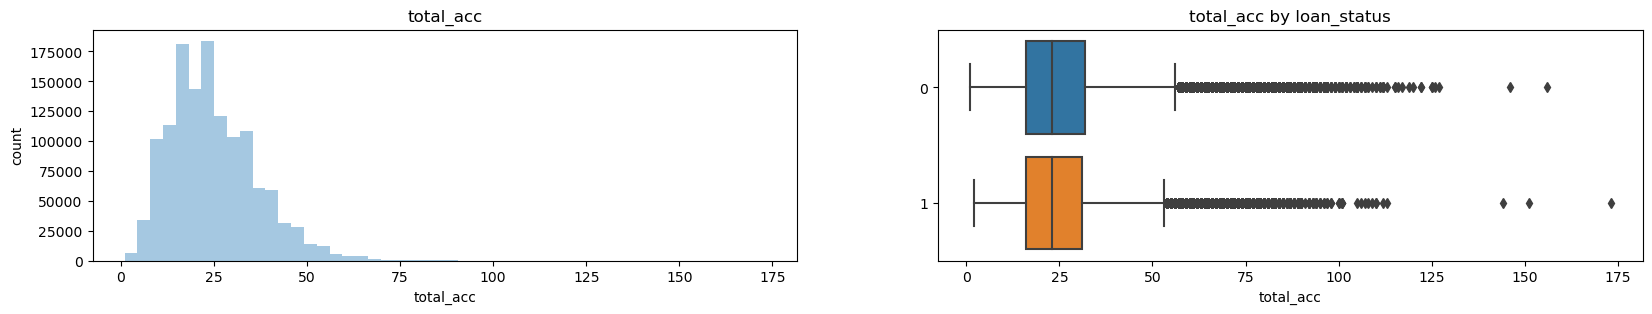

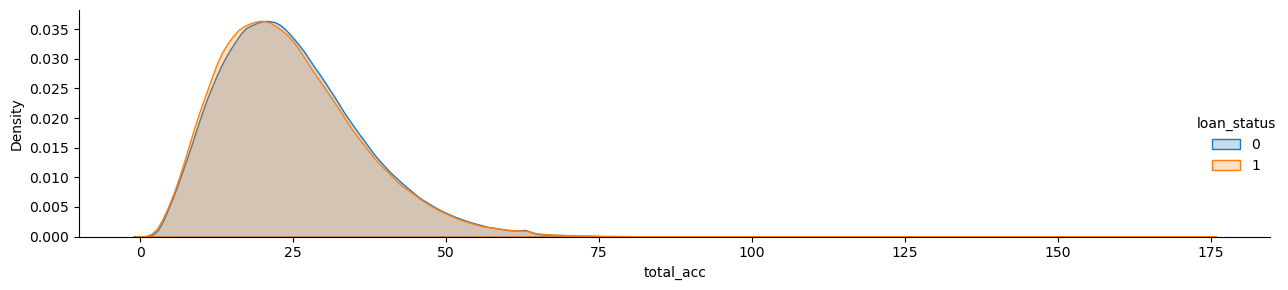

In [135]:
variable_plot(df2, 'total_acc', continuous=True)

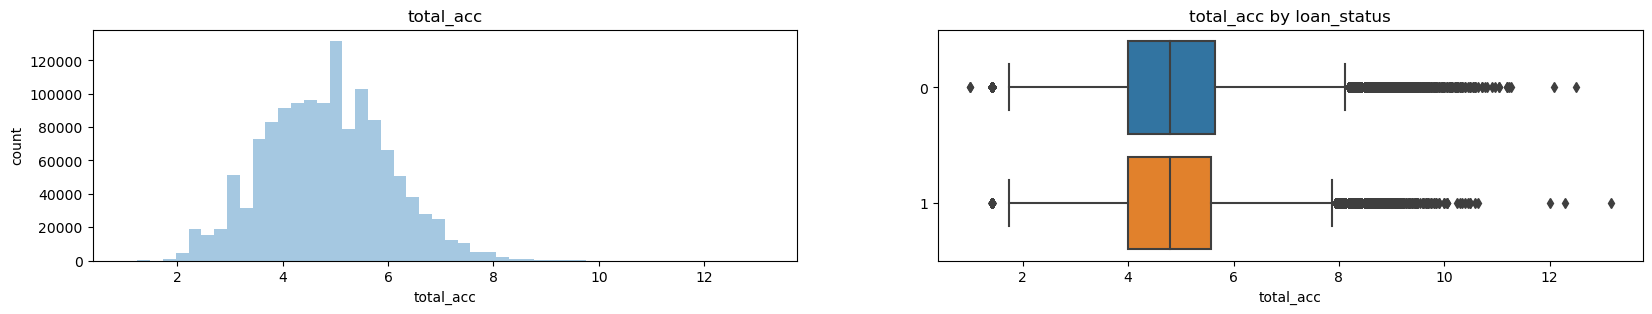

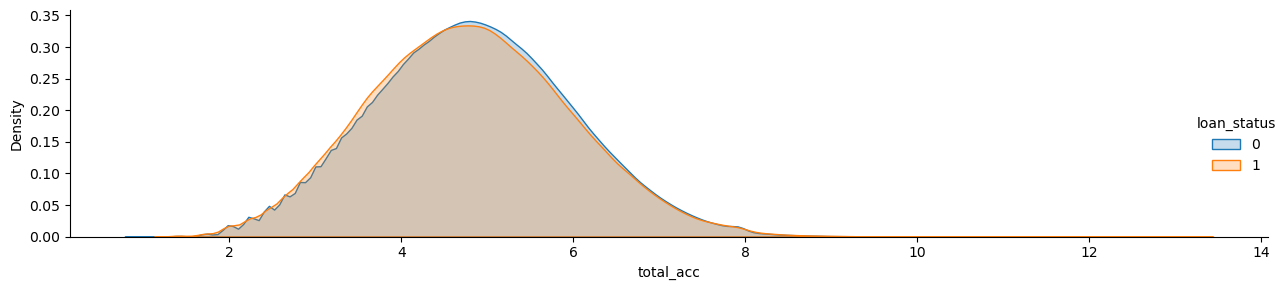

In [136]:
df2.total_acc = np.sqrt(df2.total_acc)
variable_plot(df2, 'total_acc', continuous=True)

In [137]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['total_acc'], df2[df2['loan_status'] == 0]['total_acc'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['total_acc'], df2[df2['loan_status'] == 0]['total_acc'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['total_acc'], df2[df2['loan_status'] == 0]['total_acc'])
p_value, p_value2, p_value3

(3.602629888726544e-62, 2.721937621627124e-72, 1.949494976871769e-61)

In [138]:
df2.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'initial_list_status', 'application_type',
       'dti', 'revol_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mort_acc', 'emp_length_encoded', 'fico_score'],
      dtype='object')

INITIAL LIST STATUS

- Info value is low but we'll keep it atm

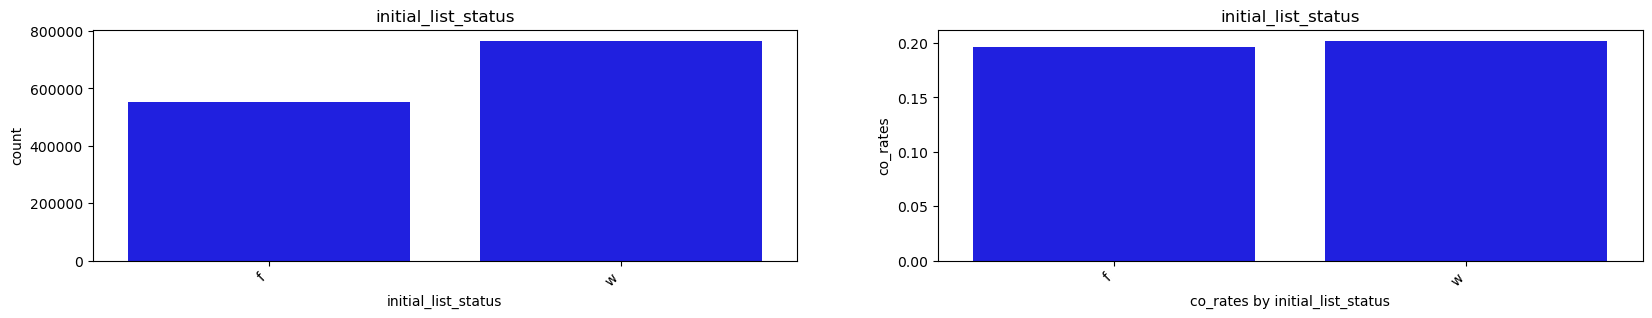

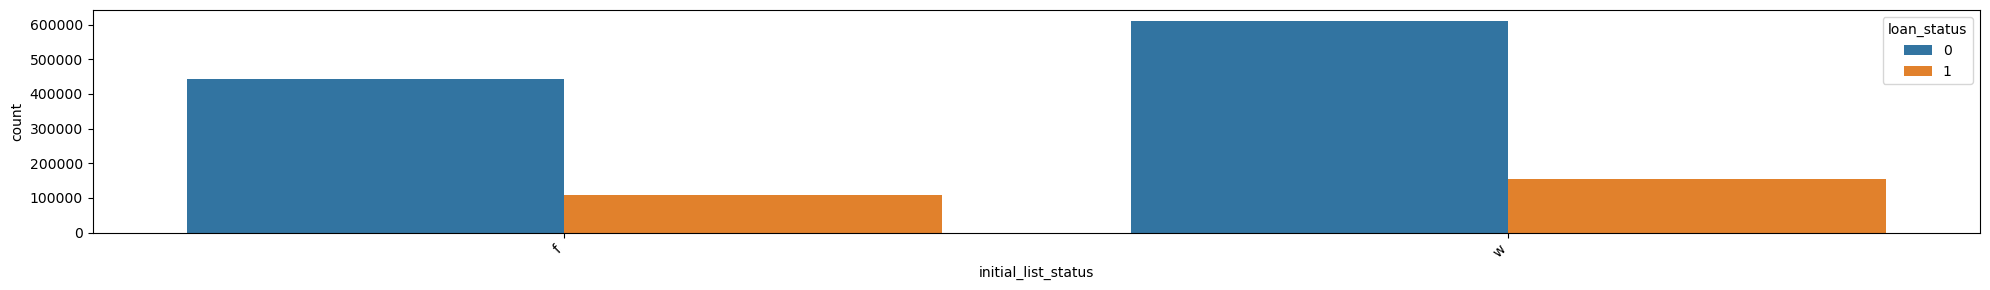

In [139]:
variable_plot(df2, 'initial_list_status', continuous=False)

In [140]:
feature,target = 'initial_list_status','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status                0         1       woe        iv
initial_list_status                                       
f                    0.42048  0.411584 -0.021386  0.000326
w                    0.57952  0.588416  0.015236  0.000326

In [141]:
from scipy.stats import chi2_contingency
chii = df.copy()
chii['initial_list_status2'] = chii['initial_list_status'].astype('category')
contingency_table = pd.crosstab(chii['initial_list_status2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

8.067212041293636e-16


application_type

- Joint application is low but its charged off rate is higher compared to individual applications which is surprising. we would expect that the charged off rate is higher for individuals


- IV is low but we'll keep it

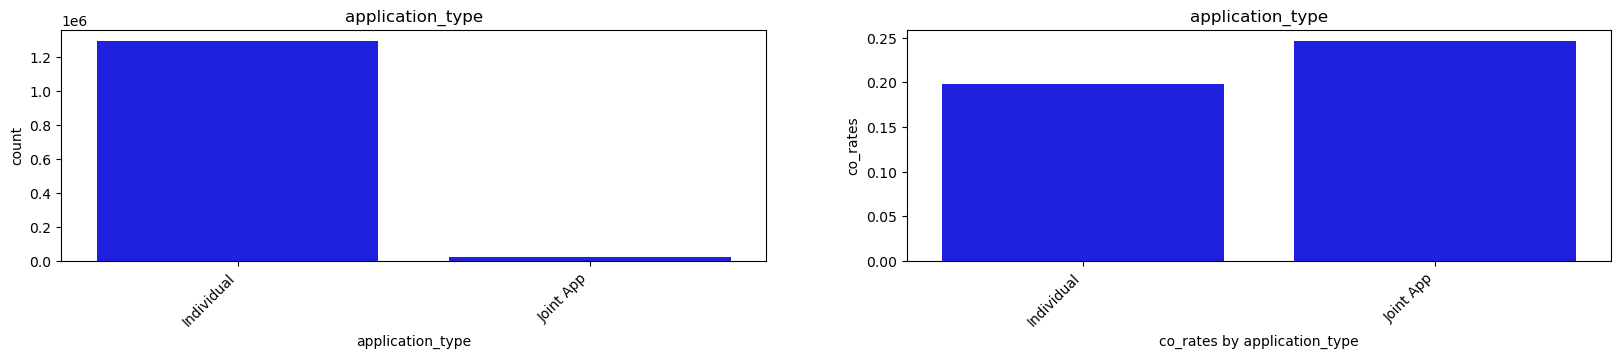

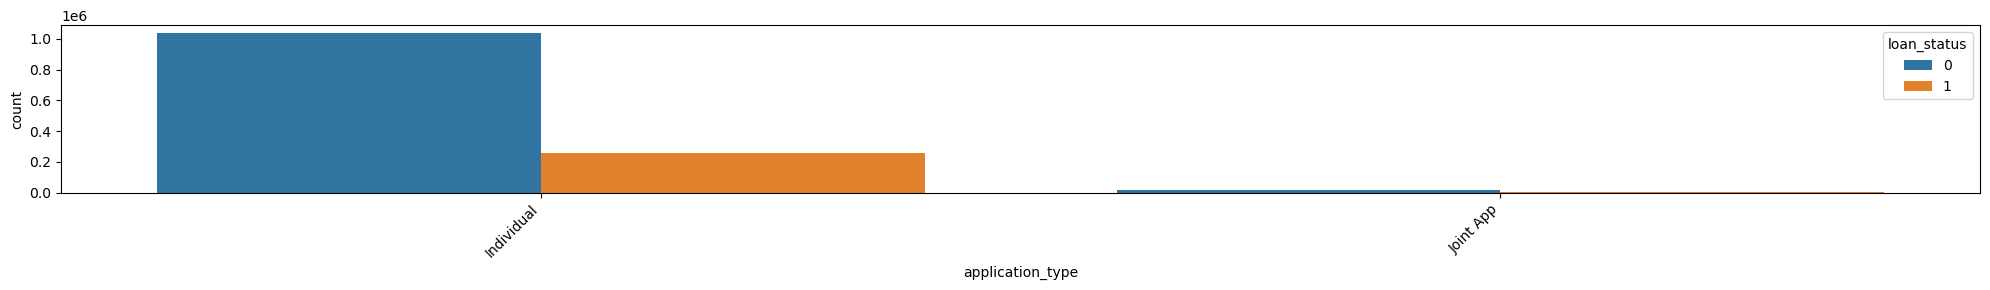

In [142]:
variable_plot(df2, 'application_type', continuous=False)

In [143]:
feature,target = 'application_type','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status              0         1       woe        iv
application_type                                        
Individual        0.982576  0.977119 -0.005569  0.001517
Joint App         0.017424  0.022881  0.272438  0.001517

In [144]:
from scipy.stats import chi2_contingency
chii = df.copy()
chii['application_type2'] = chii['application_type'].astype('category')
contingency_table = pd.crosstab(chii['application_type2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

3.7535686084329532e-78


dti

- It's clear that there are outliers because dti cannot be -1 or 999

- We winsorize the variable to reduce the effect of outliers


In [145]:
df2.dti.describe()

count    1.317929e+06
mean     1.825038e+01
std      8.878287e+00
min     -1.000000e+00
25%      1.186000e+01
50%      1.764000e+01
75%      2.405000e+01
max      4.838800e+02
Name: dti, dtype: float64

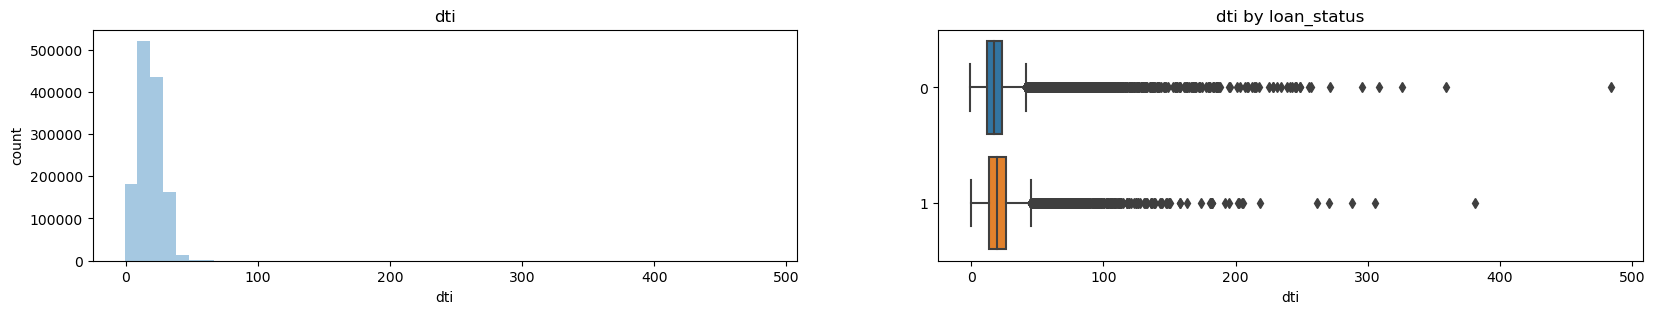

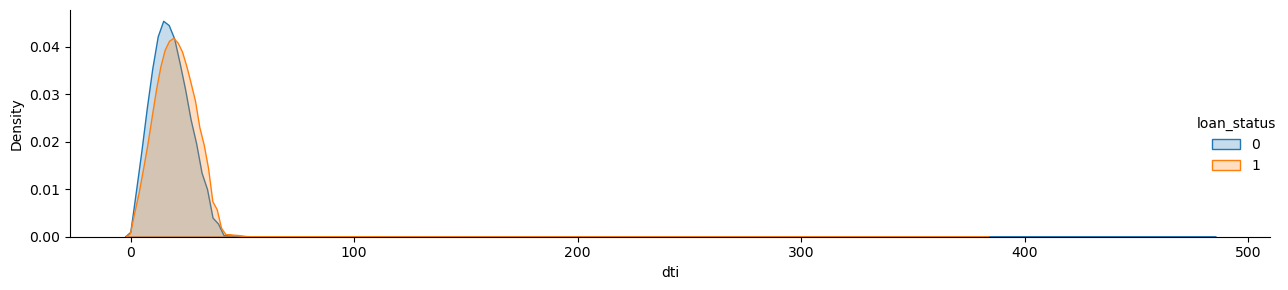

In [146]:
variable_plot(df2, 'dti', continuous=True)

In [147]:
q3, q1 = np.percentile(df['dti'], (75, 25))
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
print(upper_bound)


42.44


In [148]:
w1, w2 = np.percentile(df['dti'], (0.01, 99.60))
print(w1, upper_bound, w2)

0.0 42.44 42.64


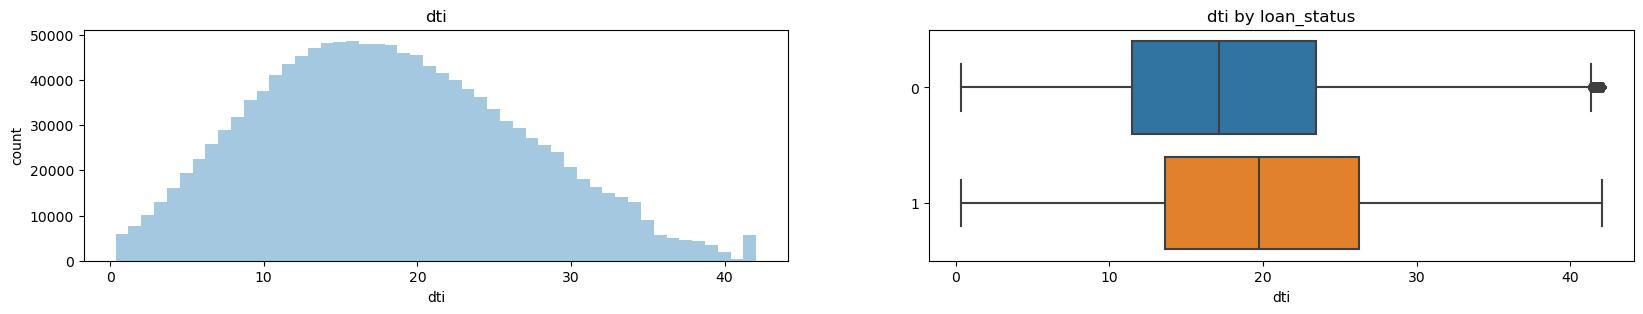

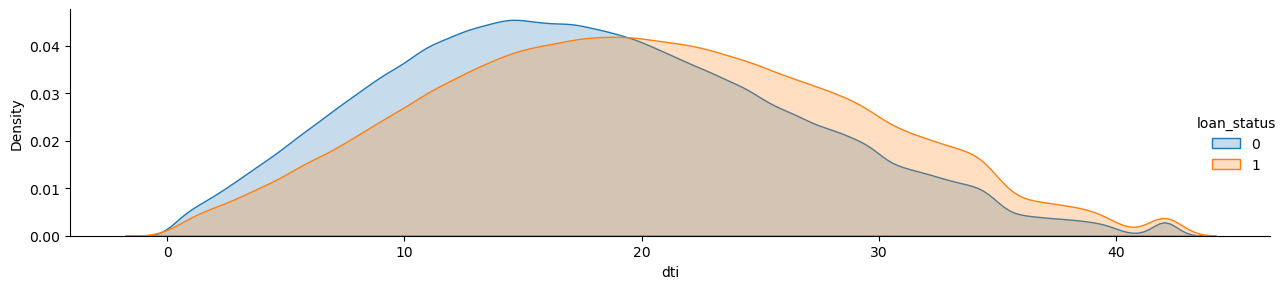

In [149]:
df2['dti'] = winsorize(df2['dti'], limits=[0.0005, 0.0040])
variable_plot(df2, 'dti', continuous = True)

In [150]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['dti'], df2[df2['loan_status'] == 0]['dti'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['dti'], df2[df2['loan_status'] == 0]['dti'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['dti'], df2[df2['loan_status'] == 0]['dti'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

In [151]:
df2.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'initial_list_status', 'application_type',
       'dti', 'revol_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mort_acc', 'emp_length_encoded', 'fico_score'],
      dtype='object')

revol_util

- As we can there is a big outlier, so let's try winsorizing

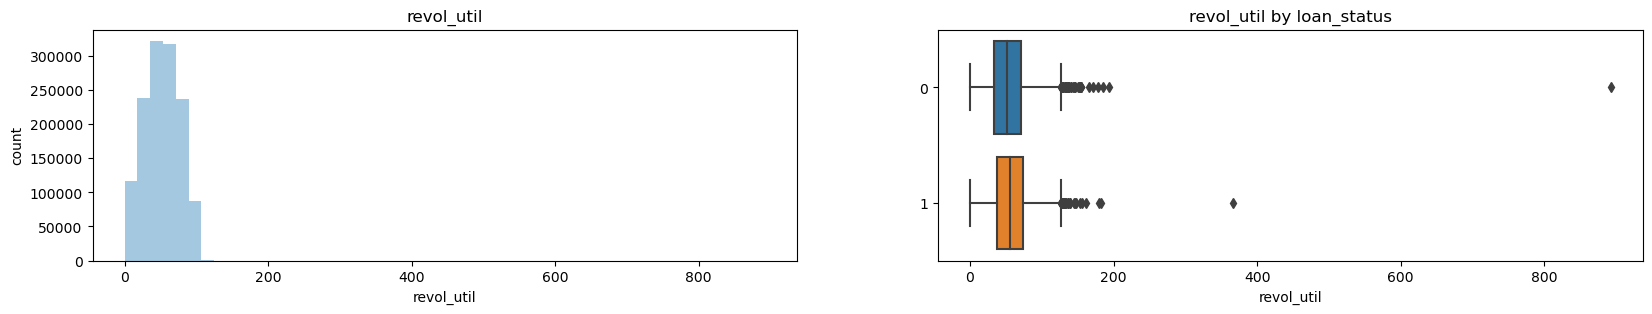

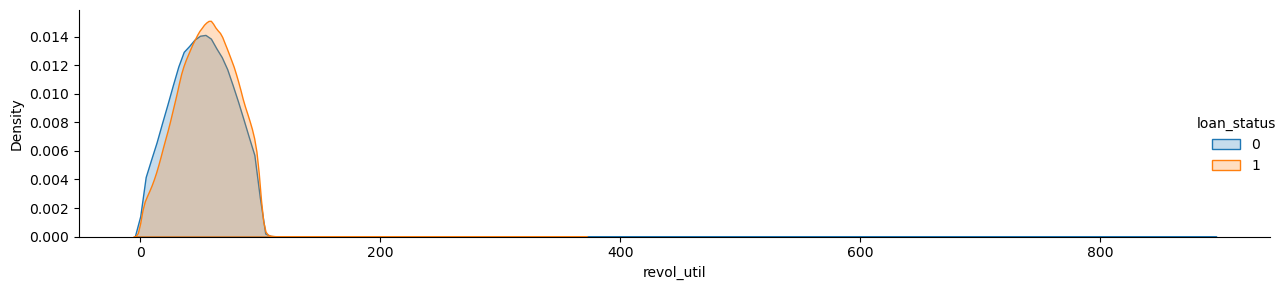

In [152]:
variable_plot(df2, 'revol_util', continuous=True)

In [153]:
q3, q1 = np.percentile(df['revol_util'], (75, 25))
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
print(upper_bound)


126.65


In [154]:
w1, w2 = np.percentile(df['revol_util'], (0.01, 99.995))
print(w1, upper_bound, w2)

0.0 126.65 127.23308000001124


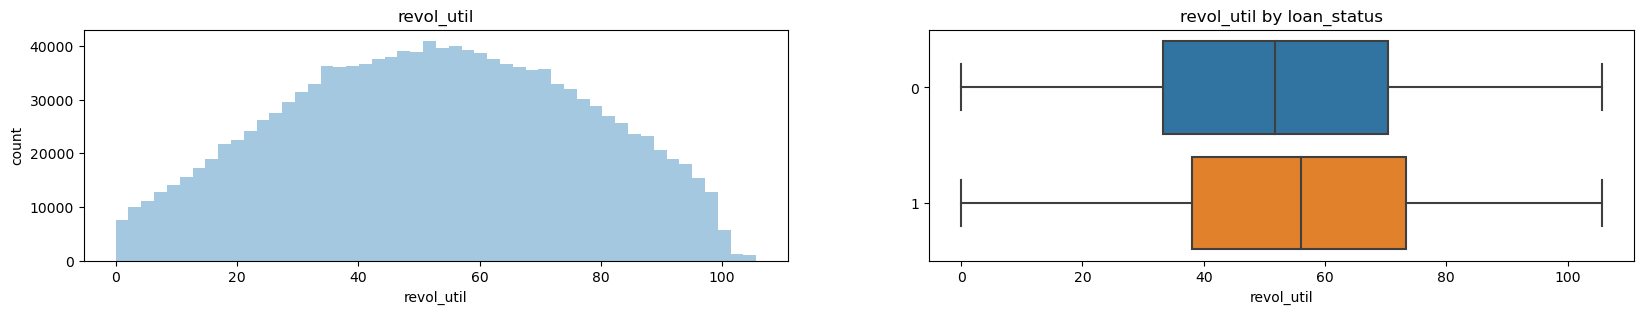

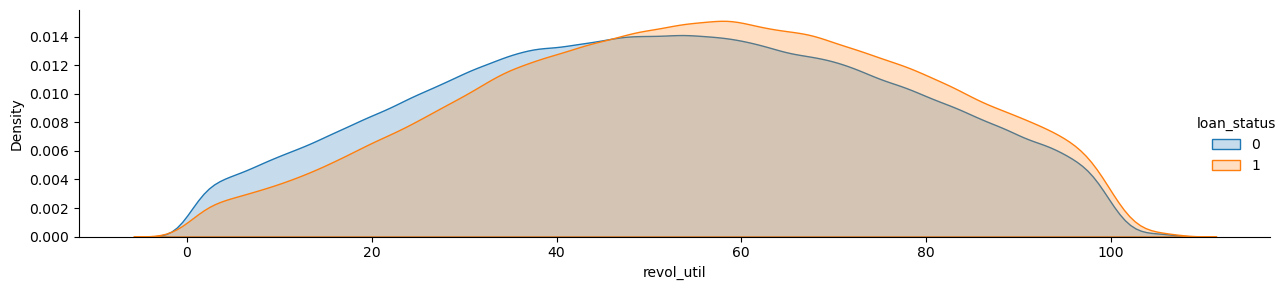

In [155]:
df2['revol_util'] = winsorize(df2['revol_util'], limits=[0.0, 0.0005])
variable_plot(df2, 'revol_util', continuous = True)

In [156]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['revol_util'], df2[df2['loan_status'] == 0]['revol_util'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['revol_util'], df2[df2['loan_status'] == 0]['revol_util'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['revol_util'], df2[df2['loan_status'] == 0]['revol_util'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

mo_sin_old_il_acct
- Winsorized at the 1% level to mitigate the effect of potential data errors


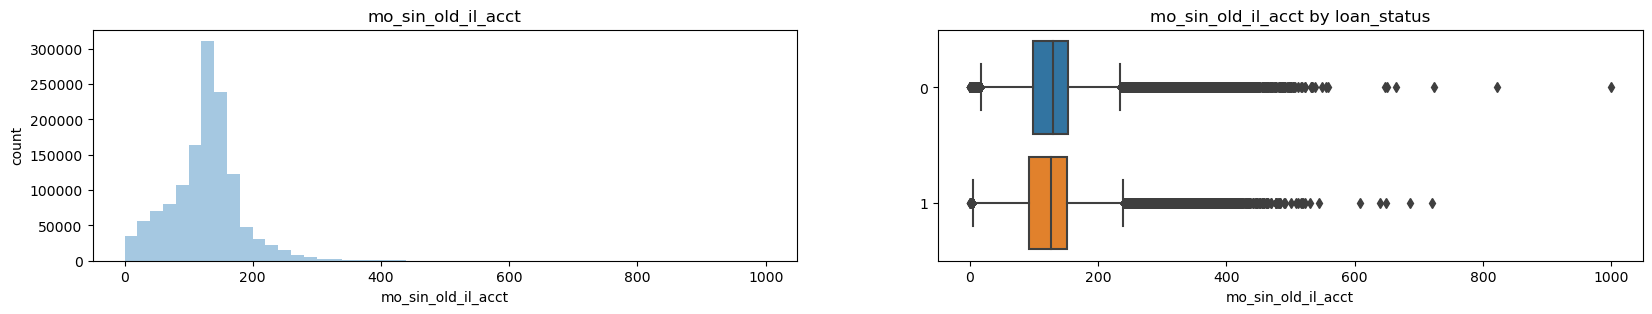

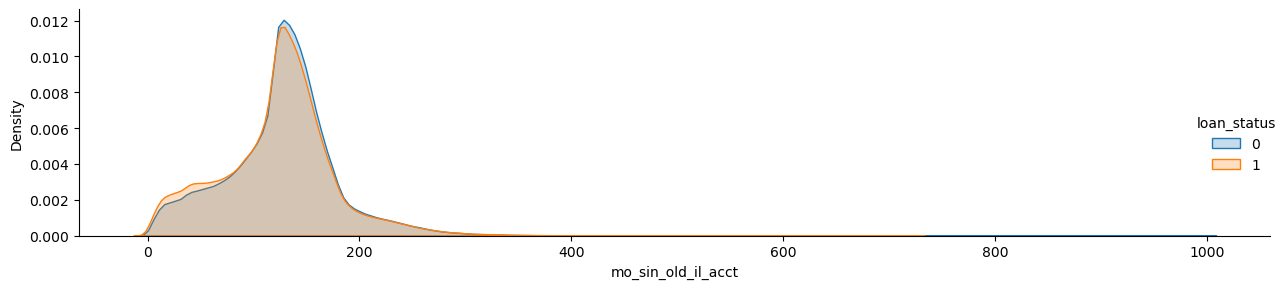

In [157]:
variable_plot(df2, 'mo_sin_old_il_acct', continuous=True)

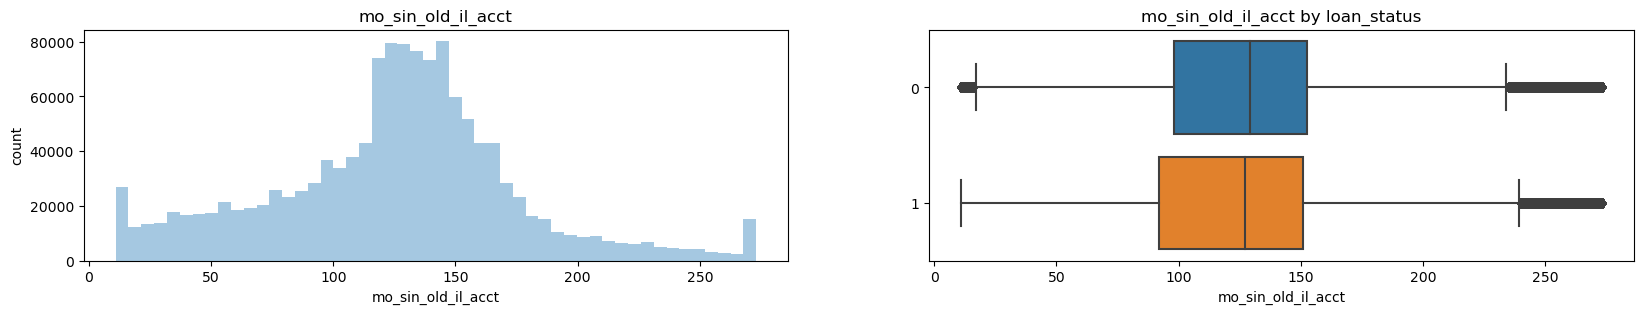

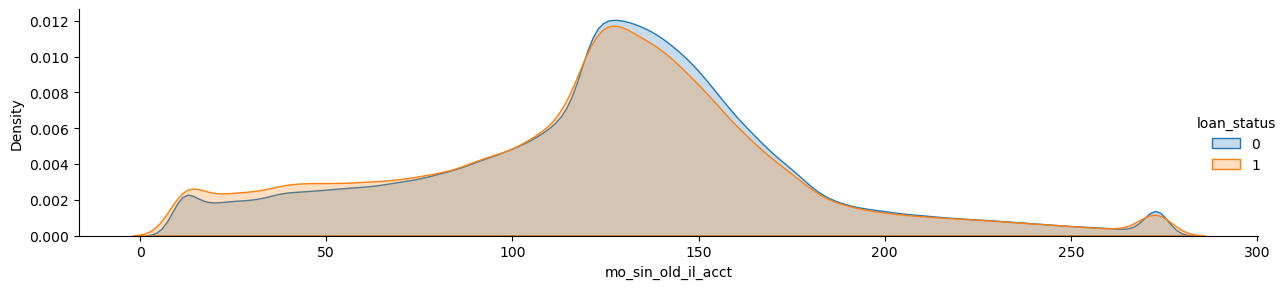

In [158]:
df2['mo_sin_old_il_acct'] = winsorize(df2['mo_sin_old_il_acct'], limits=[0.01, 0.01])
variable_plot(df2, 'mo_sin_old_il_acct', continuous=True)

In [159]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['mo_sin_old_il_acct'], df2[df2['loan_status'] == 0]['mo_sin_old_il_acct'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['mo_sin_old_il_acct'], df2[df2['loan_status'] == 0]['mo_sin_old_il_acct'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['mo_sin_old_il_acct'], df2[df2['loan_status'] == 0]['mo_sin_old_il_acct'])
p_value, p_value2, p_value3

(3.119918517179287e-180, 6.468018284369349e-203, 4.54073896480161e-163)

mo_sin_old_rev_tl_op

- Try square root transformation

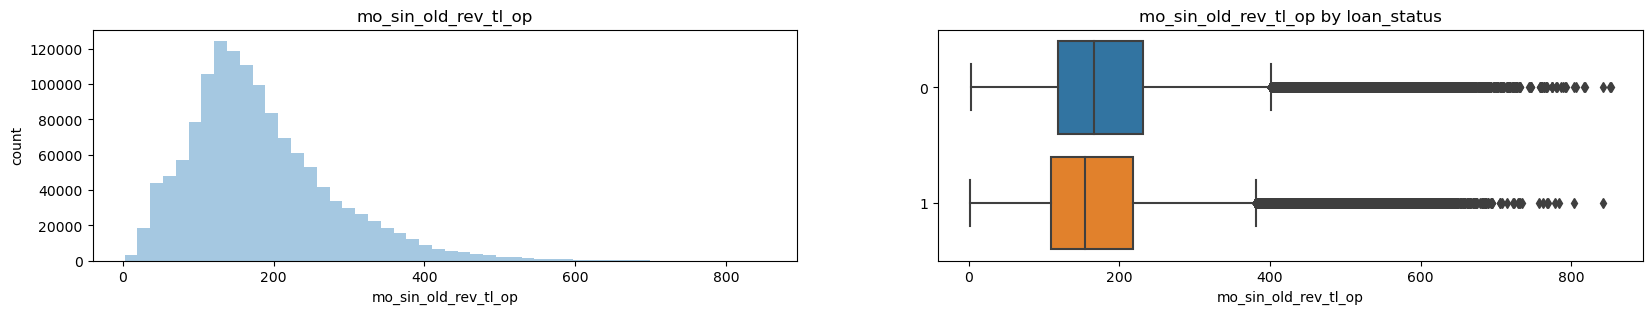

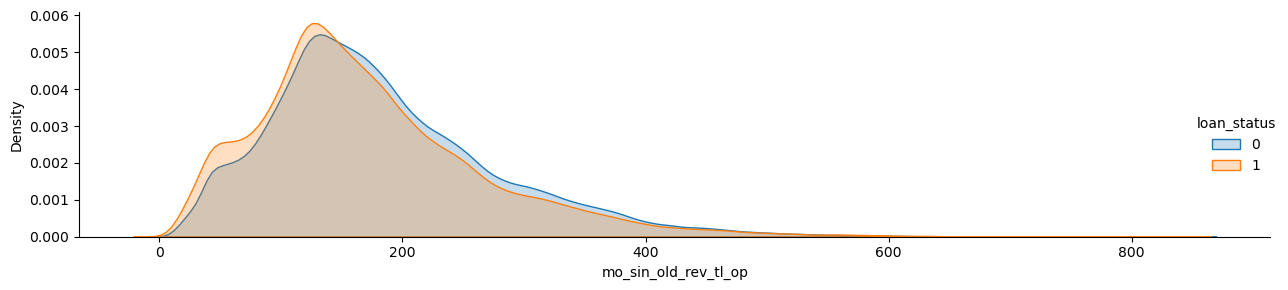

In [160]:
variable_plot(df2, 'mo_sin_old_rev_tl_op', continuous=True)

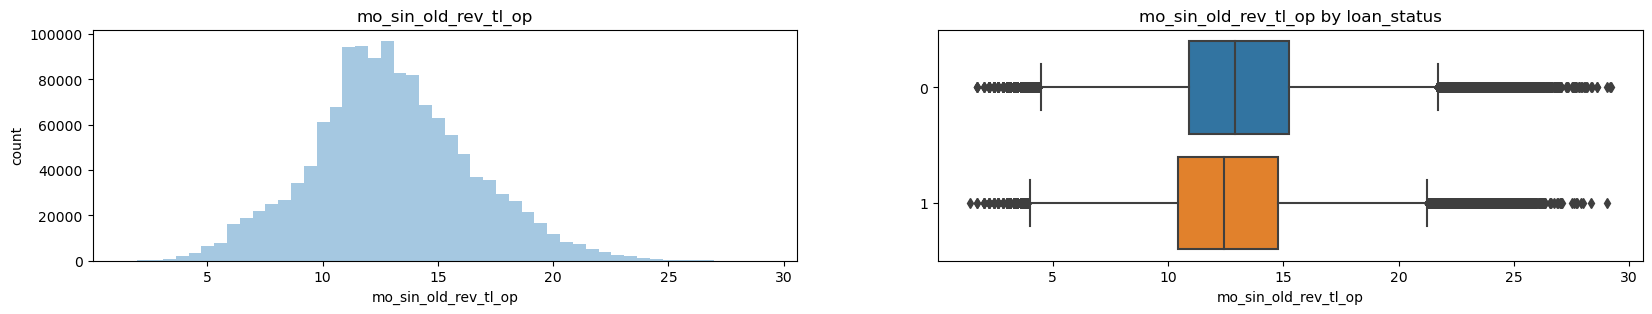

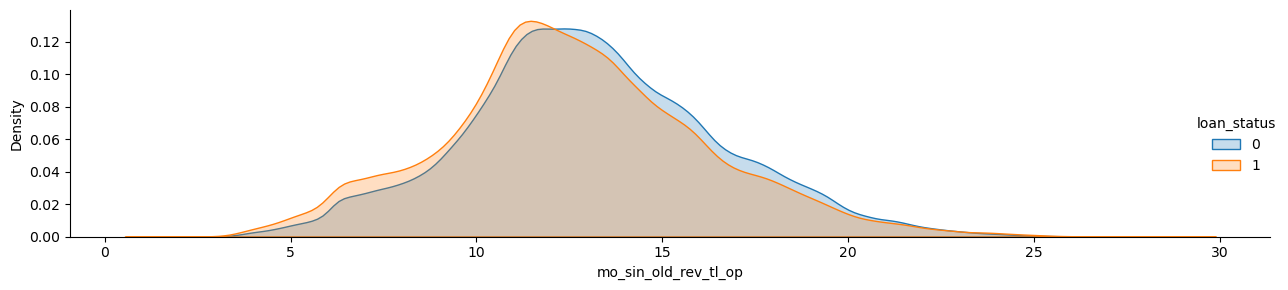

In [161]:
df2.mo_sin_old_rev_tl_op = np.sqrt(df2.mo_sin_old_rev_tl_op)
variable_plot(df2, 'mo_sin_old_rev_tl_op', continuous=True)

In [162]:
t_stat, p_value = stats.ttest_ind(df2[df2['loan_status'] == 1]['mo_sin_old_rev_tl_op'], df2[df2['loan_status'] == 0]['mo_sin_old_rev_tl_op'], equal_var=False)
statistic, p_value2 = stats.mannwhitneyu(df2[df2['loan_status'] == 1]['mo_sin_old_rev_tl_op'], df2[df2['loan_status'] == 0]['mo_sin_old_rev_tl_op'], alternative='two-sided')
ks_stat, p_value3 = stats.ks_2samp(df2[df2['loan_status'] == 1]['mo_sin_old_rev_tl_op'], df2[df2['loan_status'] == 0]['mo_sin_old_rev_tl_op'])
p_value, p_value2, p_value3

(0.0, 0.0, 0.0)

mort_acc

- The higher number of mortgage accounts result in lower rate of charged off
- IV is low but we'll keep it atm

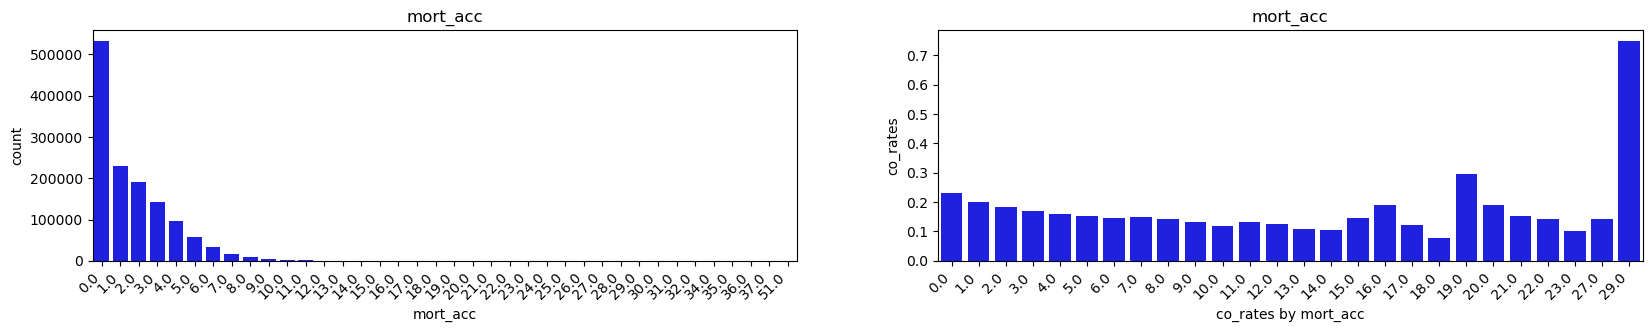

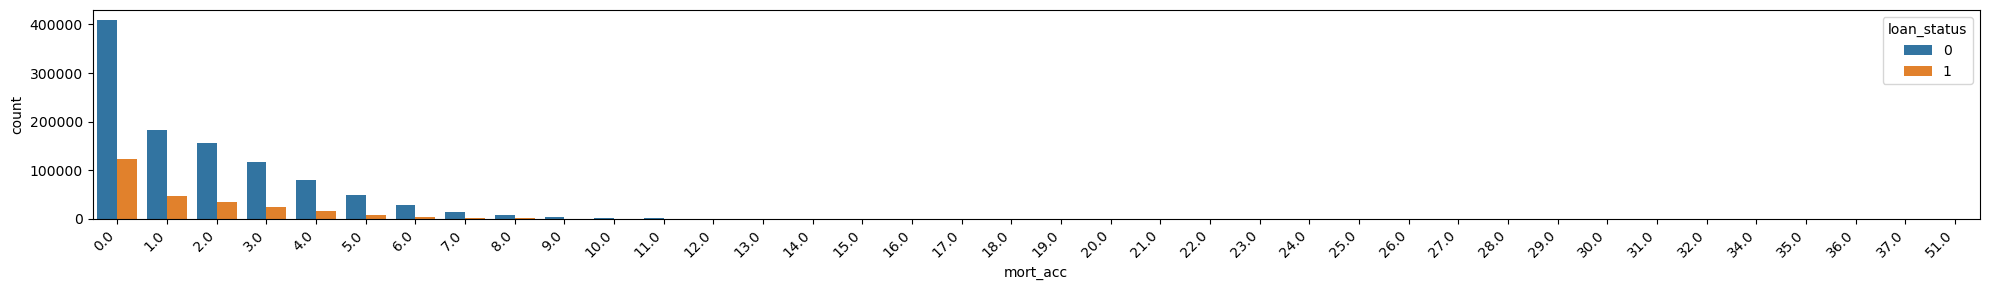

In [163]:
variable_plot(df2, 'mort_acc', continuous=False)

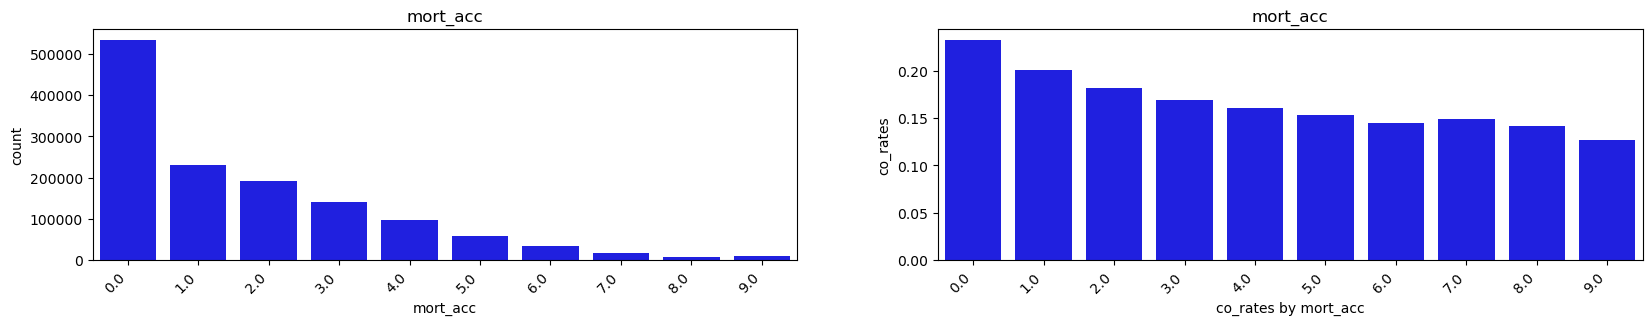

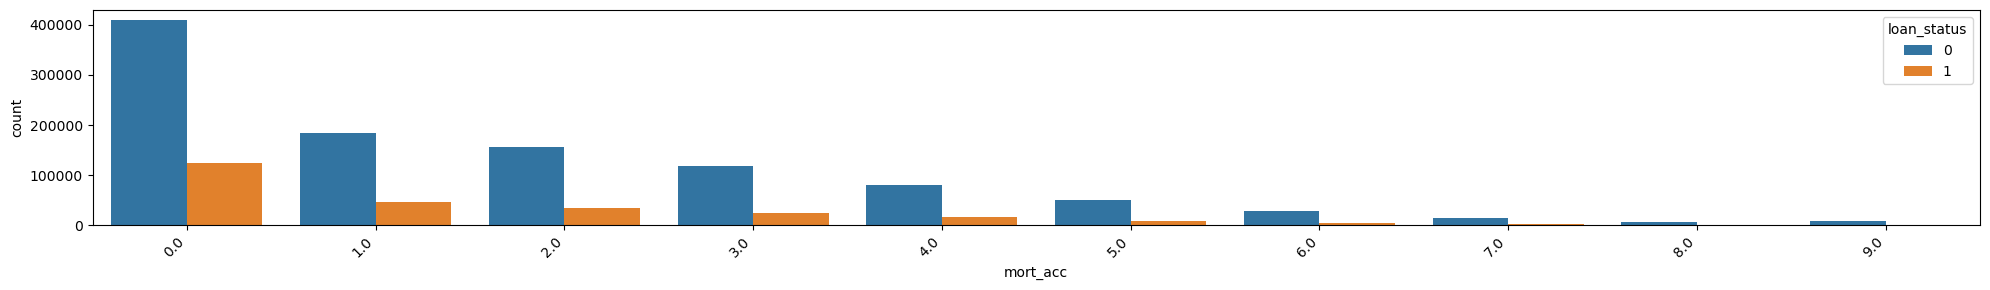

In [164]:
df2.mort_acc = df2.mort_acc.map(lambda x: 9 if x >8.0 else x)
variable_plot(df2, 'mort_acc', continuous = False)

In [165]:
feature,target = 'mort_acc','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status         0         1       woe        iv
mort_acc                                           
0.0          0.387882  0.471482  0.195180  0.038518
1.0          0.174098  0.175388  0.007385  0.038518
2.0          0.148441  0.132767 -0.111594  0.038518
3.0          0.111260  0.091005 -0.200949  0.038518
4.0          0.076440  0.058614 -0.265540  0.038518
5.0          0.046739  0.033821 -0.323491  0.038518
6.0          0.026666  0.018133 -0.385675  0.038518
7.0          0.013794  0.009694 -0.352786  0.038518
8.0          0.006877  0.004554 -0.412119  0.038518
9.0          0.007804  0.004543 -0.541103  0.038518

In [166]:
from scipy.stats import chi2_contingency
chii = df2.copy()
chii['mort_acc2'] = chii['mort_acc'].astype('category')
contingency_table = pd.crosstab(chii['mort_acc2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

0.0


In [167]:
df2.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'initial_list_status', 'application_type',
       'dti', 'revol_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mort_acc', 'emp_length_encoded', 'fico_score'],
      dtype='object')

emp_length_encoded

- Information value is low but we'll keep it

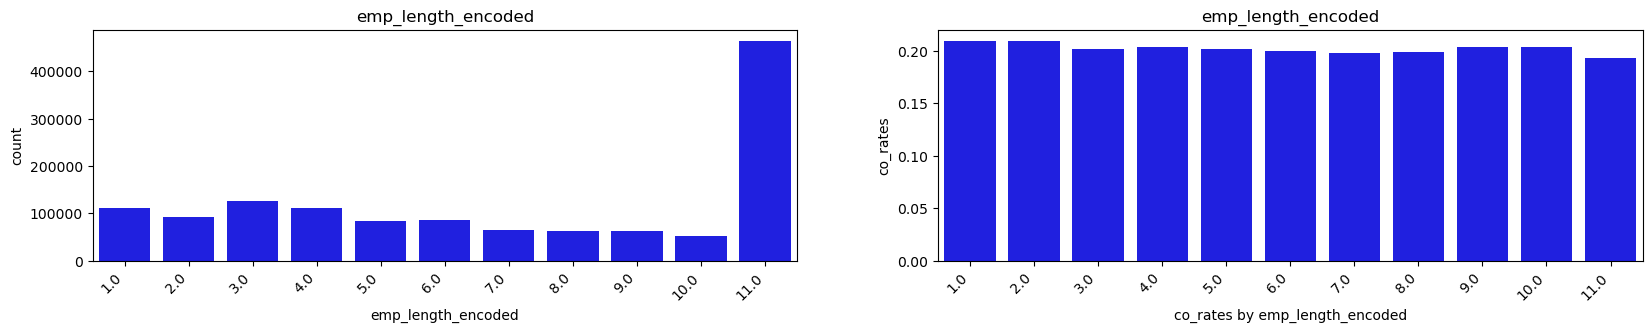

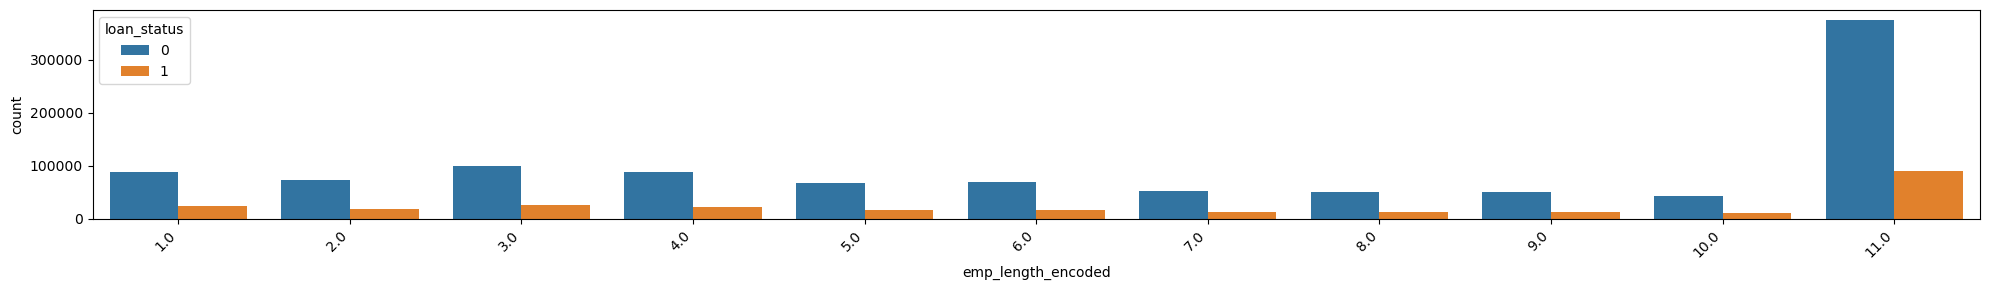

In [168]:
variable_plot(df2, 'emp_length_encoded', continuous=False)

In [169]:
feature,target = 'emp_length_encoded','loan_status'
df_woe_iv = (pd.crosstab(df2[feature],df2[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

loan_status                0         1       woe        iv
emp_length_encoded                                        
1.0                 0.083782  0.088778  0.057914  0.001344
2.0                 0.068483  0.072816  0.061350  0.001344
3.0                 0.095101  0.096521  0.014820  0.001344
4.0                 0.083931  0.085965  0.023940  0.001344
5.0                 0.063062  0.063783  0.011376  0.001344
6.0                 0.066025  0.066209  0.002773  0.001344
7.0                 0.049523  0.049038 -0.009841  0.001344
8.0                 0.047102  0.046886 -0.004583  0.001344
9.0                 0.047705  0.048863  0.023993  0.001344
10.0                0.040013  0.040956  0.023306  0.001344
11.0                0.355274  0.340186 -0.043397  0.001344

In [170]:
from scipy.stats import chi2_contingency
chii = df2.copy()
chii['emp_length_encoded2'] = chii['emp_length_encoded'].astype('category')
contingency_table = pd.crosstab(chii['emp_length_encoded2'], chii['loan_status'])

# Perform the chi-square test
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(p_value_chi2)

4.907242194045956e-55


FICO SCORE

- Higher FICO score, lower the interest rate and term based on their correlation


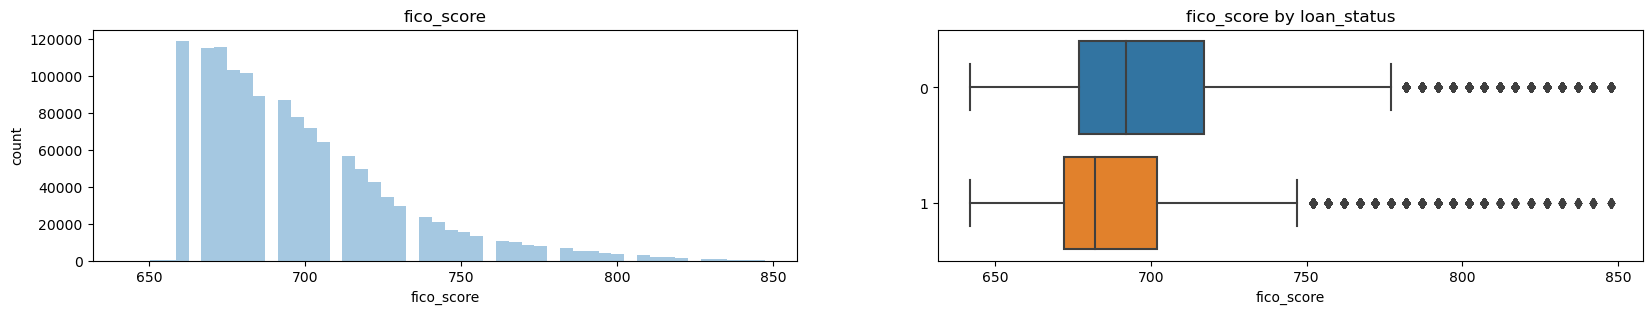

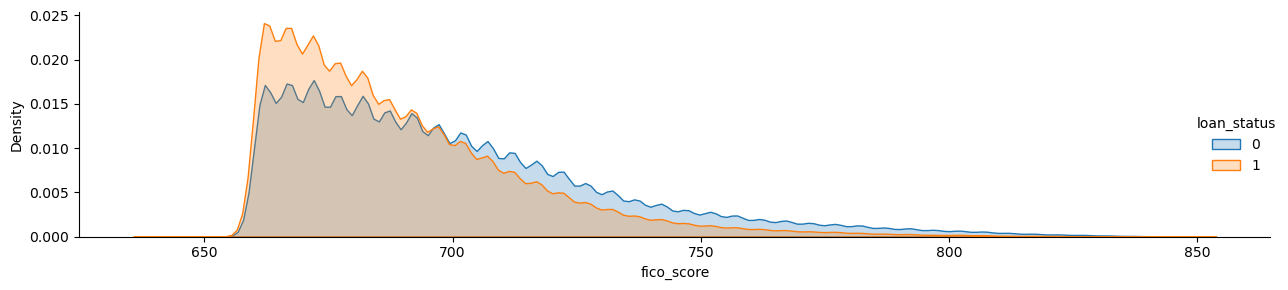

In [171]:
variable_plot(df2, 'fico_score', continuous=True)

In [172]:
df3 = df2.copy()
df3.term = df3.term.astype(int)
df3[['fico_score','int_rate','term']].corr()

fico_score  int_rate      term
fico_score    1.000000 -0.406806 -0.001485
int_rate     -0.406806  1.000000  0.418240
term         -0.001485  0.418240  1.000000

In [173]:
list_float = df3.select_dtypes(exclude=['object']).columns
list_float

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc',
       'loan_status', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'dti', 'revol_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'fico_score'],
      dtype='object')

In [174]:
def run_KS_test(df, feature):
    dist1 = df.loc[df.loan_status == 0,feature]
    dist2 = df.loc[df.loan_status == 1,feature]
    print(feature+':')
    print(stats.ks_2samp(dist1,dist2),'\n')

In [175]:
'''from statsmodels.stats.proportion import proportions_ztest
def run_proportion_Z_test(feature):
    dist1 = df.loc[df.loan_status == 0, feature]
    dist2 = df.loc[df.loan_status == 1, feature]
    n1 = len(dist1)
    p1 = dist1.sum()
    n2 = len(dist2)
    p2 = dist2.sum()
    z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
    print(feature+':')
    print('z-score = {}; p-value = {}'.format(z_score, p_value),'\n')'''

"from statsmodels.stats.proportion import proportions_ztest\ndef run_proportion_Z_test(feature):\n    dist1 = df.loc[df.loan_status == 0, feature]\n    dist2 = df.loc[df.loan_status == 1, feature]\n    n1 = len(dist1)\n    p1 = dist1.sum()\n    n2 = len(dist2)\n    p2 = dist2.sum()\n    z_score, p_value = proportions_ztest([p1, p2], [n1, n2])\n    print(feature+':')\n    print('z-score = {}; p-value = {}'.format(z_score, p_value),'\n')"

In [176]:
'''from scipy.stats import chi2_contingency
def run_chi2_test(df, feature):

    dist1 = df.loc[df.loan_status == 0,feature].value_counts().sort_index().tolist()
    dist2 = df.loc[df.loan_status == 1,feature].value_counts().sort_index().tolist()
    chi2, p, dof, expctd = chi2_contingency([dist1,dist2])
    print(feature+':')
    print("chi-square test statistic:", chi2)
    print("p-value", p, '\n')'''

'from scipy.stats import chi2_contingency\ndef run_chi2_test(df, feature):\n\n    dist1 = df.loc[df.loan_status == 0,feature].value_counts().sort_index().tolist()\n    dist2 = df.loc[df.loan_status == 1,feature].value_counts().sort_index().tolist()\n    chi2, p, dof, expctd = chi2_contingency([dist1,dist2])\n    print(feature+\':\')\n    print("chi-square test statistic:", chi2)\n    print("p-value", p, \'\n\')'

In [177]:
# All numerical variable's distributions between charged off and fully paid are statistically different
for i in list_float:
    run_KS_test(df2, i)

loan_amnt:
KstestResult(statistic=0.0829733452195045, pvalue=0.0) 

term:
KstestResult(statistic=0.18804701413132696, pvalue=0.0) 

int_rate:
KstestResult(statistic=0.2664488957590714, pvalue=0.0) 

installment:
KstestResult(statistic=0.07116150815758043, pvalue=0.0) 

annual_inc:
KstestResult(statistic=0.07218335382330643, pvalue=0.0) 

loan_status:
KstestResult(statistic=1.0, pvalue=0.0) 

earliest_cr_line:
KstestResult(statistic=0.05445293508641191, pvalue=0.0) 

open_acc:
KstestResult(statistic=0.028648192323689092, pvalue=1.4737452190189412e-150) 

pub_rec:
KstestResult(statistic=0.029488393793270395, pvalue=1.70433249752696e-159) 

revol_bal:
KstestResult(statistic=0.01864564327097684, pvalue=5.117112336643226e-64) 

total_acc:
KstestResult(statistic=0.018263367686222276, pvalue=1.949494976871769e-61) 

dti:
KstestResult(statistic=0.11402597090060979, pvalue=0.0) 

revol_util:
KstestResult(statistic=0.06507090235505414, pvalue=0.0) 

mo_sin_old_il_acct:
KstestResult(statistic=0.0

- Chi square test should be run for categorical variables to check their significance

In [178]:
df2.shape

(1317929, 25)

STANDARDISATION

- ML algorithms works best with standardisation. Therefore, we will use standardisation for numerical variables and then we'll apply dummies

In [179]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

df3 = df2.copy()

label_encoder = LabelEncoder()
category_order = sorted(df3.sub_grade.unique(), reverse=True)
label_encoder.fit(category_order)
df3['sub_grade_encoded'] = label_encoder.transform(df3.sub_grade)

for i in range(0, len(df3.columns)):
    if (df3.iloc[:, i].dtype == 'O'):
        pass
    elif (df3.iloc[:, i].name == 'loan_status'):
        pass
    else:
        column = df3.iloc[:, i].values
        scaler = StandardScaler()
        column_standardised = scaler.fit_transform(column.reshape(-1, 1))
        df3.iloc[:, i] = column_standardised

In [180]:
df3.loan_status.unique()

array([0, 1], dtype=int64)

In [181]:
pd.DataFrame(df3.isna().sum())

0
loan_amnt             0
term                  0
int_rate              0
installment           0
sub_grade             0
home_ownership        0
annual_inc            0
verification_status   0
loan_status           0
purpose               0
addr_state            0
earliest_cr_line      0
open_acc              0
pub_rec               0
revol_bal             0
total_acc             0
initial_list_status   0
application_type      0
dti                   0
revol_util            0
mo_sin_old_il_acct    0
mo_sin_old_rev_tl_op  0
mort_acc              0
emp_length_encoded    0
fico_score            0
sub_grade_encoded     0

In [182]:
df3.shape

(1317929, 26)

CORRELATION RESULTS

- Installment and loan_amnt, total_acc and open_acc, mo_sin_old_rev_tl_op and earliest_cr_line is highly correlated. therefore, installment, total_acc, and mo_sin_old_rev_tl_op will be dropped

- loan_status is correlated with interest rate, term, dti, and fico_score

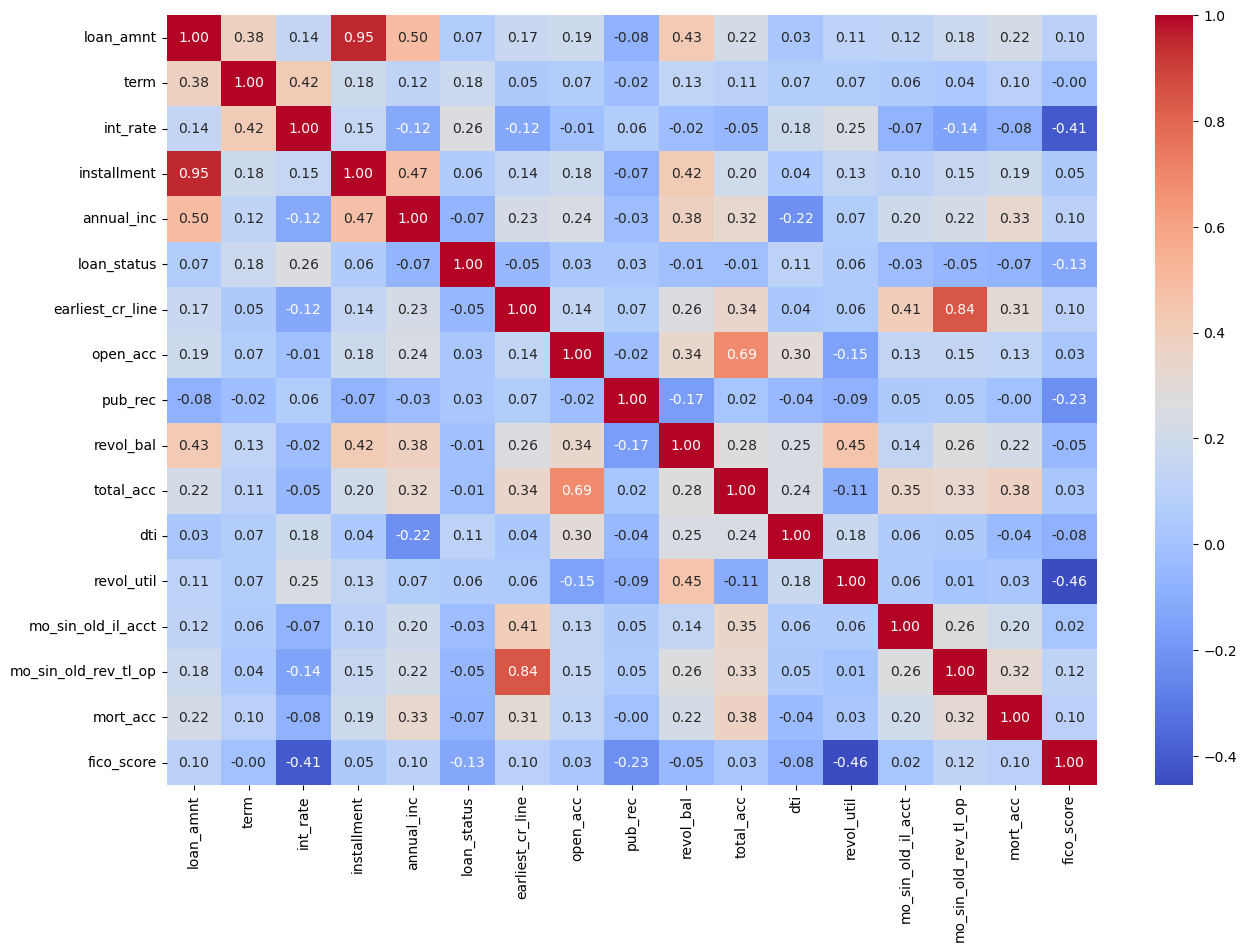

In [183]:
df4 = df3.copy()
df4.term = df4.term.astype(int)
df4.sub_grade_encoded = df4.sub_grade_encoded.astype('category')
numerical_columns= df4.select_dtypes(exclude=['object']).columns
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df4[numerical_columns].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax);

df3 = df3.drop(columns = ['mo_sin_old_rev_tl_op', 'total_acc', 'installment'])

In [184]:
cor = df4[numerical_columns].corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
corr_table = pd.DataFrame(cor[(cor > 0.1) | (cor < -0.1)])

In [185]:
corr = pd.DataFrame()
# Pearson coefficients
for col in df4[numerical_columns].columns:
    corr.loc[col, 'pearson_corr'] = df4[col].corr(df4['loan_status'])
corr['abs_pearson_corr'] = abs(corr['pearson_corr'])

corr.sort_values('abs_pearson_corr', ascending=False, inplace=True)
corr.drop('abs_pearson_corr', axis=1, inplace=True)
corr.drop('loan_status', axis=0, inplace=True)
corr.reset_index(inplace=True)
corr

index  pearson_corr
0      sub_grade_encoded      0.266775
1               int_rate      0.258406
2                   term      0.175720
3             fico_score     -0.130890
4                    dti      0.108552
5               mort_acc     -0.072937
6             annual_inc     -0.066842
7              loan_amnt      0.065862
8             revol_util      0.061160
9            installment      0.057393
10  mo_sin_old_rev_tl_op     -0.053859
11      earliest_cr_line     -0.048160
12               pub_rec      0.030719
13              open_acc      0.026982
14    mo_sin_old_il_acct     -0.025519
15             total_acc     -0.014580
16             revol_bal     -0.009502

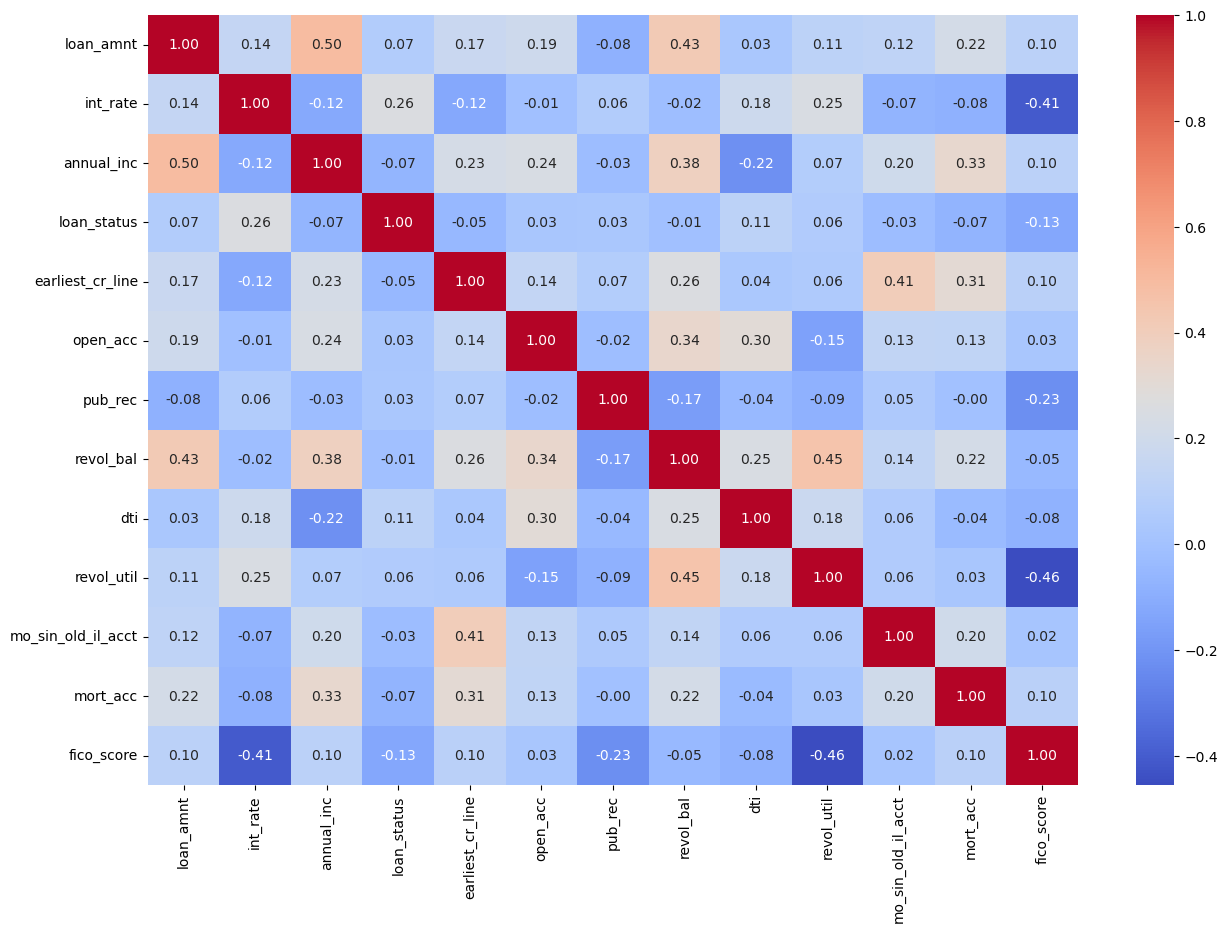

In [186]:
df5 = df3.copy()
df5.sub_grade_encoded = df5.sub_grade_encoded.astype('category')
numerical_columns= df5.select_dtypes(exclude=['object']).columns
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df5[numerical_columns].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax);

ENCODING VARIABLES

In [187]:
df3 = pd.concat([df3,pd.get_dummies(df3['term'], prefix='term'),
                    pd.get_dummies(df3['home_ownership'], prefix='home_ownership'),
                    pd.get_dummies(df3['verification_status'], prefix='verification_status'),
                    pd.get_dummies(df3['purpose'], prefix='purpose'),
                    pd.get_dummies(df3['addr_state'], prefix='addr_state'),
                    pd.get_dummies(df3['initial_list_status'], prefix='initial_list_status'),
                    pd.get_dummies(df3['application_type'], prefix='application_type')],axis=1)
df3 = df3.drop(columns = ['term', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'sub_grade'])
df3.shape

(1317929, 95)

In [188]:
df3.groupby(by= 'loan_status').describe()

loan_amnt                                                    \
                 count      mean       std       min       25%       50%   
loan_status                                                                
0            1054867.0 -0.032890  0.994229 -1.609025 -0.796421 -0.274032   
1             263062.0  0.131887  1.012140 -1.597416 -0.622291 -0.018642   

                                  int_rate            ...  \
                  75%       max      count      mean  ...   
loan_status                                           ...   
0            0.654658  2.512039  1054867.0 -0.129042  ...   
1            0.674973  2.512039   263062.0  0.517454  ...   

            application_type_Individual      application_type_Joint App  \
                                    75%  max                      count   
loan_status                                                               
0                                   1.0  1.0                  1054867.0   
1                                   1.0  1.0                   263062.0   

                                                          
                 mean       std  min  25%  50%  75%  max  
loan_status                                               
0            0.017424  0.130845  0.0  0.0  0.0  0.0  1.0  
1            0.022881  0.149523  0.0  0.0  0.0  0.0  1.0  

[2 rows x 744 columns]

UNDERSAMPLING

- Class imbalance minority: 24% percent 

In [189]:
df4 = df3.copy()
df4.groupby(by= 'loan_status').describe()

loan_amnt                                                    \
                 count      mean       std       min       25%       50%   
loan_status                                                                
0            1054867.0 -0.032890  0.994229 -1.609025 -0.796421 -0.274032   
1             263062.0  0.131887  1.012140 -1.597416 -0.622291 -0.018642   

                                  int_rate            ...  \
                  75%       max      count      mean  ...   
loan_status                                           ...   
0            0.654658  2.512039  1054867.0 -0.129042  ...   
1            0.674973  2.512039   263062.0  0.517454  ...   

            application_type_Individual      application_type_Joint App  \
                                    75%  max                      count   
loan_status                                                               
0                                   1.0  1.0                  1054867.0   
1                                   1.0  1.0                   263062.0   

                                                          
                 mean       std  min  25%  50%  75%  max  
loan_status                                               
0            0.017424  0.130845  0.0  0.0  0.0  0.0  1.0  
1            0.022881  0.149523  0.0  0.0  0.0  0.0  1.0  

[2 rows x 744 columns]

In [ ]:
'''df_attributes_under = df4.drop(columns = ['loan_status'])
df_target_under = pd.DataFrame(df4.loan_status)
df_attributes_under.shape, df_target_under.shape'''

In [ ]:
'''def split_sets(df_X, df_y):
    df_attributes_new = df_X
    df_target = df_y

    X_train_temp, X_test, y_train_temp, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

sets = split_sets(df_attributes_under, df_target_under)

X_train = sets[0]
X_val = sets[1]
X_test = sets[2]
y_train = sets[3]
y_val = sets[4]
y_test = sets[5]'''

In [195]:
'''from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X, y = X_train, y_train
# define pipeline
steps = [('under', RandomUnderSampler()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)'''

"# example of evaluating a decision tree with random undersampling\nfrom numpy import mean\nfrom sklearn.datasets import make_classification\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nfrom sklearn.tree import DecisionTreeClassifier\nfrom imblearn.pipeline import Pipeline\nfrom imblearn.under_sampling import RandomUnderSampler\n# define dataset\nX, y = X_train, y_train\n# define pipeline\nsteps = [('under', RandomUnderSampler()), ('model', DecisionTreeClassifier())]\npipeline = Pipeline(steps=steps)\n# evaluate pipeline\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)\nscores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)\nscore = mean(scores)\nprint('F1 Score: %.3f' % score)"

In [ ]:
'''from imblearn.under_sampling import RandomUnderSampler

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler()

# Undersample the training data
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

X_train_undersampled.shape, y_train_undersampled.shape'''

In [ ]:
'''#MAIN CODE
from sklearn.feature_selection import RFECV
import lightgbm as lgb

# Assuming X is your feature matrix and y is your target variable
estimator = lgb.LGBMRegressor()
rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='r2', verbose=1)
rfecv.fit(X_train_undersampled, y_train_undersampled)

# Get the selected features
selected_features = X_train_undersampled.columns[rfecv.support_]

pd.DataFrame(selected_features).to_excel("selected_features_lightgbm_undersampled.xlsx", index = False)

# Print the ranking of features
print("Feature Ranking:")
print(rfecv.ranking_)

pd.DataFrame(rfecv.ranking_, index = X_train_undersampled.columns).to_excel("selected_features_lightgbm_rankings_undersampled.xlsx", index = False)

# Print the selected features
print("Selected Features:")
print(selected_features)'''

In [ ]:
'''variables_selected_under = pd.read_excel("selected_features_lightgbm_undersampled.xlsx")
variables_selected_list_under = variables_selected_under.iloc[:, 0].tolist()
X_train_undersampled_new = X_train_undersampled.loc[:, variables_selected_list_under]
X_val_new = X_val.loc[:, variables_selected_list_under]
X_test_new = X_test.loc[:, variables_selected_list_under]
X_train_undersampled_new.shape, X_train_undersampled.shape'''

ISOLATION FOREST RESULT

- Outliers: 9
- Total Samples: 315494

- Outlier Percentage: 0%

In [200]:
'''from sklearn.ensemble import IsolationForest

isofor = IsolationForest(random_state=42)

clf = isofor.fit_predict(X_train_undersampled)
outliers = pd.DataFrame(clf).loc[pd.DataFrame(clf)[0] == -1].count().values[0]
total_samples = len(X_train_undersampled)

outlier_percentage = round(outliers / total_samples, 2)
print(outliers, total_samples, outlier_percentage)'''

'from sklearn.ensemble import IsolationForest\n\nisofor = IsolationForest(random_state=42)\n\nclf = isofor.fit_predict(X_train_undersampled)\noutliers = pd.DataFrame(clf).loc[pd.DataFrame(clf)[0] == -1].count().values[0]\ntotal_samples = len(X_train_undersampled)\n\noutlier_percentage = round(outliers / total_samples, 2)\nprint(outliers, total_samples, outlier_percentage)'

In [201]:
X_train_undersampled_new = pd.read_csv("D:/!!!FINANCE_AND_TECHNOLOGY/Quantitative_Financial_Risk_Management/Assignment_4/xtrain_undersampled_new.csv", sep=',')
y_train_undersampled = pd.read_csv("D:/!!!FINANCE_AND_TECHNOLOGY/Quantitative_Financial_Risk_Management/Assignment_4/y_train_undersampled.csv", sep=',')

X_val_new = pd.read_csv("D:/!!!FINANCE_AND_TECHNOLOGY/Quantitative_Financial_Risk_Management/Assignment_4/X_val_new.csv", sep=',')
y_val = pd.read_csv("D:/!!!FINANCE_AND_TECHNOLOGY/Quantitative_Financial_Risk_Management/Assignment_4/y_val.csv", sep=',')

X_test_new = pd.read_csv("D:/!!!FINANCE_AND_TECHNOLOGY/Quantitative_Financial_Risk_Management/Assignment_4/X_test_new.csv", sep=',')
y_test = pd.read_csv("D:/!!!FINANCE_AND_TECHNOLOGY/Quantitative_Financial_Risk_Management/Assignment_4/y_test.csv", sep=',')

In [202]:
X_train_undersampled_new.shape

(315494, 61)

XGBOOST

TRAIN: 
ACCURACY SCORE:  0.6568048837695803
PRECISION SCORE:  0.6506838049404526
F1 SCORE:  0.6636367590136129
Confusion Matrix:
[[100405  57342]
 [ 50934 106813]]
CLASSIFICATIN REPORT: 
              precision    recall  f1-score   support

           0       0.66      0.64      0.65    157747
           1       0.65      0.68      0.66    157747

    accuracy                           0.66    315494
   macro avg       0.66      0.66      0.66    315494
weighted avg       0.66      0.66      0.66    315494

VALIDATION: 
ACCURACY SCORE:  0.640587891617916
PRECISION SCORE:  0.31382766949489943
F1 SCORE:  0.42819203515252474
Confusion Matrix:
[[133379  77556]
 [ 17180  35471]]
CLASSIFICATIN REPORT: 
              precision    recall  f1-score   support

           0       0.89      0.63      0.74    210935
           1       0.31      0.67      0.43     52651

    accuracy                           0.64    263586
   macro avg       0.60      0.65      0.58    263586
weighted avg       0.

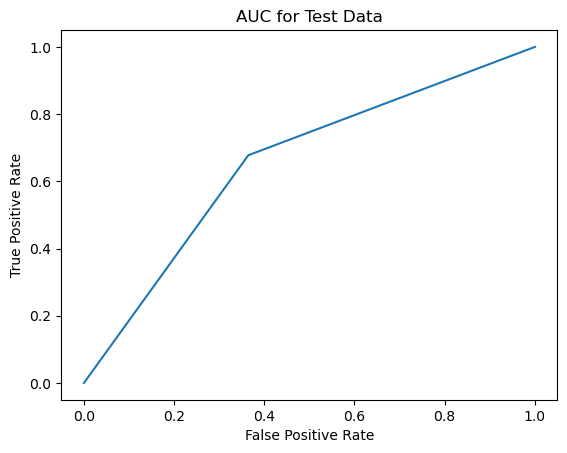

AUC Score:  0.6530115790027883


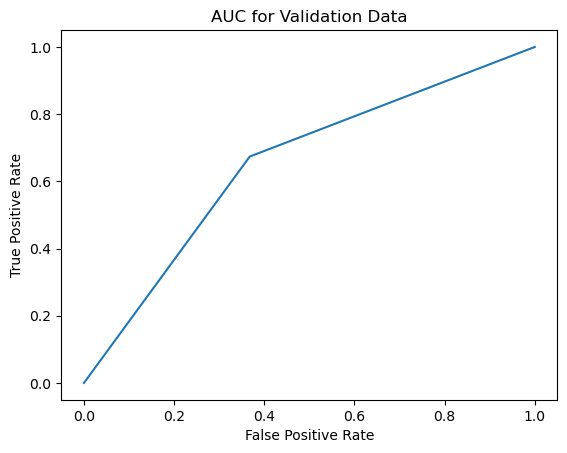

AUC Score:  0.6568048837695805


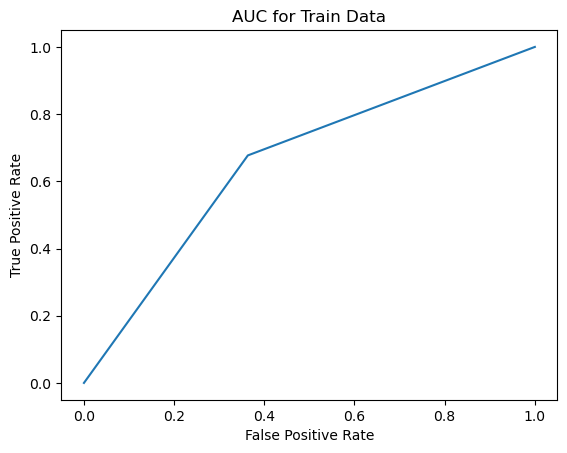

In [188]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

xgb = XGBClassifier(random_state = 42, max_delta_step = 1)

model2 = xgb.fit(X_train_undersampled_new, y_train_undersampled)

y_pred_train = model2.predict(X_train_undersampled_new)

'''param_grid = {'n_estimators': range(100, 126),
              'criterion': ['gini', 'entropy', 'log_loss'],
              'min_samples_leaf': range(1, 11),
              'max_depth': [None, 10, 11, 12, 13, 14, 15],
              'max_features': [None, 'sqrt', 'log2', 1, 2, 3]}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2)
grid_search.fit(X_val_new2, y_val2)

best_params = grid_search.best_params_
print(best_params)

best_model = rf.set_params(**grid_search.best_params_)

best_model.fit(X_train_undersampled_new2, y_train_undersampled2)'''

y_pred_val = model2.predict(X_val_new)

y_pred_test = model2.predict(X_test_new)

print("TRAIN: ")
print("ACCURACY SCORE: ", accuracy_score(y_train_undersampled, y_pred_train))
print("PRECISION SCORE: ", precision_score(y_train_undersampled, y_pred_train))
print("F1 SCORE: ", f1_score(y_train_undersampled, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_undersampled, y_pred_train))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_train_undersampled, y_pred_train))

print("VALIDATION: ")
print("ACCURACY SCORE: ", accuracy_score(y_val, y_pred_val))
print("PRECISION SCORE: ", precision_score(y_val, y_pred_val))
print("F1 SCORE: ", f1_score(y_val, y_pred_val))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_val, y_pred_val))

print("TEST: ")
print("ACCURACY SCORE: ", accuracy_score(y_test, y_pred_test))
print("PRECISION SCORE: ", precision_score(y_test, y_pred_test))
print("F1 SCORE: ", f1_score(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("CLASSIFICATION REPORT: ")
print(classification_report(y_test, y_pred_test))

def plot_graph(Y, X, plt_name=""):
    fpr, tpr, _ = metrics.roc_curve(Y,  X)
    auc = metrics.roc_auc_score(Y, X)
    print("AUC Score: ", auc)

    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(plt_name)
    plt.show()

plot_graph(y_test, y_pred_test, plt_name="AUC for Test Data")
plot_graph(y_val, y_pred_val, plt_name="AUC for Validation Data")
plot_graph(y_train_undersampled, y_pred_train, plt_name="AUC for Train Data")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END colsample_by*=0.5, n_estimators=100, subsample=0.5, tree_method=approx; total time= 1.6min
[CV] END colsample_by*=0.5, n_estimators=100, subsample=0.5, tree_method=approx; total time= 1.6min
[CV] END colsample_by*=0.5, n_estimators=100, subsample=0.5, tree_method=approx; total time= 1.6min
[CV] END colsample_by*=0.5, n_estimators=100, subsample=0.5, tree_method=approx; total time= 1.6min
[CV] END colsample_by*=0.5, n_estimators=100, subsample=0.5, tree_method=approx; total time= 1.6min
[CV] END colsample_by*=0.5, n_estimators=100, subsample=0.5, tree_method=hist; total time=  18.7s
[CV] END colsample_by*=0.5, n_estimators=100, subsample=0.5, tree_method=hist; total time=  18.7s
[CV] END colsample_by*=0.5, n_estimators=100, subsample=0.5, tree_method=hist; total time=  18.6s
[CV] END colsample_by*=0.5, n_estimators=100, subsample=0.5, tree_method=hist; total time=  19.1s
[CV] END colsample_by*=0.5, n_estimators=100, 

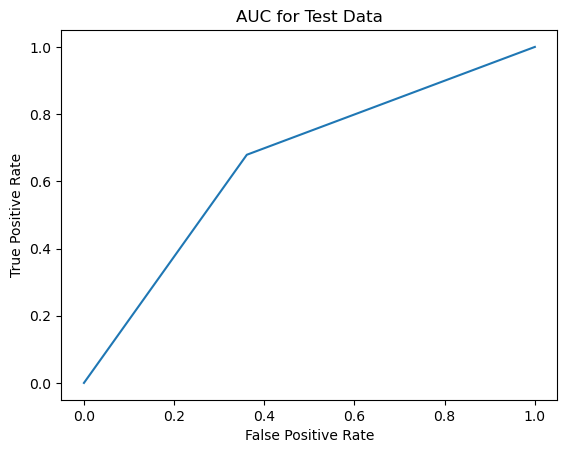

AUC Score:  0.6568664568941838


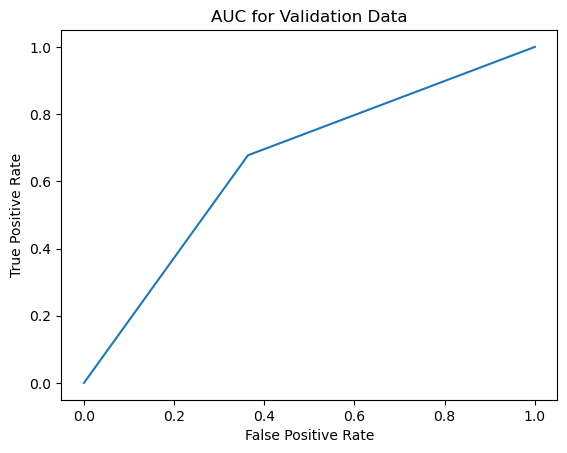

AUC Score:  0.6567541696514039


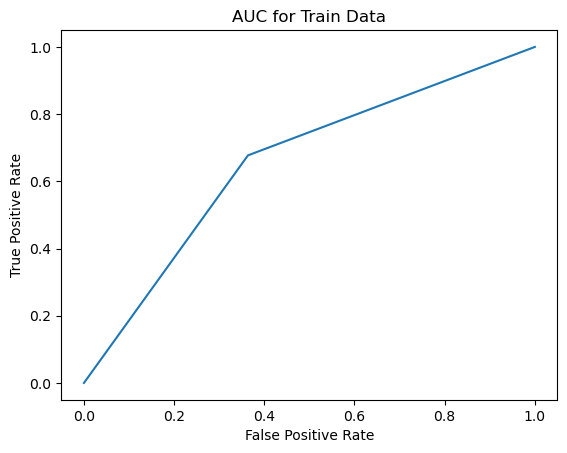

In [195]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

xgb = XGBClassifier(random_state = 42, max_delta_step = 1)

model2 = xgb.fit(X_train_undersampled_new, y_train_undersampled)

y_pred_train = model2.predict(X_train_undersampled_new)

param_grid2 = {'n_estimators': range(100, 201, 50),
               'tree_method': ['approx', 'hist', 'gpu_hist'],
               'subsample': np.arange(0.5, 1.2, 0.25),
               'colsample_by*': np.arange(0.5, 1.2, 0.25)}

K = 5
skf = StratifiedKFold(n_splits=K)

# Perform grid search to find the best parameters
grid_search2 = GridSearchCV(estimator=model2, param_grid=param_grid2, scoring='roc_auc', cv=skf, verbose=2)
grid_search2.fit(X_val_new, y_val)

best_params2 = grid_search2.best_params_
print(best_params2)

best_model2 = xgb.set_params(**grid_search2.best_params_)

best_model2.fit(X_train_undersampled_new, y_train_undersampled)

y_pred_val = best_model2.predict(X_val_new)

y_pred_test = best_model2.predict(X_test_new)

print("TRAIN: ")
print("ACCURACY SCORE: ", accuracy_score(y_train_undersampled, y_pred_train))
print("PRECISION SCORE: ", precision_score(y_train_undersampled, y_pred_train))
print("F1 SCORE: ", f1_score(y_train_undersampled, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_undersampled, y_pred_train))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_train_undersampled, y_pred_train))

print("VALIDATION: ")
print("ACCURACY SCORE: ", accuracy_score(y_val, y_pred_val))
print("PRECISION SCORE: ", precision_score(y_val, y_pred_val))
print("F1 SCORE: ", f1_score(y_val, y_pred_val))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_val, y_pred_val))

print("TEST: ")
print("ACCURACY SCORE: ", accuracy_score(y_test, y_pred_test))
print("PRECISION SCORE: ", precision_score(y_test, y_pred_test))
print("F1 SCORE: ", f1_score(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("CLASSIFICATION REPORT: ")
print(classification_report(y_test, y_pred_test))

def plot_graph(Y, X, plt_name=""):
    fpr, tpr, _ = metrics.roc_curve(Y,  X)
    auc = metrics.roc_auc_score(Y, X)
    print("AUC Score: ", auc)

    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(plt_name)
    plt.show()

plot_graph(y_test, y_pred_test, plt_name="AUC for Test Data")
plot_graph(y_val, y_pred_val, plt_name="AUC for Validation Data")
plot_graph(y_train_undersampled, y_pred_train, plt_name="AUC for Train Data")

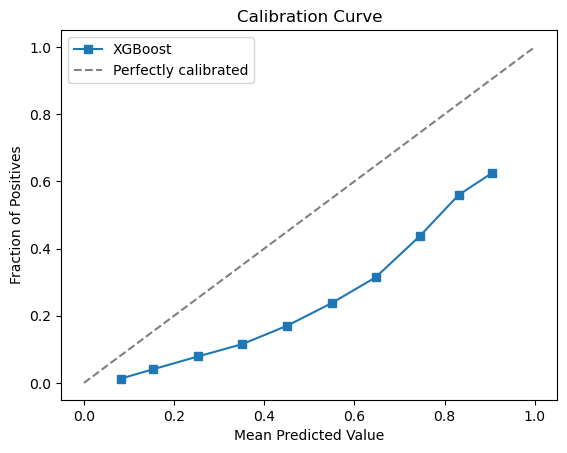

In [198]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt

predicted_probs = best_model2.predict_proba(X_test_new)[:, 1]
true_labels = y_test

# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(true_labels, predicted_probs, n_bins=10)

# Plot the calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='XGBoost')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

XGBoost SHAP

In [ ]:
import shap

TRAIN: 
ACCURACY SCORE:  0.6595592943130456
PRECISION SCORE:  0.6546923975170549
F1 SCORE:  0.664831787104042
Confusion Matrix:
[[101562  56185]
 [ 51222 106525]]
CLASSIFICATIN REPORT: 
              precision    recall  f1-score   support

           0       0.66      0.64      0.65    157747
           1       0.65      0.68      0.66    157747

    accuracy                           0.66    315494
   macro avg       0.66      0.66      0.66    315494
weighted avg       0.66      0.66      0.66    315494

VALIDATION: 
ACCURACY SCORE:  0.6465821401743643
PRECISION SCORE:  0.3180253924325879
F1 SCORE:  0.43178158395549704
Confusion Matrix:
[[135036  75899]
 [ 17257  35394]]
CLASSIFICATIN REPORT: 
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    210935
           1       0.32      0.67      0.43     52651

    accuracy                           0.65    263586
   macro avg       0.60      0.66      0.59    263586
weighted avg       0.7

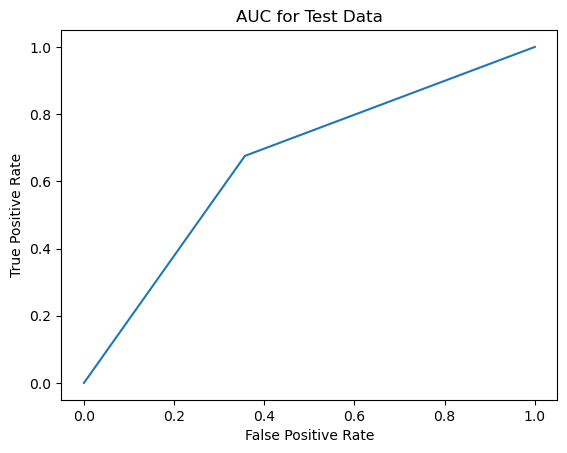

AUC Score:  0.6562080990815411


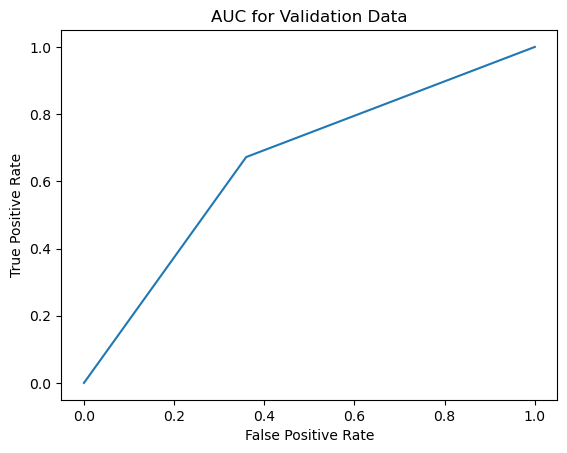

AUC Score:  0.6595592943130456


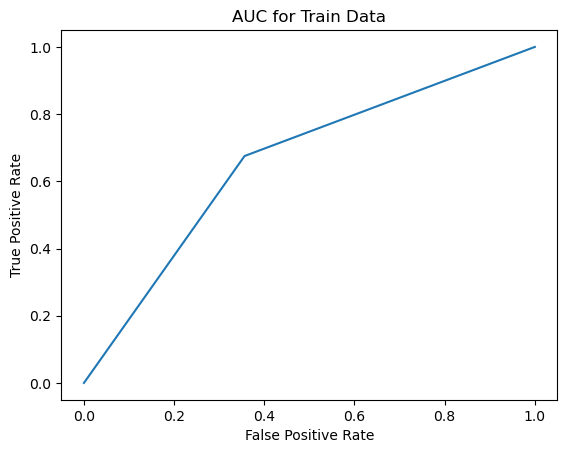

In [206]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

xgb = XGBClassifier(random_state = 42, max_delta_step = 1, subsample = 0.5, colsample_bytree = 0.5, colsample_bylevel = 0.5, colsample_bynode = 0.5,
                    n_estimators = 200, tree_method = 'approx')

model2 = xgb.fit(X_train_undersampled_new, y_train_undersampled)

y_pred_train = model2.predict(X_train_undersampled_new)

'''param_grid = {'n_estimators': range(100, 126),
              'criterion': ['gini', 'entropy', 'log_loss'],
              'min_samples_leaf': range(1, 11),
              'max_depth': [None, 10, 11, 12, 13, 14, 15],
              'max_features': [None, 'sqrt', 'log2', 1, 2, 3]}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2)
grid_search.fit(X_val_new2, y_val2)

best_params = grid_search.best_params_
print(best_params)

best_model = rf.set_params(**grid_search.best_params_)

best_model.fit(X_train_undersampled_new2, y_train_undersampled2)'''

y_pred_val = model2.predict(X_val_new)

y_pred_test = model2.predict(X_test_new)

print("TRAIN: ")
print("ACCURACY SCORE: ", accuracy_score(y_train_undersampled, y_pred_train))
print("PRECISION SCORE: ", precision_score(y_train_undersampled, y_pred_train))
print("F1 SCORE: ", f1_score(y_train_undersampled, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_undersampled, y_pred_train))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_train_undersampled, y_pred_train))

print("VALIDATION: ")
print("ACCURACY SCORE: ", accuracy_score(y_val, y_pred_val))
print("PRECISION SCORE: ", precision_score(y_val, y_pred_val))
print("F1 SCORE: ", f1_score(y_val, y_pred_val))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_val, y_pred_val))

print("TEST: ")
print("ACCURACY SCORE: ", accuracy_score(y_test, y_pred_test))
print("PRECISION SCORE: ", precision_score(y_test, y_pred_test))
print("F1 SCORE: ", f1_score(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("CLASSIFICATION REPORT: ")
print(classification_report(y_test, y_pred_test))

def plot_graph(Y, X, plt_name=""):
    fpr, tpr, _ = metrics.roc_curve(Y,  X)
    auc = metrics.roc_auc_score(Y, X)
    print("AUC Score: ", auc)

    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(plt_name)
    plt.show()

plot_graph(y_test, y_pred_test, plt_name="AUC for Test Data")
plot_graph(y_val, y_pred_val, plt_name="AUC for Validation Data")
plot_graph(y_train_undersampled, y_pred_train, plt_name="AUC for Train Data")

In [208]:
background_train = shap.maskers.Independent(X_train_undersampled_new, max_samples=100)
explainer = shap.Explainer(model2, background_train)
shap_values = explainer(X_train_undersampled_new)
shap_values.display_data = X_train_undersampled_new.values

100%|===================| 315075/315494 [10:26<00:00]        

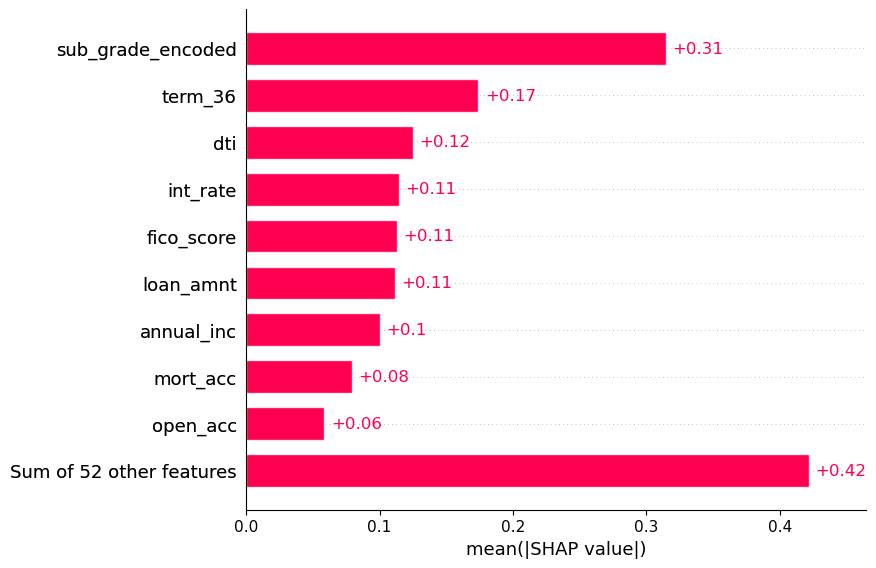

In [209]:
shap.plots.bar(shap_values)

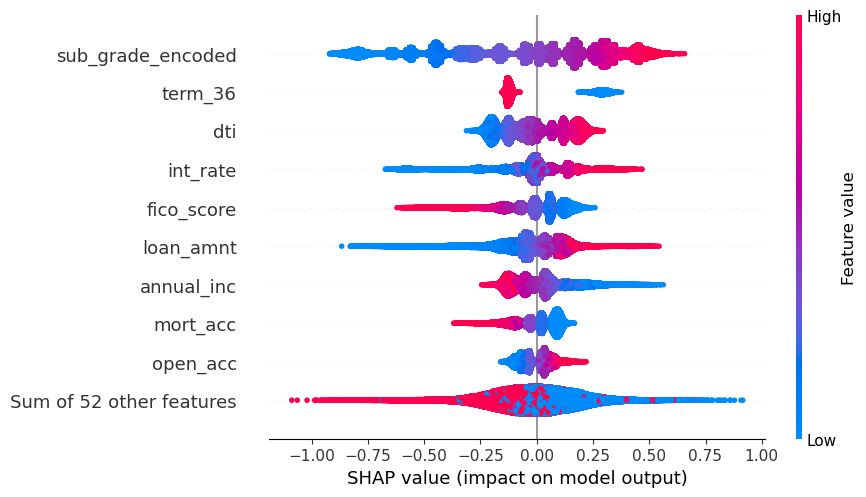

In [210]:
shap.plots.beeswarm(shap_values)

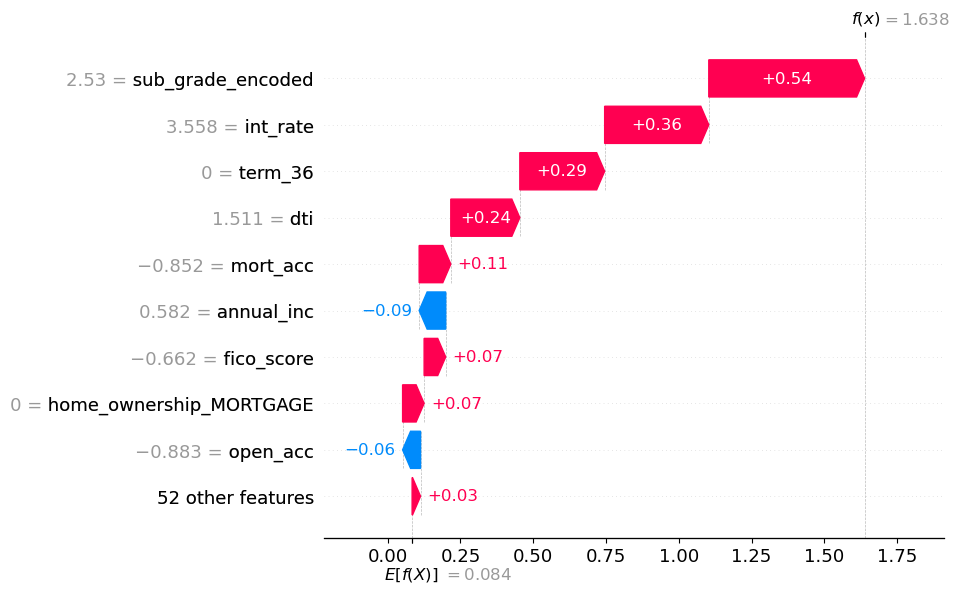

In [211]:
shap.plots.waterfall(shap_values[10], max_display = 10)

In [212]:
shap.plots.force(shap_values[10], features=pd.DataFrame(X_train_undersampled_new.iloc[10, :]))

In [272]:
background_test = shap.maskers.Independent(X_test_new, max_samples=100)
explainer = shap.Explainer(model2, background_test)
shap_values = explainer(X_test_new)
shap_values.display_data = X_test_new.values

100%|===================| 263541/263586 [08:51<00:00]        

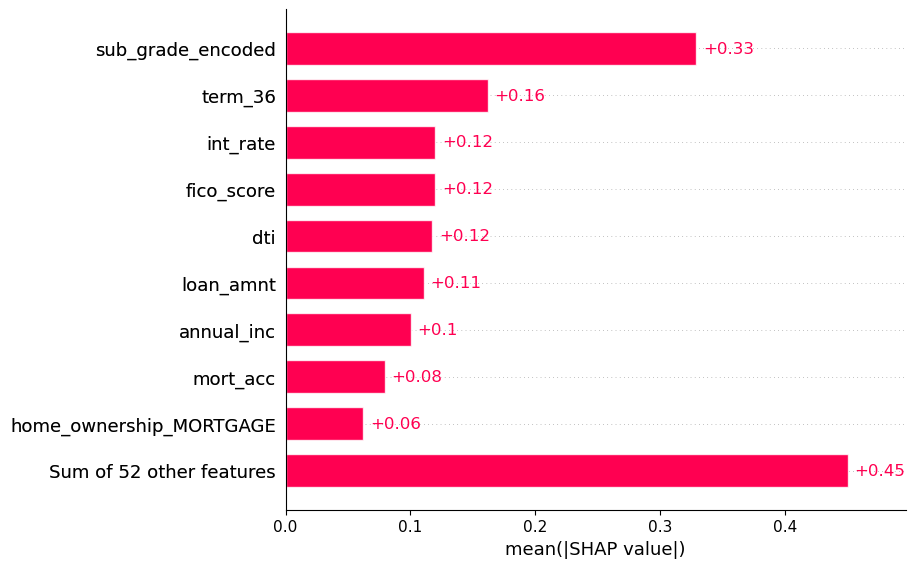

In [214]:
shap.plots.bar(shap_values)

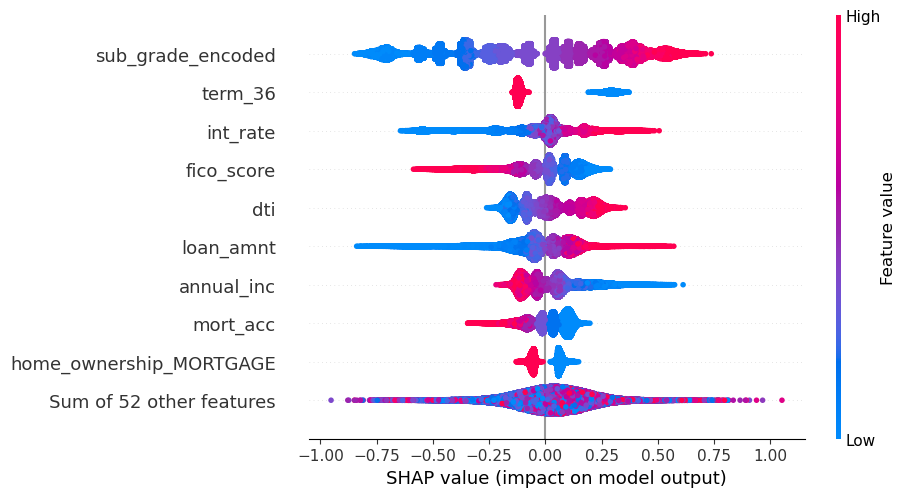

In [215]:
shap.plots.beeswarm(shap_values)

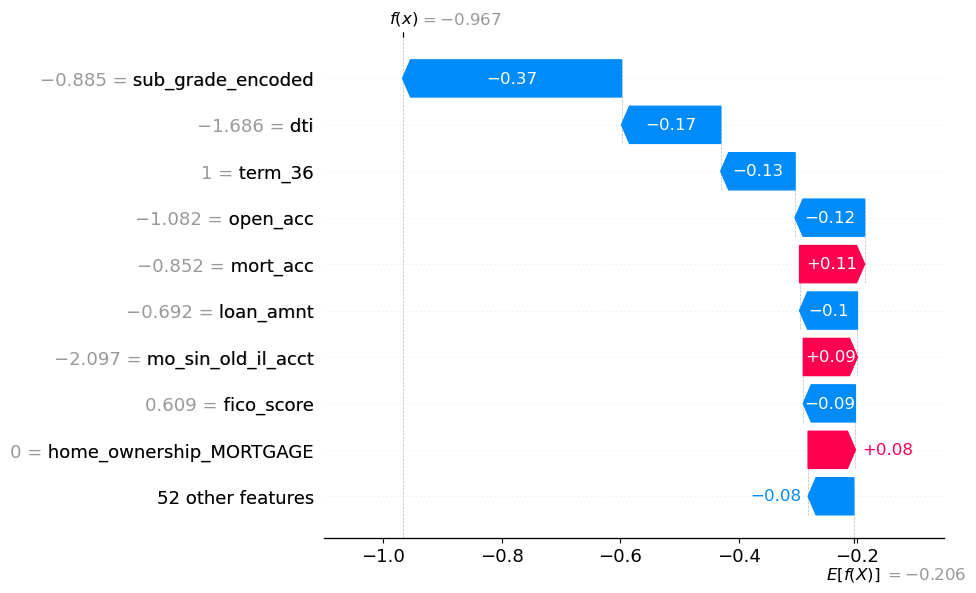

In [216]:
shap.plots.waterfall(shap_values[10], max_display = 10)

In [217]:
shap.plots.force(shap_values[10], features=pd.DataFrame(X_test_new.iloc[10, :]))

RANDOM FOREST
- This Random Forest is our initial try, but we see that there is overfitting

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state=42)

model = rf.fit(X_train_undersampled_new, y_train_undersampled)

y_pred_train = model.predict(X_train_undersampled_new)

'''param_grid = {'n_estimators': range(100, 126),
              'criterion': ['gini', 'entropy', 'log_loss'],
              'min_samples_leaf': range(1, 11),
              'max_depth': [None, 10, 11, 12, 13, 14, 15],
              'max_features': [None, 'sqrt', 'log2', 1, 2, 3]}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2)
grid_search.fit(X_val_new2, y_val2)

best_params = grid_search.best_params_
print(best_params)

best_model = rf.set_params(**grid_search.best_params_)

best_model.fit(X_train_undersampled_new2, y_train_undersampled2)'''

y_pred_val = model.predict(X_val_new)

y_pred_test = model.predict(X_test_new)

print("TRAIN: ")
print("ACCURACY SCORE: ", accuracy_score(y_train_undersampled, y_pred_train))
print("PRECISION SCORE: ", precision_score(y_train_undersampled, y_pred_train))
print("F1 SCORE: ", f1_score(y_train_undersampled, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_undersampled, y_pred_train))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_train_undersampled, y_pred_train))

print("VALIDATION: ")
print("ACCURACY SCORE: ", accuracy_score(y_val, y_pred_val))
print("PRECISION SCORE: ", precision_score(y_val, y_pred_val))
print("F1 SCORE: ", f1_score(y_val, y_pred_val))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_val, y_pred_val))

print("TEST: ")
print("ACCURACY SCORE: ", accuracy_score(y_test, y_pred_test))
print("PRECISION SCORE: ", precision_score(y_test, y_pred_test))
print("F1 SCORE: ", f1_score(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("CLASSIFICATION REPORT: ")
print(classification_report(y_test, y_pred_test))

def plot_graph(Y, X, plt_name=""):
    fpr, tpr, _ = metrics.roc_curve(Y,  X)
    auc = metrics.roc_auc_score(Y, X)
    print("AUC Score: ", auc)

    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(plt_name)
    plt.show()

plot_graph(y_test, y_pred_test, plt_name="AUC for Test Data")
plot_graph(y_val, y_pred_val, plt_name="AUC for Validation Data")
plot_graph(y_train_undersampled, y_pred_train, plt_name="AUC for Train Data")

- RANDOM FOREST - HYPERPARAMETER TUNING

    - n_estimators: This parameter specifies the number of decision trees in the random forest. Increasing the number of estimators can improve performance, but it also increases computation time.

    - max_depth: It controls the maximum depth of each decision tree in the random forest. A higher value can lead to overfitting, while a lower value can result in underfitting. It is important to find the right balance.

    - max_features: This parameter determines the maximum number of features to consider when looking for the best split. A smaller value can help reduce overfitting.

    - criterion: It determines the quality of a split. The two commonly used criteria are "gini" for the Gini impurity and "entropy" for the information gain.

Fitting 5 folds for each of 132 candidates, totalling 660 fits
[CV] END criterion=gini, max_features=sqrt, n_estimators=100; total time=  47.4s
[CV] END criterion=gini, max_features=sqrt, n_estimators=100; total time=  47.3s
[CV] END criterion=gini, max_features=sqrt, n_estimators=100; total time=  46.5s
[CV] END criterion=gini, max_features=sqrt, n_estimators=100; total time=  47.8s
[CV] END criterion=gini, max_features=sqrt, n_estimators=100; total time=  47.6s
[CV] END criterion=gini, max_features=sqrt, n_estimators=101; total time=  49.0s
[CV] END criterion=gini, max_features=sqrt, n_estimators=101; total time=  47.1s
[CV] END criterion=gini, max_features=sqrt, n_estimators=101; total time=  48.8s
[CV] END criterion=gini, max_features=sqrt, n_estimators=101; total time=  47.4s
[CV] END criterion=gini, max_features=sqrt, n_estimators=101; total time=  47.6s
[CV] END criterion=gini, max_features=sqrt, n_estimators=102; total time=  49.0s
[CV] END criterion=gini, max_features=sqrt, n_

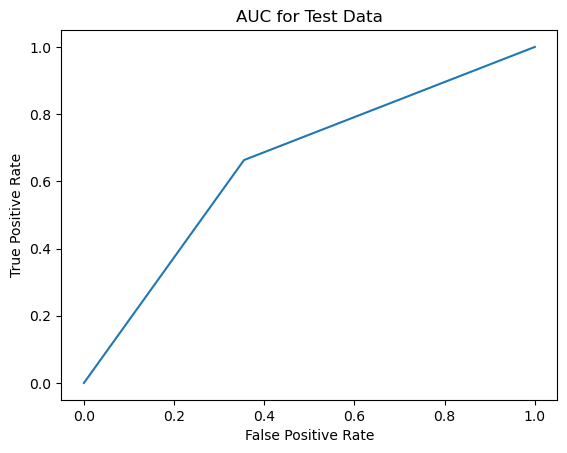

AUC Score:  0.6528613527547131


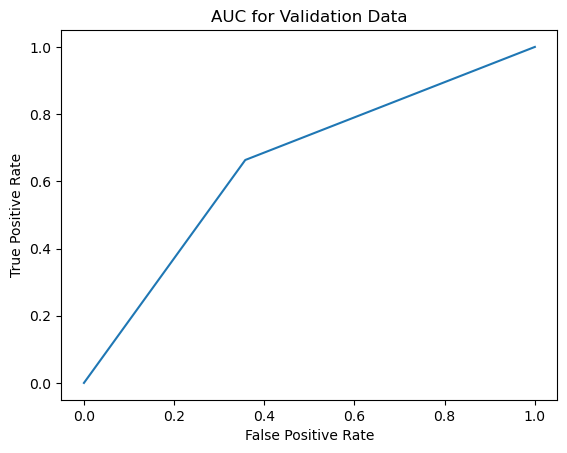

AUC Score:  1.0


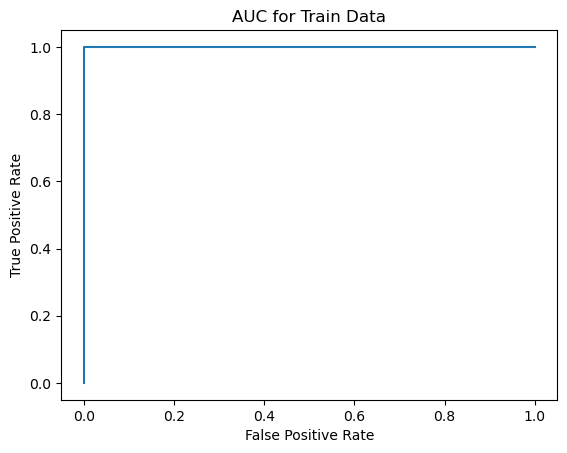

In [190]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

rf = RandomForestClassifier()

model = rf.fit(X_train_undersampled_new, y_train_undersampled)

y_pred_train = model.predict(X_train_undersampled_new)

param_grid = {'n_estimators': range(100, 111),
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2', 1, 2]}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2)
grid_search.fit(X_val_new, y_val)

best_params = grid_search.best_params_
print(best_params)

best_model = rf.set_params(**grid_search.best_params_)

best_model.fit(X_train_undersampled_new, y_train_undersampled)

y_pred_val = best_model.predict(X_val_new)

y_pred_test = best_model.predict(X_test_new)

print("TRAIN: ")
print("ACCURACY SCORE: ", accuracy_score(y_train_undersampled, y_pred_train))
print("PRECISION SCORE: ", precision_score(y_train_undersampled, y_pred_train))
print("F1 SCORE: ", f1_score(y_train_undersampled, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_undersampled, y_pred_train))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_train_undersampled, y_pred_train))

print("VALIDATION: ")
print("ACCURACY SCORE: ", accuracy_score(y_val, y_pred_val))
print("PRECISION SCORE: ", precision_score(y_val, y_pred_val))
print("F1 SCORE: ", f1_score(y_val, y_pred_val))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_val, y_pred_val))

print("TEST: ")
print("ACCURACY SCORE: ", accuracy_score(y_test, y_pred_test))
print("PRECISION SCORE: ", precision_score(y_test, y_pred_test))
print("F1 SCORE: ", f1_score(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("CLASSIFICATION REPORT: ")
print(classification_report(y_test, y_pred_test))

def plot_graph(Y, X, plt_name=""):
    fpr, tpr, _ = metrics.roc_curve(Y,  X)
    auc = metrics.roc_auc_score(Y, X)
    print("AUC Score: ", auc)

    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(plt_name)
    plt.show()

plot_graph(y_test, y_pred_test, plt_name="AUC for Test Data")
plot_graph(y_val, y_pred_val, plt_name="AUC for Validation Data")
plot_graph(y_train_undersampled, y_pred_train, plt_name="AUC for Train Data")

- Our model is overfitting, therefore we use hyper tuning on n_estimators and the max_depth parmaters to overcome this.

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ......................max_depth=5, n_estimators=100; total time=  10.8s
[CV] END ......................max_depth=5, n_estimators=100; total time=  10.8s
[CV] END ......................max_depth=5, n_estimators=100; total time=  10.7s
[CV] END ......................max_depth=5, n_estimators=100; total time=  10.9s
[CV] END ......................max_depth=5, n_estimators=100; total time=  11.1s
[CV] END ......................max_depth=5, n_estimators=150; total time=  16.3s
[CV] END ......................max_depth=5, n_estimators=150; total time=  16.1s
[CV] END ......................max_depth=5, n_estimators=150; total time=  16.1s
[CV] END ......................max_depth=5, n_estimators=150; total time=  16.1s
[CV] END ......................max_depth=5, n_estimators=150; total time=  16.1s
[CV] END ......................max_depth=5, n_estimators=200; total time=  21.2s
[CV] END ......................max_depth=5, n_es

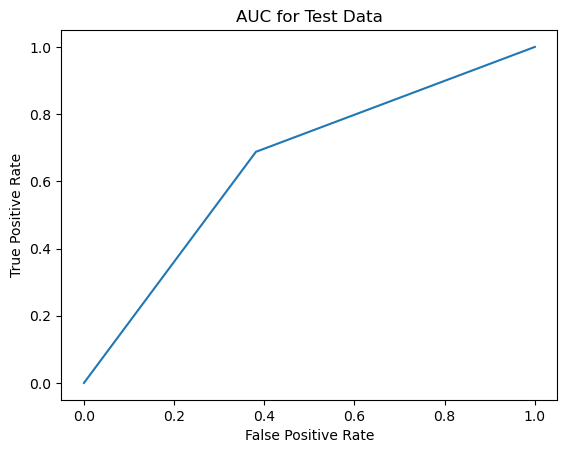

AUC Score:  0.6502849462201943


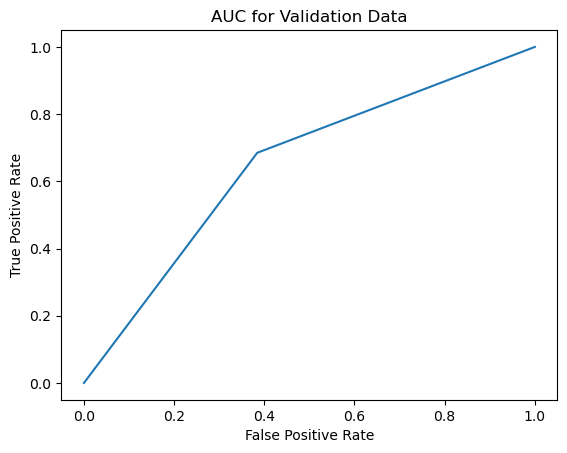

AUC Score:  0.662605311036026


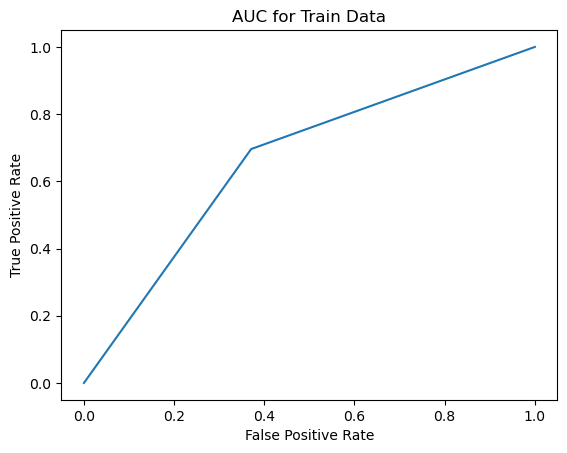

In [207]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state=42)

model = rf.fit(X_train_undersampled_new, y_train_undersampled)

#y_pred_train = model.predict(X_train_undersampled_new)

param_grid = {'max_depth': range(5, 26, 5),
              'n_estimators': range(100, 201, 50)}

K = 5
skf = StratifiedKFold(n_splits=K)

# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='precision', cv=skf, verbose=2)
grid_search.fit(X_val_new, y_val)

best_params = grid_search.best_params_
print(best_params)

best_model = rf.set_params(**grid_search.best_params_)

best_model.fit(X_train_undersampled_new, y_train_undersampled)

y_pred_train = best_model.predict(X_train_undersampled_new)

y_pred_val = best_model.predict(X_val_new)

y_pred_test = best_model.predict(X_test_new)

print("TRAIN: ")
print("ACCURACY SCORE: ", accuracy_score(y_train_undersampled, y_pred_train))
print("PRECISION SCORE: ", precision_score(y_train_undersampled, y_pred_train))
print("F1 SCORE: ", f1_score(y_train_undersampled, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_undersampled, y_pred_train))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_train_undersampled, y_pred_train))

print("VALIDATION: ")
print("ACCURACY SCORE: ", accuracy_score(y_val, y_pred_val))
print("PRECISION SCORE: ", precision_score(y_val, y_pred_val))
print("F1 SCORE: ", f1_score(y_val, y_pred_val))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_val, y_pred_val))

print("TEST: ")
print("ACCURACY SCORE: ", accuracy_score(y_test, y_pred_test))
print("PRECISION SCORE: ", precision_score(y_test, y_pred_test))
print("F1 SCORE: ", f1_score(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("CLASSIFICATION REPORT: ")
print(classification_report(y_test, y_pred_test))

def plot_graph(Y, X, plt_name=""):
    fpr, tpr, _ = metrics.roc_curve(Y,  X)
    auc = metrics.roc_auc_score(Y, X)
    print("AUC Score: ", auc)

    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(plt_name)
    plt.show()

plot_graph(y_test, y_pred_test, plt_name="AUC for Test Data")
plot_graph(y_val, y_pred_val, plt_name="AUC for Validation Data")
plot_graph(y_train_undersampled, y_pred_train, plt_name="AUC for Train Data")

In [194]:
#pd.DataFrame(best_model.feature_importances_, index = X_train_undersampled_new.columns)

0
loan_amnt                    0.064030
int_rate                     0.085483
annual_inc                   0.068717
earliest_cr_line             0.071366
open_acc                     0.052699
...                               ...
addr_state_WA                0.002943
addr_state_WV                0.000729
addr_state_WY                0.000428
initial_list_status_f        0.011113
application_type_Individual  0.002449

[61 rows x 1 columns]

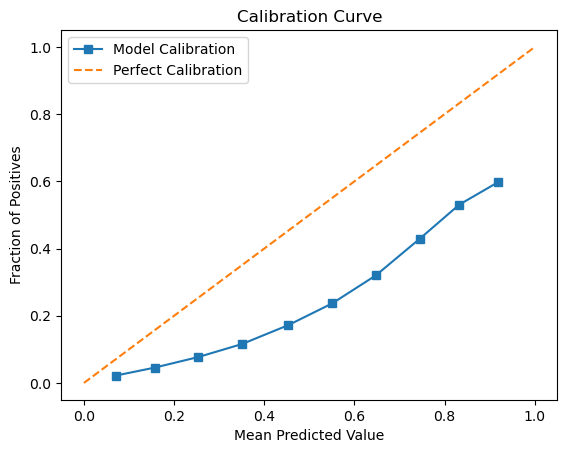

In [197]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Assuming you have your predicted probabilities and true labels
predicted_probs = best_model.predict_proba(X_test_new)[:, 1]
true_labels = y_test

# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(true_labels, predicted_probs, n_bins=10)

# Plot calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Model Calibration')
plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Curve')
plt.show()


Random Forest - SHAP

- SHAP Analysis for Random Forest is done by KernelExplainer function of SHAP library. However, it causes a lot of time to calculate shap values for our dataset. Therefore, we select 100 random observations from the train and test set to look at the SHAP plots

In [189]:
import shap
shap.initjs()

TRAIN: 
ACCURACY SCORE:  1.0
PRECISION SCORE:  1.0
F1 SCORE:  1.0
Confusion Matrix:
[[157747      0]
 [     0 157747]]
CLASSIFICATIN REPORT: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    157747
           1       1.00      1.00      1.00    157747

    accuracy                           1.00    315494
   macro avg       1.00      1.00      1.00    315494
weighted avg       1.00      1.00      1.00    315494

VALIDATION: 
ACCURACY SCORE:  0.6460282412571229
PRECISION SCORE:  0.3170966551783095
F1 SCORE:  0.4303142058151888
Confusion Matrix:
[[135046  75889]
 [ 17413  35238]]
CLASSIFICATIN REPORT: 
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    210935
           1       0.32      0.67      0.43     52651

    accuracy                           0.65    263586
   macro avg       0.60      0.65      0.59    263586
weighted avg       0.77      0.65      0.68    263586

TEST: 
ACCUR

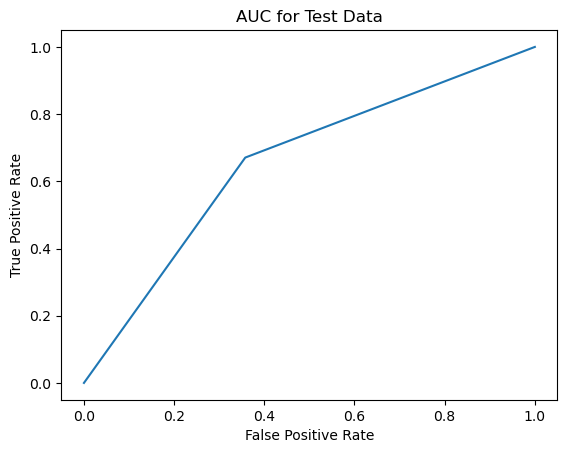

AUC Score:  0.6547503497224647


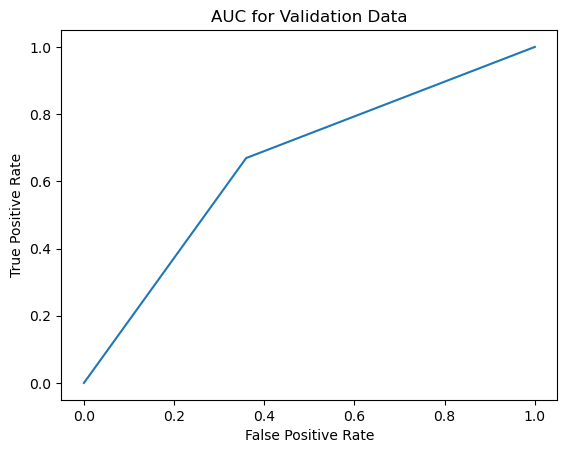

AUC Score:  1.0


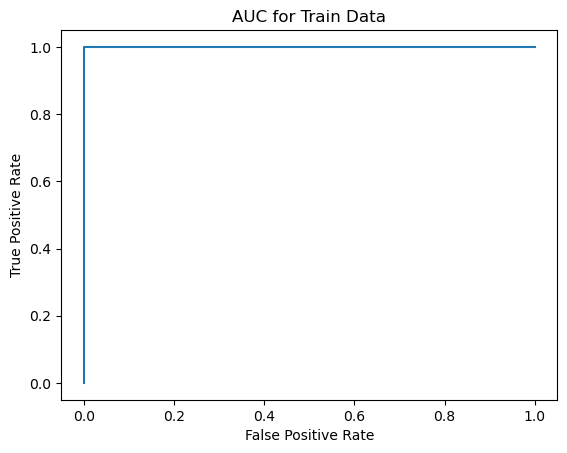

In [190]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

rf = RandomForestClassifier(criterion='entropy', max_features='sqrt', n_estimators=200, random_state=42)

model = rf.fit(X_train_undersampled_new, y_train_undersampled)

y_pred_train = model.predict(X_train_undersampled_new)

'''param_grid = {'n_estimators': range(100, 126),
              'criterion': ['gini', 'entropy', 'log_loss'],
              'min_samples_leaf': range(1, 11),
              'max_depth': [None, 10, 11, 12, 13, 14, 15],
              'max_features': [None, 'sqrt', 'log2', 1, 2, 3]}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2)
grid_search.fit(X_val_new2, y_val2)

best_params = grid_search.best_params_
print(best_params)

best_model = rf.set_params(**grid_search.best_params_)

best_model.fit(X_train_undersampled_new2, y_train_undersampled2)'''

y_pred_val = model.predict(X_val_new)

y_pred_test = model.predict(X_test_new)

print("TRAIN: ")
print("ACCURACY SCORE: ", accuracy_score(y_train_undersampled, y_pred_train))
print("PRECISION SCORE: ", precision_score(y_train_undersampled, y_pred_train))
print("F1 SCORE: ", f1_score(y_train_undersampled, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train_undersampled, y_pred_train))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_train_undersampled, y_pred_train))

print("VALIDATION: ")
print("ACCURACY SCORE: ", accuracy_score(y_val, y_pred_val))
print("PRECISION SCORE: ", precision_score(y_val, y_pred_val))
print("F1 SCORE: ", f1_score(y_val, y_pred_val))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))
print("CLASSIFICATIN REPORT: ")
print(classification_report(y_val, y_pred_val))

print("TEST: ")
print("ACCURACY SCORE: ", accuracy_score(y_test, y_pred_test))
print("PRECISION SCORE: ", precision_score(y_test, y_pred_test))
print("F1 SCORE: ", f1_score(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("CLASSIFICATION REPORT: ")
print(classification_report(y_test, y_pred_test))

def plot_graph(Y, X, plt_name=""):
    fpr, tpr, _ = metrics.roc_curve(Y,  X)
    auc = metrics.roc_auc_score(Y, X)
    print("AUC Score: ", auc)

    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(plt_name)
    plt.show()

plot_graph(y_test, y_pred_test, plt_name="AUC for Test Data")
plot_graph(y_val, y_pred_val, plt_name="AUC for Validation Data")
plot_graph(y_train_undersampled, y_pred_train, plt_name="AUC for Train Data")

SHAP - Train

In [221]:
random_index = np.random.choice(len(X_train_undersampled_new), size=100, replace=False)
explainer = shap.KernelExplainer(model.predict_proba, X_train_undersampled_new.iloc[X_train_undersampled_new.index.isin(random_index), :])
shap_values = explainer.shap_values(X_train_undersampled_new.iloc[X_train_undersampled_new.index.isin(random_index), :])
#shap_values.display_data = X_train_undersampled_new.iloc[X_train_undersampled_new.index.isin(random_index), :].values

  0%|          | 0/100 [00:00<?, ?it/s]

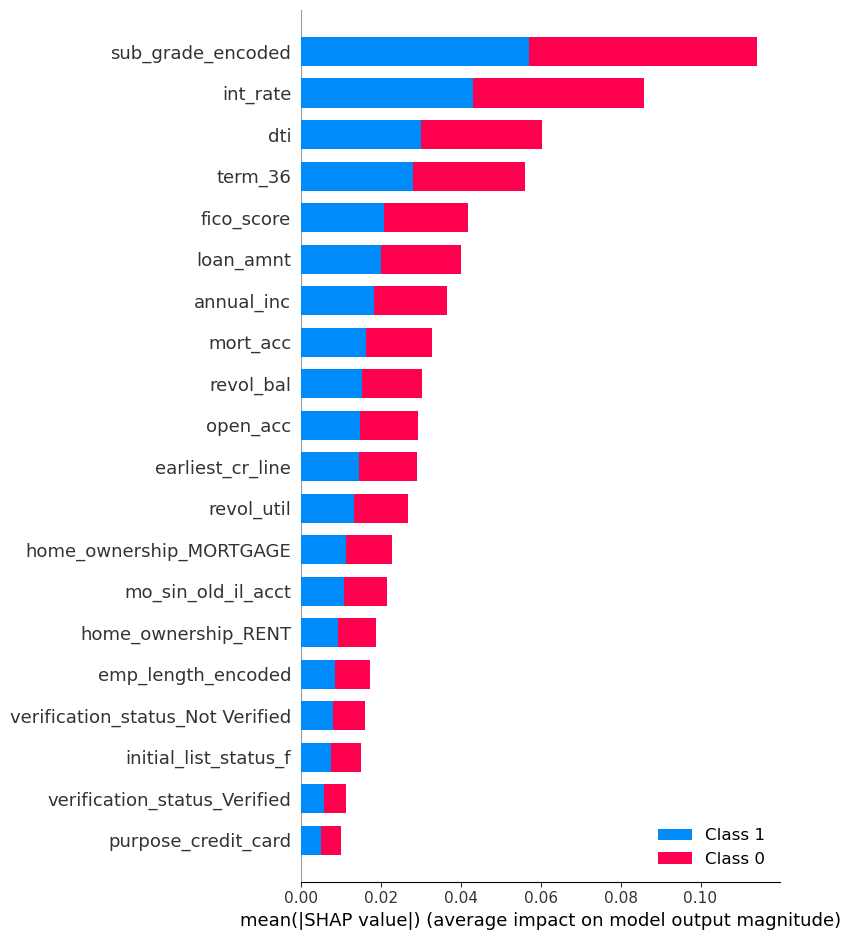

In [232]:
shap.summary_plot(shap_values, X_train_undersampled_new.iloc[X_train_undersampled_new.index.isin(random_index), :])

SHAP - Test

In [236]:
random_index = np.random.choice(len(X_test_new), size=100, replace=False)
explainer = shap.KernelExplainer(model.predict_proba, X_test_new.iloc[X_test_new.index.isin(random_index), :])
shap_values = explainer.shap_values(X_test_new.iloc[X_test_new.index.isin(random_index), :])
#shap_values.display_data = X_train_undersampled_new.iloc[X_train_undersampled_new.index.isin(random_index), :].values

  0%|          | 0/100 [00:00<?, ?it/s]

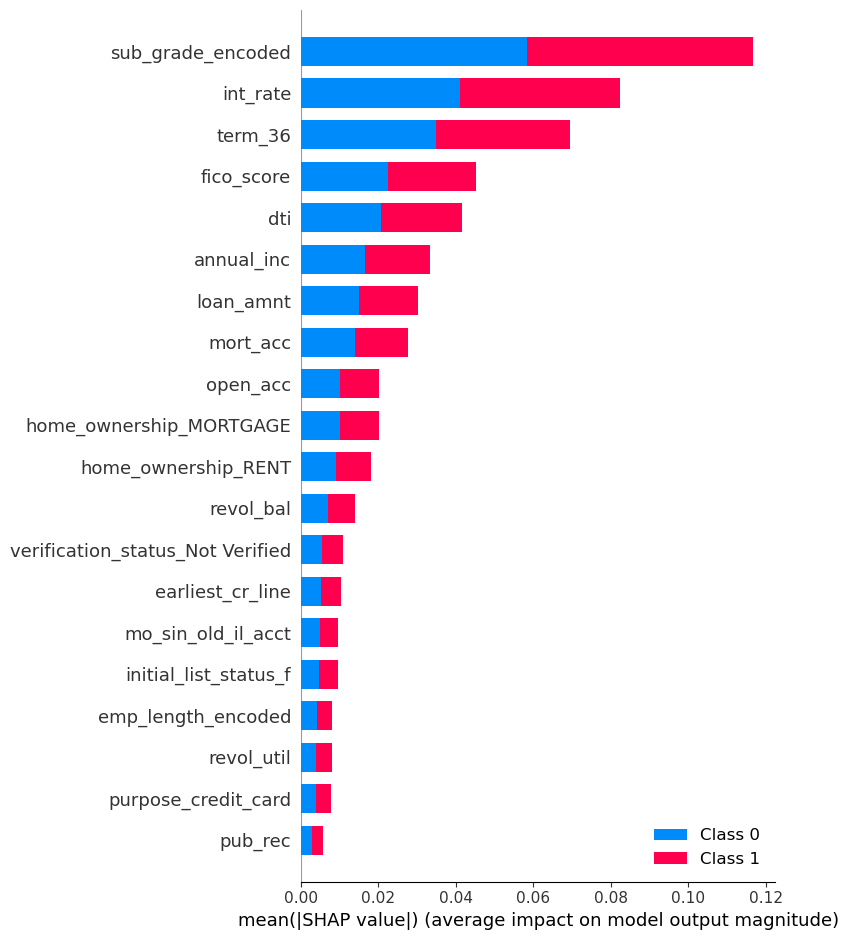

In [238]:
shap.summary_plot(shap_values, X_test_new.iloc[X_test_new.index.isin(random_index), :])

FEATURE SELECTION - OVERSAMPLING

- Recursive Feature Elimination with Cross Validation using LightGBM and Lasso Regression as the estimator. we adjusted n_estimator parameters to reduce the computation time for LightGBM

- We tried Random Forest and XGBoost as estimators however, those algorithms are computationally expensive in large datasets.

In [ ]:
df_attributes = df3.drop(columns = ['loan_status'])
df_target = pd.DataFrame(df3.loan_status)
df_attributes.shape, df_target.shape

In [ ]:
#MAIN CODE - DON'T DELETE!!!!!!!!!!!!!!!!!!!!!!!
'''from sklearn.feature_selection import RFECV
import lightgbm as lgb

# Assuming X is your feature matrix and y is your target variable
estimator = lgb.LGBMRegressor(n_estimators=50)
rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='r2', verbose=1)
rfecv.fit(df_attributes, df_target)

# Get the selected features
selected_features = df_attributes.columns[rfecv.support_]

pd.DataFrame(selected_features).to_excel("selected_features_lightgbm.xlsx", index = False)

# Print the ranking of features
print("Feature Ranking:")
print(rfecv.ranking_)

pd.DataFrame(rfecv.ranking_, index = df_attributes.columns).to_excel("selected_features_lightgbm_rankings.xlsx", index = False)

# Print the selected features
print("Selected Features:")
print(selected_features)'''

Lasso Regression

In [ ]:
#MAIN CODE - DON'T DELETE!!!!!!!!!!!!!!!!!!!!!!!
'''from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Assuming X is your feature matrix and y is your target variable
params = {'alpha': (np.logspace(-8, 8, 100))} # It will check from 1e-08 to 1e+08
lasso = Lasso(normalize=True)
lasso_model = GridSearchCV(lasso, params, cv = 10)
lasso_model.fit(df_attributes, df_target)

alpha = list(lasso_model.best_params_.values())
estimator = Lasso(alpha=alpha[0], normalize=True)

rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='r2')
rfecv.fit(df_attributes, df_target)

# Get the selected features
selected_features = df_attributes.columns[rfecv.support_]

pd.DataFrame(selected_features).to_excel("selected_features_lasso.xlsx", index = False)

# Print the ranking of features
print("Feature Ranking:")
print(rfecv.ranking_)

pd.DataFrame(selected_features).to_excel("selected_features_lasso_rankings.xlsx", index = False)

# Print the selected features
print("Selected Features:")
print(selected_features)'''

LOAD SELECTED FEATURES & APPLY OVERSAMPLING - ADASYN 

- While we are oversampling, we used gridsearchcv method to tune n_neighbours hyperparameter of adasyn and use stratified cv method (better when there is class imbalance) based on f1-score to create a better oversampling. default n_neighbors value is 5 based on the documentation. we tried from 5 to 10 to find the best n_neighbor parameter

In [ ]:
variables_selected = pd.read_excel("selected_features_lightgbm.xlsx")
variables_selected_list = variables_selected.iloc[:, 0].tolist()
df_attributes_new = df_attributes.loc[:, variables_selected_list]
df_attributes_new.shape, df_attributes.shape

In [ ]:
def split_sets(df_X, df_y):
    df_attributes_new = df_X
    df_target = df_y

    X_train_temp, X_test, y_train_temp, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

sets = split_sets(df_attributes_new, df_target)

X_train = sets[0]
X_val = sets[1]
X_test = sets[2]
y_train = sets[3]
y_val = sets[4]
y_test = sets[5]

In [ ]:
df_target.reset_index().groupby(by = 'loan_status').count()

In [ ]:
y_test.reset_index().groupby(by = 'loan_status').count()

In [ ]:
#MAIN CODE - DON'T DELETE!!!!!!!!!!!!!!!!!!!!!!!
'''from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score

X = X_train.values
y = y_train.values.ravel()

adasyn = ADASYN()

param_grid = {'n_neighbors': range(5, 11)}

K = 5
skf = StratifiedKFold(n_splits=K)

grid_search = GridSearchCV(adasyn, param_grid, cv=skf, scoring=f1_score, verbose = 1)
grid_search.fit(X, y)

best_params = grid_search.best_params_
final_model = adasyn.set_params(**grid_search.best_params_)

X_train_oversampled, y_train_oversampled = final_model.fit_resample(X_train, y_train)'''

In [ ]:
#y_train_oversampled.reset_index().groupby('loan_status').count()

In [ ]:
#X_train_oversampled.shape, y_train_oversampled.shape

In [ ]:
#X_train_oversampled.to_csv("Xtrain_oversampled.csv", index = False)
#y_train_oversampled.to_csv("ytrain_oversampled.csv", index = False)
#X_test.to_csv("Xtest.csv", index = False)
#y_test.to_csv("ytest.csv", index = False)
#X_val.to_csv("Xval.csv", index = False)
#y_val.to_csv("yval.csv", index = False)

OUTLIER DETECTION

- Return the anomaly score of each sample using the IsolationForest algorithm. It uses 100 default estimators.

- The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

- Fit_predict Perform fit on X and returns labels for X. Returns -1 for outliers and 1 for inliers. Standardization can make the distribution of variables more symmetric and centered around zero, which can simplify the outlier detection process. Outliers may appear as extreme values compared to the standardized distribution.

- When we look at the percentage of outliers before we train our data, we see that it's 1% which is not excessive amount of outliers in our training data.</b>

In [ ]:
'''X_train_oversampled = pd.read_csv("Xtrain_oversampled.csv", sep=',')
y_train_oversampled = pd.read_csv("ytrain_oversampled.csv", sep=',')
X_train_oversampled'''

In [ ]:
'''X_train_oversampled.shape, y_train_oversampled.shape'''

In [ ]:
'''from sklearn.ensemble import IsolationForest

isofor = IsolationForest(random_state=42)

clf = isofor.fit_predict(X_train_oversampled)
outliers = pd.DataFrame(clf).loc[pd.DataFrame(clf)[0] == -1].count().values[0]
total_samples = len(X_train_oversampled)

outlier_percentage = round(outliers / total_samples, 2)
outlier_percentage'''